In [1]:
# import matplotlib.pyplot as plt
# from flow_analysis import Participant_Flow, Flow_Results

In [136]:
import os
import json
import snirf
import ctypes
import datetime
import warnings
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from math import floor
from matplotlib.axes import Axes
from matplotlib.font_manager import FontProperties
from adjustText import adjust_text
from PIL import Image
from statistics import mean
from scipy.stats import ttest_1samp
from scipy.signal import butter, filtfilt, sosfiltfilt, correlate, correlation_lags
from typing import Union, Tuple, List, Literal
from behav_analysis import Participant_Behav
from data_functions import Data_Functions, load_results, exp_name_to_title

hllDll = ctypes.WinDLL(
    r"C:\Program Files\R\R-4.2.3\bin\x64\R.dll"
)  # path to R DLL file
import rpy2.robjects as robjects


class Flow_Coordinates:
    """
    Convert Kernel Flow XYZ coordinates into the MRIcron AAL template XYZ and MNI coordinates. All units in mm.
    Brain anatomical directions:
        x-pos = right
        x-neg = left
        y-pos = anterior
        y-neg = posterior
        z-pos = superior
        z-neg = inferior
    """

    def __init__(self, source_detector_df: pd.DataFrame) -> None:
        """
        Args:
            source_detector_df (pd.DataFrame): DataFrame with inter-module source and detector XYZ coordinates.
        """
        self.sd_df = source_detector_df

        # measurements from: https://doi.org/10.1002/jbio.201900175
        self.SCALP_THICKNESS = 3
        self.SKULL_THICKNESS = 7
        self.CSF_THICKNESS = 2
        self.BRAIN_SURFACE_DEPTH = (
            self.SCALP_THICKNESS + self.SKULL_THICKNESS + self.CSF_THICKNESS
        )

        # XYZ and MNI measurements from MRIcron AAL template: https://www.nitrc.org/projects/mricron
        self.XYZ_ORIGIN = (91, 126, 72)
        self.MNI_ORIGIN = (0, 0, 0)

        self.X_MIN = 18
        self.Y_MIN = 21
        self.Z_MIN = 11

        self.X_MAX = 163
        self.Y_MAX = 200
        self.Z_MAX = 156

        self.MNI_X_MIN = -73
        self.MNI_Y_MIN = -105
        self.MNI_Z_MIN = -61

        self.MNI_X_MAX = 72
        self.MNI_Y_MAX = 74
        self.MNI_Z_MAX = 84

        self.X_MIN_ADJ = self.X_MIN - self.BRAIN_SURFACE_DEPTH
        self.Y_MIN_ADJ = self.Y_MIN - self.BRAIN_SURFACE_DEPTH
        self.Z_MIN_ADJ = self.Z_MIN - self.BRAIN_SURFACE_DEPTH
        self.X_MAX_ADJ = self.X_MAX + self.BRAIN_SURFACE_DEPTH
        self.Y_MAX_ADJ = self.Y_MAX + self.BRAIN_SURFACE_DEPTH
        self.Z_MAX_ADJ = self.Z_MAX + self.BRAIN_SURFACE_DEPTH

        self.MNI_X_MIN_ADJ = self.MNI_X_MIN - self.BRAIN_SURFACE_DEPTH
        self.MNI_Y_MIN_ADJ = self.MNI_Y_MIN - self.BRAIN_SURFACE_DEPTH
        self.MNI_Z_MIN_ADJ = self.MNI_Z_MIN - self.BRAIN_SURFACE_DEPTH
        self.MNI_X_MAX_ADJ = self.MNI_X_MAX + self.BRAIN_SURFACE_DEPTH
        self.MNI_Y_MAX_ADJ = self.MNI_Y_MAX + self.BRAIN_SURFACE_DEPTH
        self.MNI_Z_MAX_ADJ = self.MNI_Z_MAX + self.BRAIN_SURFACE_DEPTH

        # Kernel Flow source/detector midpoint min and max for each coordinate dimension
        self.FLOW_X_MIN = self._get_flow_pos("x", "min")  # -87.26267567763952
        self.FLOW_Y_MIN = self._get_flow_pos("y", "min")  # -121.1857849385022
        self.FLOW_Z_MIN = self._get_flow_pos("z", "min")  # -18.382019226737423
        self.FLOW_X_MAX = self._get_flow_pos("x", "max")  # 87.32753031777712
        self.FLOW_Y_MAX = self._get_flow_pos("y", "max")  # 86.61967154031478
        self.FLOW_Z_MAX = self._get_flow_pos("z", "max")  # 104.75086014260755

        self._run_basic_checks()

    def _get_flow_pos(
        self, dim: Literal["x", "y", "z"], pos_type: Literal["min", "max"]
    ) -> float:
        """
        Get the min or max Kernel Flow XYZ dimension coordinate.

        Args:
            dim (Literal["x", "y", "z"]): Coordinate dimension.
            pos_type (Literal["min", "max"]): Min or max coordinate in that dimension.

        Raises:
            ValueError: Invalid dimension.
            ValueError: Invalid position type.

        Returns:
            float: Min or max coordinate value.
        """
        if dim.lower() == "x":
            pos_cols = self.sd_df["midpoint_x_pos"]
        elif dim.lower() == "y":
            pos_cols = self.sd_df["midpoint_y_pos"]
        elif dim.lower() == "z":
            pos_cols = self.sd_df["midpoint_z_pos"]
        else:
            raise ValueError("Invalid dimension. Must be 'x', 'y', or 'z'.")

        if pos_type.lower() == "max":
            pos = pos_cols.max()
        elif pos_type.lower() == "min":
            pos = pos_cols.min()
        else:
            raise ValueError("Invalid position type. Must be 'min' or 'max'.")
        return pos

    def _get_range(
        self, dim: Literal["x", "y", "z"], source: Literal["template", "flow"]
    ) -> float:
        """
        Get the dimension range for the template AAL XYZ coordinates or Kernel Flow XYZ coordinates.

        Args:
            dim (Literal["x", "y", "z"]): Coordinate dimension.
            source (Literal["template", "flow"]): Coordinate system measurement source.

        Raises:
            ValueError: Invalid measurement source.
            ValueError: Invalid dimension.

        Returns:
            float: Range of a coordinate system dimension.
        """
        if dim.lower() == "x":
            if source.lower() == "template":
                range_out = self.X_MAX_ADJ - self.X_MIN_ADJ
            elif source.lower() == "flow":
                range_out = self.FLOW_X_MAX - self.FLOW_X_MIN
            else:
                raise ValueError(
                    "Invalid measurement source. Must be 'template' or 'flow'."
                )
        elif dim.lower() == "y":
            if source.lower() == "template":
                range_out = self.Y_MAX_ADJ - self.Y_MIN_ADJ
            elif source.lower() == "flow":
                range_out = self.FLOW_Y_MAX - self.FLOW_Y_MIN
            else:
                raise ValueError(
                    "Invalid measurement source. Must be 'template' or 'flow'."
                )
        elif dim.lower() == "z":
            if source.lower() == "template":
                range_out = self.Z_MAX_ADJ - self.Z_MIN_ADJ
            elif source.lower() == "flow":
                range_out = self.FLOW_Z_MAX - self.FLOW_Z_MIN
            else:
                raise ValueError(
                    "Invalid measurement source. Must be 'template' or 'flow'."
                )
        else:
            raise ValueError("Invalid dimension. Must be 'x', 'y', or 'z'.")
        return range_out

    def _get_scaling_factor(self, dim: Literal["x", "y", "z"]) -> float:
        """
        Get the scaling factor to equalize a Kernel Flow XYZ coordinate dimension range to an
        AAL template XYZ coordinate dimension range.

        Args:
             dim (Literal["x", "y", "z"]): Coordinate dimension.

        Raises:
            ValueError: Invalid dimension.

        Returns:
            float: Scaling factor.
        """
        if dim.lower() == "x":
            scaling_factor = self._get_range("x", "template") / self._get_range(
                "x", "flow"
            )
        elif dim.lower() == "y":
            scaling_factor = self._get_range("y", "template") / self._get_range(
                "y", "flow"
            )
        elif dim.lower() == "z":
            scaling_factor = self._get_range("z", "template") / self._get_range(
                "z", "flow"
            )
        else:
            raise ValueError("Invalid dimension. Must be 'x', 'y', or 'z'.")
        return scaling_factor

    def _scale_kernel_XYZ(self) -> pd.DataFrame:
        """
        Scale Kernel Flow XYZ coordinate dimensions by the scaling factor such that the range of each
        dimension equals the AAL template XYZ coordinate dimension.

        Returns:
            pd.DataFrame: Scaled Kernel Flow XYZ coordinate dimensions.
        """
        sd_df_scaled = pd.DataFrame()
        sd_df_scaled["midpoint_x_pos"] = self.sd_df[
            "midpoint_x_pos"
        ] * self._get_scaling_factor("x")
        sd_df_scaled["midpoint_y_pos"] = self.sd_df[
            "midpoint_y_pos"
        ] * self._get_scaling_factor("y")
        sd_df_scaled["midpoint_z_pos"] = self.sd_df[
            "midpoint_z_pos"
        ] * self._get_scaling_factor("z")
        return sd_df_scaled

    def _align_kernel_XYZ(self) -> pd.DataFrame:
        """
        Align Kernel Flow XYZ coordinates with the AAL template XYZ coordinates.

        Returns:
            pd.DataFrame: Kernel Flow XYZ coordinate dimensions.
        """
        sd_df_scaled = self._scale_kernel_XYZ()
        sd_df_aligned = pd.DataFrame()
        x_align = sd_df_scaled["midpoint_x_pos"].max() - self.X_MAX_ADJ
        y_align = sd_df_scaled["midpoint_y_pos"].max() - self.Y_MAX_ADJ
        z_align = sd_df_scaled["midpoint_z_pos"].max() - self.Z_MAX_ADJ
        sd_df_aligned["midpoint_x_XYZ"] = sd_df_scaled["midpoint_x_pos"] - x_align
        sd_df_aligned["midpoint_y_XYZ"] = sd_df_scaled["midpoint_y_pos"] - y_align
        sd_df_aligned["midpoint_z_XYZ"] = sd_df_scaled["midpoint_z_pos"] - z_align
        return sd_df_aligned

    def _get_depth(self, depth: Union[int, float] = None) -> Union[int, float]:
        """
        Get the Kernel Flow coordinate translation depth (in mm).

        Args:
            depth (Union[int, float], optional): Depth into the brain. Defaults to None (brain surface).

        Returns:
            depth (Union[int, float], optional): Depth into the brain.
        """
        if depth is None:
            depth_out = self.BRAIN_SURFACE_DEPTH
        else:
            depth_out = self.BRAIN_SURFACE_DEPTH + depth
        return depth_out

    def _translate_kernel_XYZ(self, depth: Union[int, float] = None) -> pd.DataFrame:
        """
        Translate Kernel Flow XYZ coordinate dimensions to the brain surface or to a specified depth.

        Args:
            depth (Union[int, float], optional): Depth into the brain. Defaults to None (brain surface).

        Returns:
            pd.DataFrame: Translated Kernel Flow DataFrame.
        """
        depth = self._get_depth(depth)
        sd_df_aligned = self._align_kernel_XYZ()
        sd_df_translated = pd.DataFrame()
        if depth:
            for col in sd_df_aligned.columns:
                min_val = sd_df_aligned[col].min()
                max_val = sd_df_aligned[col].max()
                new_min = min_val + depth
                new_max = max_val - depth
                sd_df_translated[col] = (sd_df_aligned[col] - min_val) * (
                    new_max - new_min
                ) / (max_val - min_val) + new_min
            self._run_translation_check(sd_df_translated, depth)
        else:
            sd_df_translated = sd_df_aligned
        return sd_df_translated

    def get_kernel_XYZ(self, depth: Union[int, float] = None) -> pd.DataFrame:
        """
        Get a DataFrame with Kernel Flow XYZ coordinates scaled and aligned with the AAL template XYZ coordinates.

        Args:
            depth (Union[int, float], optional): Depth into the brain. Defaults to None (brain surface).

        Returns:
            pd.DataFrame: Kernel Flow XYZ coordinate dimensions.
        """
        kernel_XYZ = self._translate_kernel_XYZ(depth)
        return kernel_XYZ

    def get_kernel_MNI(self, depth: Union[int, float] = None) -> pd.DataFrame:
        """
        Get a DataFrame with Kernel Flow MNI coordinates scaled and aligned with the AAL template MNI coordinates.

        Args:
            depth (Union[int, float], optional): Depth into the brain. Defaults to None (brain surface).

        Returns:
            pd.DataFrame: Kernel Flow MNI coordinate dimensions.
        """
        kernel_XYZ = self.get_kernel_XYZ(depth)
        kernel_MNI = pd.DataFrame()
        kernel_MNI["midpoint_x_MNI"] = kernel_XYZ["midpoint_x_XYZ"] - self.XYZ_ORIGIN[0]
        kernel_MNI["midpoint_y_MNI"] = kernel_XYZ["midpoint_y_XYZ"] - self.XYZ_ORIGIN[1]
        kernel_MNI["midpoint_z_MNI"] = kernel_XYZ["midpoint_z_XYZ"] - self.XYZ_ORIGIN[2]
        return kernel_MNI

    def create_source_detector_adj(
        self, depth: Union[int, float] = None
    ) -> pd.DataFrame:
        """
        Add the new Kernel Flow XYZ and MNI coordinates to the source/detector DataFrame.

        Args:
            depth (Union[int, float], optional): Depth into the brain. Defaults to None (brain surface).

        Returns:
            pd.DataFrame: Adjusted source/detector DataFrame.
        """
        kernel_XYZ = self.get_kernel_XYZ(depth)
        kernel_MNI = self.get_kernel_MNI(depth)
        sd_df_adj = self.sd_df
        sd_df_adj["midpoint_x_XYZ"] = kernel_XYZ["midpoint_x_XYZ"]
        sd_df_adj["midpoint_y_XYZ"] = kernel_XYZ["midpoint_y_XYZ"]
        sd_df_adj["midpoint_z_XYZ"] = kernel_XYZ["midpoint_z_XYZ"]
        sd_df_adj["midpoint_x_MNI"] = kernel_MNI["midpoint_x_MNI"]
        sd_df_adj["midpoint_y_MNI"] = kernel_MNI["midpoint_y_MNI"]
        sd_df_adj["midpoint_z_MNI"] = kernel_MNI["midpoint_z_MNI"]
        return sd_df_adj

    def plot_coordinates(
        self, coord_sys: Literal["XYZ", "MNI"], depth: Union[int, float] = None
    ) -> None:
        """
        Plot the Kernel Flow XYZ or MNI coordinate system scaled to and aligned with the AAL template.
        The bounding surfaces indicate the min and max x, y, and z values of the respective AAL template coordinate system.
        A "depth" argument is accepted which projects the Kernel Flow coordinates that number of mm into the cortex.

        Args:
            coord_sys (Literal["XYZ", "MNI"]): Coordinate system. "XYZ" or "MNI".
            depth (Union[int, float], optional): Depth into the brain
                                                Defaults to None (brain surface).
        """

        def _create_surface(
            ax: Axes, val: Union[int, float], dim: Literal["x", "y", "z"], color: str
        ) -> None:
            """
            Create a surface at the specified dimension value.

            Args:
                ax (pd.Axes): Plot axis.
                val (Union[int, float]): Surface value.
                dim (Literal["x", "y", "z"]): Coordinate dimension.
                color (str): Surface color.

            Raises:
                ValueError: Invalid coordinate dimension.
            """
            if coord_sys.lower() == "xyz":
                x_vals = np.linspace(self.X_MIN - 10, self.X_MAX + 10, 110)
                y_vals = np.linspace(self.Y_MIN - 10, self.Y_MAX + 10, 110)
                z_vals = np.linspace(self.Z_MIN - 10, self.Z_MAX + 10, 110)
            elif coord_sys.lower() == "mni":
                x_vals = np.linspace(self.MNI_X_MIN - 10, self.MNI_X_MAX + 10, 110)
                y_vals = np.linspace(self.MNI_Y_MIN - 10, self.MNI_Y_MAX + 10, 110)
                z_vals = np.linspace(self.MNI_Z_MIN - 10, self.MNI_Z_MAX + 10, 110)

            if dim == "x":
                y_grid, z_grid = np.meshgrid(y_vals, z_vals)
                x_grid = np.ones_like(y_grid) * val
            elif dim == "y":
                x_grid, z_grid = np.meshgrid(x_vals, z_vals)
                y_grid = np.ones_like(x_grid) * val
            elif dim == "z":
                x_grid, y_grid = np.meshgrid(x_vals, y_vals)
                z_grid = np.ones_like(x_grid) * val
            else:
                raise ValueError(
                    "Invalid coordinate dimension. Choose 'x', 'y', or 'z'."
                )

            ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.4, color=color)

        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.3])
        fig = plt.figure(figsize=(18, 12))
        ax1 = fig.add_subplot(gs[0], projection="3d")
        ax1.view_init(azim=0, elev=270)
        ax2 = fig.add_subplot(gs[1], projection="3d")
        ax2.view_init(azim=0, elev=0)

        if coord_sys.lower() == "xyz":
            plot_df = self.get_kernel_XYZ(depth)
            _create_surface(ax1, self.X_MIN, "x", "r")
            _create_surface(ax1, self.X_MAX, "x", "r")
            _create_surface(ax1, self.Y_MIN, "y", "g")
            _create_surface(ax1, self.Y_MAX, "y", "g")
            _create_surface(ax2, self.Y_MIN, "y", "g")
            _create_surface(ax2, self.Y_MAX, "y", "g")
            _create_surface(ax2, self.Z_MIN, "z", "b")
            _create_surface(ax2, self.Z_MAX, "z", "b")
        elif coord_sys.lower() == "mni":
            plot_df = self.get_kernel_MNI(depth)
            _create_surface(ax1, self.MNI_X_MIN, "x", "r")
            _create_surface(ax1, self.MNI_X_MAX, "x", "r")
            _create_surface(ax1, self.MNI_Y_MIN, "y", "g")
            _create_surface(ax1, self.MNI_Y_MAX, "y", "g")
            _create_surface(ax2, self.MNI_Y_MIN, "y", "g")
            _create_surface(ax2, self.MNI_Y_MAX, "y", "g")
            _create_surface(ax2, self.MNI_Z_MIN, "z", "b")
            _create_surface(ax2, self.MNI_Z_MAX, "z", "b")
        else:
            raise ValueError("Invalid coordinate system type. Must be 'XYZ' or 'MNI'.")

        ax1.scatter(
            list(plot_df[f"midpoint_x_{coord_sys.upper()}"].iloc[::2]),
            list(plot_df[f"midpoint_y_{coord_sys.upper()}"].iloc[::2]),
            list(plot_df[f"midpoint_z_{coord_sys.upper()}"].iloc[::2]),
            color="blue",
            s=20,
            alpha=1,
        )
        ax2.scatter(
            list(plot_df[f"midpoint_x_{coord_sys.upper()}"].iloc[::2]),
            list(plot_df[f"midpoint_y_{coord_sys.upper()}"].iloc[::2]),
            list(plot_df[f"midpoint_z_{coord_sys.upper()}"].iloc[::2]),
            color="blue",
            s=20,
        )
        ax1.set_xlabel(
            f"{coord_sys.upper()} x-axis (mm)",
            fontweight="bold",
            fontsize=14,
            labelpad=10,
        )
        ax1.set_ylabel(
            f"{coord_sys.upper()} y-axis (mm)",
            fontweight="bold",
            fontsize=14,
            labelpad=15,
        )
        ax2.set_ylabel(
            f"{coord_sys.upper()} y-axis (mm)",
            fontweight="bold",
            fontsize=14,
            labelpad=15,
        )
        ax2.set_zlabel(
            f"{coord_sys.upper()} z-axis (mm)",
            fontweight="bold",
            fontsize=14,
            labelpad=5,
        )
        ax1.set_zticks([])
        ax1.set_zticklabels([])
        ax2.set_xticks([])
        ax2.set_xticklabels([])
        ax1.set_title("Top View", fontweight="bold", fontsize=18, y=0.96)
        ax2.set_title("Right View", fontweight="bold", fontsize=18, y=0.85)
        fig.text(
            0.43,
            0.5,
            "Anterior",
            fontweight="bold",
            fontsize=14,
            rotation=90,
            va="center",
        )
        fig.text(
            0.84,
            0.5,
            "Anterior",
            fontweight="bold",
            fontsize=14,
            rotation=90,
            va="center",
        )
        fig.suptitle(
            f"Kernel Flow {coord_sys.upper()} Coordinates (cortical depth: {depth} mm)",
            fontweight="bold",
            fontsize=20,
            x=0.465,
            y=0.78,
        )
        fig.subplots_adjust(wspace=0)
        plt.show()

    def plot_coordinates_MRIcron_style(
        self, coord_sys: Literal["XYZ", "MNI"], depth: Union[int, float] = None
    ) -> None:
        """
        Plot the Kernel Flow XYZ or MNI coordinate system scaled to and aligned with the AAL template.
        The bounding surfaces indicate the min and max x, y, and z values of the respective AAL template coordinate system.
        A "depth" argument is accepted which projects the Kernel Flow coordinates that number of mm into the cortex.

        Args:
            coord_sys (Literal["XYZ", "MNI"]): Coordinate system. "XYZ" or "MNI".
            depth (Union[int, float], optional): Depth into the brain
                                                Defaults to None (brain surface).
        """

        def _create_surface(
            ax: Axes,
            val: Union[int, float],
            dim: Literal["x", "y", "z"],
            color: str,
            ax3: bool = False,
        ) -> None:
            """
            Create a surface at the specified dimension value.

            Args:
                ax (pd.Axes): Plot axis.
                val (Union[int, float]): Surface value.
                dim (Literal["x", "y", "z"]): Coordinate dimension.
                color (str): Surface color.
                ax3 (bool): Special case for axis3 (top view). Defaults to False.

            Raises:
                ValueError: Invalid coordinate dimension.
            """
            if coord_sys.lower() == "xyz":
                if ax3:
                    x_vals = np.linspace(self.Y_MIN - 10, self.Y_MAX + 10, 110)
                    y_vals = np.linspace(self.X_MIN - 10, self.X_MAX + 10, 110)
                    z_vals = np.linspace(self.Z_MIN - 10, self.Z_MAX + 10, 110)
                else:
                    x_vals = np.linspace(self.X_MIN - 10, self.X_MAX + 10, 110)
                    y_vals = np.linspace(self.Y_MIN - 10, self.Y_MAX + 10, 110)
                    z_vals = np.linspace(self.Z_MIN - 10, self.Z_MAX + 10, 110)
            elif coord_sys.lower() == "mni":
                if ax3:
                    x_vals = np.linspace(self.MNI_Y_MIN - 10, self.MNI_Y_MAX + 10, 110)
                    y_vals = np.linspace(self.MNI_X_MIN - 10, self.MNI_X_MAX + 10, 110)
                    z_vals = np.linspace(self.MNI_Z_MIN - 10, self.MNI_Z_MAX + 10, 110)
                else:
                    x_vals = np.linspace(self.MNI_X_MIN - 10, self.MNI_X_MAX + 10, 110)
                    y_vals = np.linspace(self.MNI_Y_MIN - 10, self.MNI_Y_MAX + 10, 110)
                    z_vals = np.linspace(self.MNI_Z_MIN - 10, self.MNI_Z_MAX + 10, 110)

            if dim == "x":
                y_grid, z_grid = np.meshgrid(y_vals, z_vals)
                x_grid = np.ones_like(y_grid) * val
            elif dim == "y":
                x_grid, z_grid = np.meshgrid(x_vals, z_vals)
                y_grid = np.ones_like(x_grid) * val
            elif dim == "z":
                x_grid, y_grid = np.meshgrid(x_vals, y_vals)
                z_grid = np.ones_like(x_grid) * val
            else:
                raise ValueError(
                    "Invalid coordinate dimension. Choose 'x', 'y', or 'z'."
                )

            ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.4, color=color)

        gs = gridspec.GridSpec(2, 2, wspace=-0.1, hspace=-0.5)
        fig = plt.figure(figsize=(18, 24))
        ax1 = fig.add_subplot(gs[0], projection="3d")
        ax1.view_init(azim=270, elev=0)
        ax2 = fig.add_subplot(gs[1], projection="3d")
        ax2.view_init(azim=0, elev=0)
        ax3 = fig.add_subplot(gs[2], projection="3d")
        ax3.view_init(azim=0, elev=270)

        if coord_sys.lower() == "xyz":
            plot_df = self.get_kernel_XYZ(depth)
            _create_surface(ax1, self.X_MIN, "x", "r")
            _create_surface(ax1, self.X_MAX, "x", "r")
            _create_surface(ax1, self.Z_MIN, "z", "b")
            _create_surface(ax1, self.Z_MAX, "z", "b")
            _create_surface(ax2, self.Y_MIN, "y", "g")
            _create_surface(ax2, self.Y_MAX, "y", "g")
            _create_surface(ax2, self.Z_MIN, "z", "b")
            _create_surface(ax2, self.Z_MAX, "z", "b")
            _create_surface(ax3, self.X_MIN, "y", "r", True)
            _create_surface(ax3, self.X_MAX, "y", "r", True)
            _create_surface(ax3, self.Y_MIN, "x", "g", True)
            _create_surface(ax3, self.Y_MAX, "x", "g", True)
        elif coord_sys.lower() == "mni":
            plot_df = self.get_kernel_MNI(depth)
            _create_surface(ax1, self.MNI_X_MIN, "x", "r")
            _create_surface(ax1, self.MNI_X_MAX, "x", "r")
            _create_surface(ax1, self.MNI_Z_MIN, "z", "b")
            _create_surface(ax1, self.MNI_Z_MAX, "z", "b")
            _create_surface(ax2, self.MNI_Y_MIN, "y", "g")
            _create_surface(ax2, self.MNI_Y_MAX, "y", "g")
            _create_surface(ax2, self.MNI_Z_MIN, "z", "b")
            _create_surface(ax2, self.MNI_Z_MAX, "z", "b")
            _create_surface(ax3, self.MNI_X_MIN, "y", "r", True)
            _create_surface(ax3, self.MNI_X_MAX, "y", "r", True)
            _create_surface(ax3, self.MNI_Y_MIN, "x", "g", True)
            _create_surface(ax3, self.MNI_Y_MAX, "x", "g", True)
        else:
            raise ValueError("Invalid coordinate system type. Must be 'XYZ' or 'MNI'.")

        ax1.scatter(
            list(plot_df[f"midpoint_x_{coord_sys.upper()}"].iloc[::2]),
            list(plot_df[f"midpoint_y_{coord_sys.upper()}"].iloc[::2]),
            list(plot_df[f"midpoint_z_{coord_sys.upper()}"].iloc[::2]),
            color="blue",
            s=20,
        )
        ax2.scatter(
            list(plot_df[f"midpoint_x_{coord_sys.upper()}"].iloc[::2]),
            list(plot_df[f"midpoint_y_{coord_sys.upper()}"].iloc[::2]),
            list(plot_df[f"midpoint_z_{coord_sys.upper()}"].iloc[::2]),
            color="blue",
            s=20,
        )
        # NOTE: on ax3, the x and y-axes are swapped to rotate figure 90 degrees
        ax3.scatter(
            list(plot_df[f"midpoint_y_{coord_sys.upper()}"].iloc[::2]),
            list(plot_df[f"midpoint_x_{coord_sys.upper()}"].iloc[::2]),
            list(plot_df[f"midpoint_z_{coord_sys.upper()}"].iloc[::2]),
            color="blue",
            s=20,
            alpha=1,
        )
        ax1.set_xlabel(
            f"{coord_sys.upper()} x-axis (mm)",
            fontweight="bold",
            fontsize=14,
            labelpad=15,
        )
        ax1.set_zlabel(
            f"{coord_sys.upper()} z-axis (mm)",
            fontweight="bold",
            fontsize=14,
            labelpad=10,
        )
        ax2.set_ylabel(
            f"{coord_sys.upper()} y-axis (mm)",
            fontweight="bold",
            fontsize=14,
            labelpad=15,
        )
        ax2.set_zlabel(
            f"{coord_sys.upper()} z-axis (mm)",
            fontweight="bold",
            fontsize=14,
            labelpad=5,
        )
        ax3.set_xlabel(
            f"{coord_sys.upper()} y-axis (mm)",
            fontweight="bold",
            fontsize=14,
            labelpad=10,
        )
        ax3.set_ylabel(
            f"{coord_sys.upper()} x-axis (mm)",
            fontweight="bold",
            fontsize=14,
            labelpad=15,
        )
        ax1.set_yticks([])
        ax1.set_yticklabels([])
        ax2.set_xticks([])
        ax2.set_xticklabels([])
        ax3.set_zticks([])
        ax3.set_zticklabels([])
        ax1.set_title("Posterior View", fontweight="bold", fontsize=18, y=0.85)
        ax2.set_title("Right View", fontweight="bold", fontsize=18, y=0.85)
        ax3.set_title("Top View", fontweight="bold", fontsize=18, y=0.97)
        fig.text(
            0.485,
            0.63,
            "Right",
            fontweight="bold",
            fontsize=14,
            rotation=90,
            va="center",
        )
        fig.text(
            0.84,
            0.63,
            "Anterior",
            fontweight="bold",
            fontsize=14,
            rotation=90,
            va="center",
        )
        fig.text(
            0.485,
            0.375,
            "Right",
            fontweight="bold",
            fontsize=14,
            rotation=90,
            va="center",
        )
        fig.suptitle(
            f"Kernel Flow {coord_sys.upper()} Coordinates (cortical depth: {depth} mm)",
            fontweight="bold",
            fontsize=20,
            x=0.465,
            y=0.76,
        )
        fig.subplots_adjust(wspace=0)
        plt.show()

    def _run_basic_checks(self) -> None:
        """
        Run assertion tests to ensure all steps were successful.
        Tolerance = 0.00001 mm (round 5).
        """
        # kernel position scaling
        assert (
            round(
                (self.FLOW_X_MAX - self.FLOW_X_MIN) * self._get_scaling_factor("x"), 5
            )
        ) == self.X_MAX_ADJ - self.X_MIN_ADJ, (
            "Test failed: FLOW_X did not scale correctly."
        )
        assert (
            round(
                (self.FLOW_Y_MAX - self.FLOW_Y_MIN) * self._get_scaling_factor("y"), 5
            )
        ) == self.Y_MAX_ADJ - self.Y_MIN_ADJ, (
            "Test failed: FLOW_Y did not scale correctly."
        )
        assert (
            round(
                (self.FLOW_Z_MAX - self.FLOW_Z_MIN) * self._get_scaling_factor("z"), 5
            )
        ) == self.Z_MAX_ADJ - self.Z_MIN_ADJ, (
            "Test failed: FLOW_Z did not scale correctly."
        )

        # kernel DataFrame scaling
        sd_df_scaled = self._scale_kernel_XYZ()
        assert (
            round(
                sd_df_scaled["midpoint_x_pos"].max()
                - sd_df_scaled["midpoint_x_pos"].min(),
                5,
            )
            == self.X_MAX_ADJ - self.X_MIN_ADJ
        ), "Test failed. Flow DataFrame x-pos did not scale correctly."
        assert (
            round(
                sd_df_scaled["midpoint_y_pos"].max()
                - sd_df_scaled["midpoint_y_pos"].min(),
                5,
            )
            == self.Y_MAX_ADJ - self.Y_MIN_ADJ
        ), "Test failed. Flow DataFrame y-pos did not scale correctly."
        assert (
            round(
                sd_df_scaled["midpoint_z_pos"].max()
                - sd_df_scaled["midpoint_z_pos"].min(),
                5,
            )
            == self.Z_MAX_ADJ - self.Z_MIN_ADJ
        ), "Test failed. Flow DataFrame z-pos did not scale correctly."

        # kernel DataFrame alignment
        sd_df_aligned = self._align_kernel_XYZ()
        assert (
            round(sd_df_aligned["midpoint_x_XYZ"].min(), 5) == self.X_MIN_ADJ
        ), "Test failed. Flow DataFrame x-pos min did not align correctly."
        assert (
            round(sd_df_aligned["midpoint_y_XYZ"].min(), 5) == self.Y_MIN_ADJ
        ), "Test failed. Flow DataFrame y-pos min did not align correctly."
        assert (
            round(sd_df_aligned["midpoint_z_XYZ"].min(), 5) == self.Z_MIN_ADJ
        ), "Test failed. Flow DataFrame z-pos min did not align correctly."
        assert (
            round(sd_df_aligned["midpoint_x_XYZ"].max(), 5) == self.X_MAX_ADJ
        ), "Test failed. Flow DataFrame x-pos max did not align correctly."
        assert (
            round(sd_df_aligned["midpoint_y_XYZ"].max(), 5) == self.Y_MAX_ADJ
        ), "Test failed. Flow DataFrame y-pos max did not align correctly."
        assert (
            round(sd_df_aligned["midpoint_z_XYZ"].max(), 5) == self.Z_MAX_ADJ
        ), "Test failed. Flow DataFrame z-pos max did not align correctly."

    def _run_translation_check(
        self, df: pd.DataFrame, depth: Tuple[int, float] = None
    ) -> None:
        """
        Run an assertion test to check Kernel XYZ translation.
        """
        assert (
            round(df["midpoint_x_XYZ"].min(), 5) == self.X_MIN_ADJ + depth
        ), "Test failed. Flow DataFrame x-pos min did not translate correctly."
        assert (
            round(df["midpoint_y_XYZ"].min(), 5) == self.Y_MIN_ADJ + depth
        ), "Test failed. Flow DataFrame y-pos min did not translate correctly."
        assert (
            round(df["midpoint_z_XYZ"].min(), 5) == self.Z_MIN_ADJ + depth
        ), "Test failed. Flow DataFrame z-pos min did not translate correctly."
        assert (
            round(df["midpoint_x_XYZ"].max(), 5) == self.X_MAX_ADJ - depth
        ), "Test failed. Flow DataFrame x-pos max did not translate correctly."
        assert (
            round(df["midpoint_y_XYZ"].max(), 5) == self.Y_MAX_ADJ - depth
        ), "Test failed. Flow DataFrame y-pos max did not translate correctly."
        assert (
            round(df["midpoint_z_XYZ"].max(), 5) == self.Z_MAX_ADJ - depth
        ), "Test failed. Flow DataFrame z-pos max did not translate correctly."


class Process_Flow:
    """
    This class contains functions for processing Kernel Flow data.
    Wrapper around an snirf.Snirf object.
    """

    def __init__(self, filepath: str) -> None:
        """
        Initialize by loading SNIRF file.

        Args:
            filepath (str): Path to SNIRF file.
        """
        self.data_fun = Data_Functions()
        self.snirf_file = self.load_snirf(filepath)

        self.missing_detector_pos_2d = [
            [0.2700519522879849, 0.92534462173171],
            [0.2100404073350992, 0.9599923033647436],
            [0.1500288623822143, 0.92534462173171],
            [0.1500288623822143, 0.856049258465643],
            [0.2100404073350992, 0.8214015768326095],
            [0.2700519522879849, 0.856049258465643],
        ]
        self.missing_source_pos_2d = [0.2100404073350983, 0.8906969400986755]
        self.missing_detector_pos_3d = [
            [34.18373257128052, 83.84749436111261, -3.421772079425661],
            [24.89193921324638, 87.59280827807989, -3.877662542873584],
            [19.49960518952535, 88.52633022589306, 4.53462776618961],
            [23.69484819349888, 86.5963118571706, 13.38774165295894],
            [32.93421777049451, 82.87888296072012, 13.83928277924401],
            [37.86338484008788, 80.87503761567585, 5.394829563438814],
        ]
        self.missing_source_pos_3d = [
            28.65886271209007,
            84.52123706248807,
            4.746746612880643,
        ]
        self.missing_measurement_list_data = {
            "measurement_list_index": [float("NaN")] * 12,
            "data_type": [99999] * 12,
            "data_type_index": ["HbO", "HbR"] * 6,
            "detector_index": [
                307,
                307,
                308,
                308,
                309,
                309,
                310,
                310,
                311,
                311,
                312,
                312,
            ],
            "source_index": [0] * 12,
        }

    def load_snirf(self, filepath: str) -> snirf.Snirf:
        """
        Load SNIRF file.

        Args:
            filepath (str): Path to SNIRF file.

        Returns:
            snirf.Snirf: SNIRF file object.
        """
        return snirf.Snirf(filepath, "r+", dynamic_loading=True)

    def get_time_origin(
        self, fmt: str = "datetime", offset=True
    ) -> Union[datetime.datetime, float]:
        """
        Get the time origin (start time) from the SNIRF file.

        Args:
            fmt (str, optional): Format to get the time origin in: "datetime" or "timestamp". Defaults to "datetime".
            offset (bool): Offset the datetime by 4 hours. Defaults to True.

        Raises:
            Exception: Invalid fmt argument.

        Returns:
            Union[datetime.datetime, float]:
                datetime.datetime: Time origin datetime.
                -or-
                float: Time origin timestamp.
        """
        start_date = self.snirf_file.nirs[0].metaDataTags.MeasurementDate
        start_time = self.snirf_file.nirs[0].metaDataTags.MeasurementTime
        start_str = start_date + " " + start_time
        if offset:
            time_origin = datetime.datetime.strptime(
                start_str, "%Y-%m-%d %H:%M:%S"
            ) - datetime.timedelta(
                hours=4
            )  # 4 hour offset
        else:
            time_origin = datetime.datetime.strptime(start_str, "%Y-%m-%d %H:%M:%S")
        if fmt.lower() == "datetime":
            return time_origin
        elif fmt.lower() == "timestamp":
            return datetime.datetime.timestamp(time_origin)
        else:
            raise Exception(
                "Invalid 'fmt' argument. Must be 'datetime' or 'timestamp'."
            )

    def get_subject_ID(self) -> str:
        """
        Get the subject ID from the SNIRF file.

        Returns:
            str: Subject ID.
        """
        return self.snirf_file.nirs[0].metaDataTags.SubjectID

    def get_time_rel(self) -> np.ndarray:
        """
        Get the relative time array from the SNIRF file.

        Returns:
            np.ndarray: Relative time array.
        """
        return self.snirf_file.nirs[0].data[0].time

    def get_time_abs(self, fmt: str = "datetime") -> np.ndarray:
        """
        Convert relative time array into an absolute time array.

        Args:
            fmt (str, optional): Format to get the time array in: "datetime" or "timestamp". Defaults to "datetime".

        Returns:
            np.ndarray: Absolute time array.
        """
        time_rel = self.get_time_rel()
        if fmt.lower() == "datetime":
            time_origin_dt = self.get_time_origin("datetime")
            return np.array(
                [
                    datetime.timedelta(seconds=time_rel[i]) + time_origin_dt
                    for i in range(len(time_rel))
                ]
            )
        elif fmt.lower() == "timestamp":
            time_origin_ts = self.get_time_origin("timestamp")
            return time_rel + time_origin_ts

    def get_data(
        self, fmt: str = "array", cols: list[int | list | tuple] = None
    ) -> Union[np.ndarray, pd.DataFrame]:
        """
        Get timeseries data from the SNIRF file.

        Args:
            fmt (str): Format of data (np.ndarray or pd.DataFrame). Defaults to "array".
            cols (list[int | list | tuple]): Data cols to select. Single col, list of cols, or slice of cols.
                                             Defaults to None (all columns).

        Raises:
            Exception: Invalid fmt argument.

        Returns:
            np.ndarray: Timeseries data array.
        """
        if cols or cols == 0:
            if isinstance(cols, tuple):
                data = (
                    self.snirf_file.nirs[0].data[0].dataTimeSeries[:, cols[0] : cols[1]]
                )
            else:
                data = self.snirf_file.nirs[0].data[0].dataTimeSeries[:, cols]
        else:
            data = self.snirf_file.nirs[0].data[0].dataTimeSeries

        if "array" in fmt.lower():
            return data
        elif "dataframe" in fmt.lower():
            return pd.DataFrame(data)
        else:
            raise Exception("Invalid fmt argument. Must be 'array' or 'dataframe'.")

    def get_source_pos(self, dim: str, add_missing: bool = False) -> np.ndarray:
        """
        Get the 2D or 3D source position array.

        Args:
            dim (str): Position data dimension "2D" or "3D".
            add_missing (bool): Add missing source data. Defaults to False.

        Returns:
            np.ndarray: 2D or 3D source position array.
        """
        if dim.lower() == "2d":
            source_pos_array_og = self.snirf_file.nirs[0].probe.sourcePos2D
            if add_missing:
                source_pos_array = np.vstack(
                    [np.array(self.missing_source_pos_2d), source_pos_array_og]
                )
                return source_pos_array
            else:
                return source_pos_array_og
        elif dim.lower() == "3d":
            source_pos_array_og = self.snirf_file.nirs[0].probe.sourcePos3D
            if add_missing:
                source_pos_array = np.vstack(
                    [np.array(self.missing_source_pos_3d), source_pos_array_og]
                )
                return source_pos_array
            else:
                return source_pos_array_og

    def get_detector_pos(self, dim: str, add_missing: bool = False) -> np.ndarray:
        """
        Get the 2D or 3D detector position array.

        Args:
            dim (str): Position data dimension "2D" or "3D".
            add_missing (bool): Add missing detector data. Defaults to False.

        Returns:
            np.ndarray: 2D or 3D detector position array.
        """
        if dim.lower() == "2d":
            detector_pos_array_og = self.snirf_file.nirs[0].probe.detectorPos2D
            if add_missing:
                detector_pos_array = np.vstack(
                    [np.array(self.missing_detector_pos_2d), detector_pos_array_og]
                )
                return detector_pos_array
            else:
                return detector_pos_array_og
        elif dim.lower() == "3d":
            detector_pos_array_og = self.snirf_file.nirs[0].probe.detectorPos3D
            if add_missing:
                detector_pos_array_og = self.snirf_file.nirs[0].probe.detectorPos3D
                detector_pos_array = np.vstack(
                    [np.array(self.missing_detector_pos_3d), detector_pos_array_og]
                )
                return detector_pos_array
            else:
                return detector_pos_array_og

    def get_measurement_list(self) -> np.array:
        """
        Get the data measurement list.

        Returns:
            np.array: Data measurement list array.
        """
        return self.snirf_file.nirs[0].data[0].measurementList

    def get_source_labels(self, add_missing: bool = False) -> np.array:
        """
        Get the source labels.

        Args:
            add_missing (bool): Add missing source label. Defaults to False.

        Returns:
            np.array: Source label array.
        """
        source_labels_og = self.snirf_file.nirs[0].probe.sourceLabels
        if add_missing:
            missing_source_label = "S00"
            source_labels = np.insert(source_labels_og, 0, missing_source_label)
            return source_labels
        else:
            return source_labels_og

    def get_detector_labels(self, add_missing: bool = False) -> np.array:
        """
        Get the detector labels.

        Args:
            add_missing (bool): Add missing detector labels. Defaults to False.

        Returns:
            np.array: Detector label array.
        """
        detector_labels_og = self.snirf_file.nirs[0].probe.detectorLabels
        if add_missing:
            missing_detector_labels = [
                "D00d0",
                "D00d1",
                "D00d2",
                "D00d3",
                "D00d4",
                "D00d5",
            ]
            detector_labels = np.insert(detector_labels_og, 0, missing_detector_labels)
            return detector_labels
        else:
            return detector_labels_og

    def get_marker_df(self) -> pd.DataFrame:
        """
        Get a DataFrame of marker data from the "stim" part of the SNIRF file.

        Returns:
            pd.DataFrame: Marker "stim" data.
        """
        marker_data = self.snirf_file.nirs[0].stim[0].data
        marker_data_cols = self.snirf_file.nirs[0].stim[0].dataLabels
        return pd.DataFrame(marker_data, columns=marker_data_cols)

    def get_unique_data_types(self) -> list:
        """
        Get unique data types from the SNIRF file.

        Returns:
            list: Unique data types.
        """
        data_types = []
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            data_type = self.snirf_file.nirs[0].data[0].measurementList[i].dataType
            if data_type not in data_types:
                data_types.append(data_type)
        return data_types

    def get_data_type_label(self, channel_num: int) -> str:
        """
        Get the data type label for a channel(s).

        Args:
            channel_num (int): Channel number to get the data type label of.

        Returns:
            str: Data type label of the channel.
        """
        return (
            self.snirf_file.nirs[0].data[0].measurementList[channel_num].dataTypeLabel
        )

    def get_unique_data_type_labels(self) -> list:
        """
        Get unique data type labels from the SNIRF file.

        Returns:
            list: Unique data type labels.
        """
        data_type_labels = []
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            data_type_label = (
                self.snirf_file.nirs[0].data[0].measurementList[i].dataTypeLabel
            )
            if data_type_label not in data_type_labels:
                data_type_labels.append(data_type_label)
        return data_type_labels

    def create_source_dict(self) -> dict:
        """
        Count the occurrences of each source index.

        Returns:
            dict: Counts for each source index.
        """
        source_dict = {}
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            source = self.snirf_file.nirs[0].data[0].measurementList[i].sourceIndex
            source_dict[source] = source_dict.get(source, 0) + 1
        source_dict = self.data_fun.sort_dict(source_dict, "keys")
        return source_dict

    def create_detector_dict(self) -> dict:
        """
        Count the occurrences of each detector index.

        Returns:
            dict: Counts for each detector index.
        """
        detector_dict = {}
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            detector = self.snirf_file.nirs[0].data[0].measurementList[i].detectorIndex
            detector_dict[detector] = detector_dict.get(detector, 0) + 1
        detector_dict = self.data_fun.sort_dict(detector_dict, "keys")
        return detector_dict

    def create_measurement_list_df(self, add_missing: bool = False) -> pd.DataFrame:
        """
        Create a DataFrame with all the data measurement list information.

        Args:
            add_missing (bool): Add missing detector data. Defaults to False.

        Returns:
            pd.DataFrame: Data measurement list DataFrame.
        """
        measurement_list = self.get_measurement_list()
        dict_list = []

        for i in range(len(measurement_list)):
            measurement_list_i = measurement_list[i]
            measurement_dict = {}
            measurement_dict["measurement_list_index"] = i + 1
            measurement_dict["data_type"] = measurement_list_i.dataType
            measurement_dict["data_type_index"] = measurement_list_i.dataTypeLabel
            measurement_dict["detector_index"] = measurement_list_i.detectorIndex
            measurement_dict["source_index"] = measurement_list_i.sourceIndex
            dict_list.append(measurement_dict)

        measurement_list_df = pd.DataFrame(dict_list)

        if add_missing:
            missing_data_df = pd.DataFrame(self.missing_measurement_list_data)
            measurement_list_df = pd.concat(
                [missing_data_df, measurement_list_df], ignore_index=True
            )
            measurement_list_df["measurement_list_index"] = measurement_list_df[
                "measurement_list_index"
            ].astype(pd.Int64Dtype())
        return measurement_list_df

    def create_source_df(self, dim: str, add_missing: bool = False) -> pd.DataFrame:
        """
        Create a DataFrame with the source labels and 2D or 3D source positions.

        Args:
            dim (str): Position data dimension "2D" or "3D".
            add_missing (bool): Add missing detector data. Defaults to False.

        Returns:
            pd.DataFrame: Source labels and positions.
        """
        source_labels = self.get_source_labels(add_missing)
        if dim.lower() == "2d":
            source_pos_2d = self.get_source_pos(dim, add_missing)
            source_data = [
                (label, *lst) for label, lst in zip(source_labels, source_pos_2d)
            ]
            source_df = pd.DataFrame(
                source_data, columns=["source_label", "source_x_pos", "source_y_pos"]
            )
        elif dim.lower() == "3d":
            source_pos_3d = self.get_source_pos(dim, add_missing)
            source_data = [
                (label, *lst) for label, lst in zip(source_labels, source_pos_3d)
            ]
            source_df = pd.DataFrame(
                source_data,
                columns=[
                    "source_label",
                    "source_x_pos",
                    "source_y_pos",
                    "source_z_pos",
                ],
            )
        # NOTE: Kernel changed source and detector label formats after a certain date
        try:
            f = lambda x: int(x.lstrip("S"))
            source_df.insert(1, "source_index", source_df["source_label"].apply(f))
        except ValueError:  # Format changed for participants 12+
            f = lambda x: int(x[1:4].lstrip("0"))
            source_df.insert(1, "source_index", source_df["source_label"].apply(f))
        return source_df

    def create_detector_df(self, dim: str, add_missing: bool = False) -> pd.DataFrame:
        """
        Create a DataFrame with the detector labels and 2D or 3D detector positions.

        Args:
            dim (str): Position data dimension "2D" or "3D".
            add_missing (bool): Add missing detector data. Defaults to False.

        Returns:
            pd.DataFrame: Detector labels and positions.
        """
        detector_labels = self.get_detector_labels(add_missing)
        if dim.lower() == "2d":
            detector_pos_2d = self.get_detector_pos(dim, add_missing)
            detector_data = [
                (label, *lst) for label, lst in zip(detector_labels, detector_pos_2d)
            ]
            detector_df = pd.DataFrame(
                detector_data,
                columns=["detector_label", "detector_x_pos", "detector_y_pos"],
            )
        elif dim.lower() == "3d":
            detector_pos_3d = self.get_detector_pos(dim, add_missing)
            detector_data = [
                (label, *lst) for label, lst in zip(detector_labels, detector_pos_3d)
            ]
            detector_df = pd.DataFrame(
                detector_data,
                columns=[
                    "detector_label",
                    "detector_x_pos",
                    "detector_y_pos",
                    "detector_z_pos",
                ],
            )
        # NOTE: Kernel changed source and detector label formats after a certain date
        if len(detector_df["detector_label"][7]) == 5:
            f = lambda x: int(x[1:3])
        elif (
            len(detector_df["detector_label"][7]) == 7
        ):  # Format changed for participants 12+
            f = lambda x: int(x[2:4])

        detector_df.insert(1, "source_index", detector_df["detector_label"].apply(f))
        if add_missing:
            detector_index_col = []
            for i in range(307, 313):
                detector_index_col.append(i)
            for i in range(1, detector_df.shape[0] - 5):
                detector_index_col.append(i)
            detector_df.insert(1, "detector_index", detector_index_col)
        else:
            detector_df.insert(1, "detector_index", range(1, detector_df.shape[0] + 1))
        return detector_df

    def create_source_detector_df(
        self,
        dim: str,
        inter_module_only: bool = True,
        add_missing: bool = False,
        midpoint_only: bool = False,
        MNI: bool = False,
        brain_regions: bool = False,
        channels: Union[List[int], int] = None,
        depth: Union[int, float] = None,
    ) -> pd.DataFrame:
        """
        Create a DataFrame with the source and detector information for all channels or inter-module channels.

        Args:
            dim (str): Position data dimension "2D" or "3D".
            inter_module_only (bool): Select only inter-module channels. Defaults to True.
            add_missing (bool): Add missing detector data. Defaults to False.
            midpoint_only (bool): Include only source/detector midpoint coordinate dimensions. Default to False.
            MNI (bool): Include MNI coordinate system columns. Defaults to False.
            brain_regions (bool): Include AAL and BA brain region columns. Defaults to False.
            channels (Union[List[int], int]): Return only specific channel(s). Defaults to None.
            depth (Union[int, float], optional): Depth into the brain. Defaults to None (brain surface).

        Returns:
            pd.DataFrame: Source and detector information for inter-module channels.
        """
        measurement_list_df = self.create_measurement_list_df(add_missing)
        source_df = self.create_source_df(dim, add_missing)
        detector_df = self.create_detector_df(dim, add_missing)
        source_merge = pd.merge(measurement_list_df, source_df, on="source_index")
        if inter_module_only:
            merged_source_detector_df = pd.merge(
                source_merge, detector_df, on=["detector_index", "source_index"]
            )
            source_detector_df = merged_source_detector_df.copy()
            source_detector_df.insert(
                0, "channel_num", source_detector_df["measurement_list_index"] - 1
            )
        else:
            merged_source_detector_df = pd.merge(
                source_merge, detector_df, on="detector_index"
            )
            source_detector_df = merged_source_detector_df.copy()
            source_detector_df.insert(
                0, "channel_num", source_detector_df["measurement_list_index"] - 1
            )
            source_detector_df.drop("source_index_y", axis=1, inplace=True)
            source_detector_df.rename(
                columns={"source_index_x": "source_index"}, inplace=True
            )
            source_detector_df.sort_values("channel_num", inplace=True)

        if dim.lower() == "2d":
            if isinstance(channels, int):
                source_detector_df = source_detector_df[
                    source_detector_df["channel_num"] == channels
                ].copy()
            elif isinstance(channels, list):
                source_detector_df = source_detector_df[
                    source_detector_df["channel_num"].isin(channels)
                ].copy()
            source_detector_df[
                ["midpoint_x_pos", "midpoint_y_pos"]
            ] = source_detector_df.apply(
                lambda row: self.get_midpoint(
                    (row["source_x_pos"], row["source_y_pos"]),
                    (
                        row["detector_x_pos"],
                        row["detector_y_pos"],
                    ),
                ),
                axis=1,
                result_type="expand",
            )
        elif dim.lower() == "3d":
            source_detector_df[
                ["midpoint_x_pos", "midpoint_y_pos", "midpoint_z_pos"]
            ] = source_detector_df.apply(
                lambda row: self.get_midpoint(
                    (row["source_x_pos"], row["source_y_pos"], row["source_z_pos"]),
                    (
                        row["detector_x_pos"],
                        row["detector_y_pos"],
                        row["detector_z_pos"],
                    ),
                ),
                axis=1,
                result_type="expand",
            )

            if MNI or brain_regions:
                # add source/detector MNI coordinates
                FC = Flow_Coordinates(source_detector_df)
                source_detector_df = FC.create_source_detector_adj(depth)
            if isinstance(channels, int):
                source_detector_df = source_detector_df[
                    source_detector_df["channel_num"] == channels
                ].copy()
            elif isinstance(channels, list):
                source_detector_df = source_detector_df[
                    source_detector_df["channel_num"].isin(channels)
                ].copy()
            if brain_regions:
                # load R script files here to improve performance
                with open(
                    os.path.join(
                        os.getcwd(), "label4MRI", "R", "mni_to_region_index.R"
                    ),
                    "r",
                ) as file:
                    mni_to_region_index_code = "".join(file.readlines())
                with open(
                    os.path.join(os.getcwd(), "label4MRI", "R", "mni_to_region_name.R"),
                    "r",
                ) as file:
                    mni_to_region_name_code = "".join(file.readlines())
                # evaluate R code
                metadata_path = os.path.join(
                    os.getcwd(), "label4MRI", "data", "metadata.RData"
                )
                load_rdata = robjects.r["load"]
                load_rdata(metadata_path)
                robjects.r(mni_to_region_index_code)
                robjects.r(mni_to_region_name_code)
                # R function as Python callable
                self.mni_to_region_name = robjects.globalenv["mni_to_region_name"]

                source_detector_df[
                    ["AAL_distance", "AAL_region", "BA_distance", "BA_region"]
                ] = source_detector_df.apply(
                    lambda row: self.MNI_to_region(
                        row["midpoint_x_MNI"],
                        row["midpoint_y_MNI"],
                        row["midpoint_z_MNI"],
                    ),
                    axis=1,
                    result_type="expand",
                )
            if midpoint_only:
                source_detector_df = source_detector_df.drop(
                    columns=[
                        "source_x_pos",
                        "source_y_pos",
                        "source_z_pos",
                        "detector_x_pos",
                        "detector_y_pos",
                        "detector_z_pos",
                    ]
                )
        return source_detector_df

    def get_midpoint(
        self,
        point1: Union[Tuple[float, float], Tuple[float, float, float]],
        point2: Union[Tuple[float, float], Tuple[float, float, float]],
    ) -> Union[Tuple[float, float], Tuple[float, float, float]]:
        """
        Get the midpoint between two coordinate points (source and detector) in 2D or 3D.

        Args:
            point1 (Union[Tuple[float, float], Tuple[float, float, float]]): x, y (and optional z) coordinates of the source.
            point2 (Union[Tuple[float, float], Tuple[float, float, float]]): x, y (and optional z) coordinates of the detector.

        Returns:
            Union[Tuple[float, float], Tuple[float, float, float]]: x, y (and optional z) coordinates of the source/detector midpoint.
        """
        if len(point1) != len(point2):
            raise ValueError("Both points must have the same number of dimensions.")

        x_mid = (point1[0] + point2[0]) / 2
        y_mid = (point1[1] + point2[1]) / 2

        if len(point1) == 2:  # 2D coordinates
            return x_mid, y_mid
        else:  # 3D coordinates
            z_mid = (point1[2] + point2[2]) / 2
            return x_mid, y_mid, z_mid

    def MNI_to_region(
        self, mni_x: float, mni_y: float, mni_z: float, print_results: bool = False
    ) -> Tuple[float, str, float, str]:
        """
        Convert MNI coordinates to the corresponding Automated Anatomical Labeling (AAL) and
        Brodmann area (BA) including the distance from the nearest brain region.
        Adapted from https://github.com/yunshiuan/label4MRI.

        Args:
            mni_x (float): x MNI coordinate.
            mni_y (float): y MNI coordinate.
            mni_z (float): z MNI coordinate.
            print_results (bool): Print the results. Defaults to False.

        Returns:
            Tuple[float, str, float, str]: Distance from AAL brain region, AAL brain region,
                                           distance from BA brain region, and BA region.
        """
        if hasattr(self.__class__, "mni_to_region_name"):
            mni_to_region_name = self.mni_to_region_name
        else:
            # load R script files
            with open(
                os.path.join(os.getcwd(), "label4MRI", "R", "mni_to_region_index.R"),
                "r",
            ) as file:
                mni_to_region_index_code = "".join(file.readlines())
            with open(
                os.path.join(os.getcwd(), "label4MRI", "R", "mni_to_region_name.R"), "r"
            ) as file:
                mni_to_region_name_code = "".join(file.readlines())
            # evaluate R code
            metadata_path = os.path.join(
                os.getcwd(), "label4MRI", "data", "metadata.RData"
            )
            load_rdata = robjects.r["load"]
            load_rdata(metadata_path)
            robjects.r(mni_to_region_index_code)
            robjects.r(mni_to_region_name_code)
            # R function as Python callable
            mni_to_region_name = robjects.globalenv["mni_to_region_name"]

        result = mni_to_region_name(float(mni_x), float(mni_y), float(mni_z))

        aal_distance = result.rx2("aal.distance")
        aal_label = result.rx2("aal.label")
        ba_distance = result.rx2("ba.distance")
        ba_label = result.rx2("ba.label")

        # convert R vector objects
        aal_distance = round(list(aal_distance)[0], 2)
        aal_label = list(aal_label)[0]
        ba_distance = round(list(ba_distance)[0], 2)
        ba_label = list(ba_label)[0]

        if print_results:
            print(f"AAL distance: {aal_distance}")
            print(f"AAL region: {aal_label}")
            print(f"BA distance: {ba_distance}")
            print(f"BA region: {ba_label}")

        return aal_distance, aal_label, ba_distance, ba_label

    def create_flow_atlas(
        self, depth: Union[int, float] = None, inter_module_only: bool = True
    ) -> pd.DataFrame:
        """
        Create an atlas of Kernel Flow source/detector locations with corresponding brain regions.

        Args:
            depth (Union[int, float], optional): Depth into the brain. Defaults to None (brain surface).
            inter_module_only (bool): Select only inter-module channels. Defaults to True.

        Returns:
            pd.DataFrame: DataFrame with brain regions for all sources and detectors
        """
        if depth is None:
            depth = 0
        sd_df_2d = self.create_source_detector_df(
            "2D", inter_module_only, add_missing=True, brain_regions=False
        )
        sd_df_2d.rename(
            columns={
                "source_x_pos": "source_x_pos_2D",
                "source_y_pos": "source_y_pos_2D",
                "detector_x_pos": "detector_x_pos_2D",
                "detector_y_pos": "detector_y_pos_2D",
                "midpoint_x_pos": "midpoint_x_pos_2D",
                "midpoint_y_pos": "midpoint_y_pos_2D",
            },
            inplace=True,
        )
        atlas_df = self.create_source_detector_df(
            "3D", inter_module_only, add_missing=True, brain_regions=True, depth=depth
        )
        atlas_df.insert(
            atlas_df.columns.get_loc("source_label") + 1,
            "source_x_pos_2D",
            sd_df_2d["source_x_pos_2D"],
        )
        atlas_df.insert(
            atlas_df.columns.get_loc("source_label") + 2,
            "source_y_pos_2D",
            sd_df_2d["source_y_pos_2D"],
        )
        atlas_df.insert(
            atlas_df.columns.get_loc("detector_label") + 1,
            "detector_x_pos_2D",
            sd_df_2d["detector_x_pos_2D"],
        )
        atlas_df.insert(
            atlas_df.columns.get_loc("detector_label") + 2,
            "detector_y_pos_2D",
            sd_df_2d["detector_y_pos_2D"],
        )
        atlas_df.insert(
            atlas_df.columns.get_loc("midpoint_x_pos"),
            "midpoint_x_pos_2D",
            sd_df_2d["midpoint_x_pos_2D"],
        )
        atlas_df.insert(
            atlas_df.columns.get_loc("midpoint_x_pos"),
            "midpoint_y_pos_2D",
            sd_df_2d["midpoint_y_pos_2D"],
        )
        if inter_module_only:
            filename = f"kernel_flow_atlas_depth_{depth}.csv"
        else:
            filename = f"kernel_flow_atlas_all_channels.csv"
        filedir = os.path.join(os.getcwd(), "processed_data", "flow")
        filepath = os.path.join(filedir, filename)
        atlas_df.to_csv(filepath, index=False)
        return atlas_df

    def load_flow_atlas(
        self,
        depth: Union[int, float] = None,
        inter_module_only: bool = True,
        minimal: bool = False,
        channels: Union[List[int], int] = None,
    ) -> pd.DataFrame:
        """
        Load an atlas of Kernel Flow source/detector locations with corresponding brain regions.

        Args:
            depth (Union[int, float], optional): Depth into the brain. Defaults to None (brain surface).
            inter_module_only (bool): Select only inter-module channels. Defaults to True.
            minimal (bool): Load a minimal version with just channels and brain regions. Defaults to False (load all data).
            channels (Union[List[int], int]): Return only specific channel(s). Defaults to None.

        Returns:
            pd.DataFrame: DataFrame with brain regions for all sources and detectors
        """
        if depth is None:
            depth = 0
        if inter_module_only:
            filename = f"kernel_flow_atlas_depth_{depth}.csv"
        else:
            filename = f"kernel_flow_atlas_all_channels.csv"
        filedir = os.path.join(os.getcwd(), "processed_data", "flow")
        filepath = os.path.join(filedir, filename)
        atlas_df = pd.read_csv(filepath, dtype={"channel_num": "Int64"})
        if minimal:
            atlas_df = atlas_df[
                [
                    "channel_num",
                    "AAL_distance",
                    "AAL_region",
                    "BA_distance",
                    "BA_region",
                ]
            ]
        if isinstance(channels, int):
            atlas_df = atlas_df[atlas_df["channel_num"] == channels].copy()
        elif isinstance(channels, list):
            atlas_df = atlas_df[atlas_df["channel_num"].isin(channels)].copy()
        return atlas_df

    def plot_pos(
        self,
        dim: str,
        add_labels: bool = False,
        minimal: bool = True,
        hemo_type: str = "HbO",
        add_missing: bool = True,
        azim: int = 120,
        view: str = None,
        channels: Union[List[int], int] = None,
    ) -> None:
        """
        Plot the detector and source 2D or 3D positions.

        Args:
            dim (str): Position data dimension "2D" or "3D".
            add_labels (bool): Add a channel number label at each source position. Defaults to False.
            minimal (bool): Show minimal plot elements. Defaults to False.
            hemo_type (str): Hemodynamic type. "HbO" or "HbR". Defaults to "HbO".
            add_missing (bool): Add missing detector/source positions. Defaults to True.
            azim (int): 3D plot azimuth. Defaults to 120 degrees.
            view: 3D plot view. "Anterior", "Posterior", "Left" or "Right". Defaults to None.
            channels (Union[List[int], int]): Highlight specific channel(s). Defaults to None.
        """

        def _get_highlight_channels(
            plot_df: pd.DataFrame, channels: Union[List[int], int]
        ) -> pd.DataFrame:
            if isinstance(channels, int):
                return plot_df[plot_df["channel_num"] == channels]
            elif isinstance(channels, list):
                return plot_df[plot_df["channel_num"].isin(channels)]

        def _add_labels(
            plot_df: pd.DataFrame,
            dim: int,
            opt_type: str = "source",
            label_x_offset: int = 0,
            label_y_offset: int = 0,
            label_z_offset: int = 0,
        ):
            if dim.lower() == "2d":
                labels = plot_df["channel_num"]
                if opt_type == "source":
                    x_pos = list(plot_df["source_x_pos"])
                    y_pos = list(plot_df["source_y_pos"])
                elif opt_type == "detector":
                    x_pos = list(plot_df["detector_x_pos"])
                    y_pos = list(plot_df["detector_y_pos"])
                for i, label in enumerate(labels):
                    try:
                        ax.annotate(
                            label,
                            (x_pos[i] - 0.007, y_pos[i] - 0.007),
                            xytext=(label_x_offset, label_y_offset),
                            textcoords="offset points",
                            fontsize=8,
                            ha="left",
                            va="center",
                            bbox=dict(
                                boxstyle="round,pad=0.15",
                                edgecolor="black",
                                facecolor="white",
                                alpha=1,
                            ),
                            arrowprops=dict(
                                arrowstyle="-|>",
                                facecolor="black",
                                linewidth=2,
                                shrinkA=0,
                                shrinkB=0,
                            ),
                        )
                    except TypeError:
                        ax.annotate(
                            "NaN",
                            (x_pos[i] - 0.007, y_pos[i] - 0.007),
                            xytext=(label_x_offset, label_y_offset),
                            textcoords="offset points",
                            fontsize=8,
                            ha="left",
                            va="center",
                            bbox=dict(
                                boxstyle="round,pad=0.15",
                                edgecolor="black",
                                facecolor="white",
                                alpha=1,
                            ),
                            arrowprops=dict(
                                arrowstyle="-|>",
                                facecolor="black",
                                linewidth=2,
                                shrinkA=0,
                                shrinkB=0,
                            ),
                        )
            elif dim.lower() == "3d":
                labels = plot_df["channel_num"]
                if opt_type == "source":
                    x_pos = list(plot_df["source_x_pos"])
                    y_pos = list(plot_df["source_y_pos"])
                    z_pos = list(plot_df["source_z_pos"])
                elif opt_type == "detector":
                    x_pos = list(plot_df["detector_x_pos"])
                    y_pos = list(plot_df["detector_y_pos"])
                    z_pos = list(plot_df["detector_z_pos"])
                for i, label in enumerate(labels):
                    label_x = x_pos[i] + label_x_offset
                    label_y = y_pos[i] + label_y_offset
                    label_z = z_pos[i] + label_z_offset
                    arrow_length = np.array(
                        [label_x_offset, label_y_offset, label_z_offset]
                    )
                    ax.quiver(
                        x_pos[i] + arrow_length[0],
                        y_pos[i] + arrow_length[1],
                        z_pos[i] + arrow_length[2],
                        -arrow_length[0],
                        -arrow_length[1],
                        -arrow_length[2],
                        color="black",
                        linewidth=1,
                        arrow_length_ratio=0.3,
                    )
                    try:
                        ax.text(
                            label_x,
                            label_y,
                            label_z,
                            label,
                            fontsize=8,
                            ha="left",
                            va="center",
                            bbox=dict(
                                boxstyle="round,pad=0.15",
                                edgecolor="black",
                                facecolor="white",
                                alpha=1,
                            ),
                        )
                    except TypeError:
                        ax.text(
                            label_x,
                            label_y,
                            label_z,
                            "NaN",
                            fontsize=8,
                            ha="left",
                            va="center",
                            bbox=dict(
                                boxstyle="round,pad=0.15",
                                edgecolor="black",
                                facecolor="white",
                                alpha=1,
                            ),
                        )

        source_detector_df = self.create_source_detector_df(dim, add_missing)
        source_detector_hemo = source_detector_df[
            source_detector_df["data_type_index"] == hemo_type
        ]
        uni_source_label_df = source_detector_hemo.drop_duplicates(
            subset="source_index"
        )

        if dim.lower() == "2d":
            x_detector = list(source_detector_hemo["detector_x_pos"])
            y_detector = list(source_detector_hemo["detector_y_pos"])
            x_source = list(uni_source_label_df["source_x_pos"])
            y_source = list(uni_source_label_df["source_y_pos"])
            fig = plt.figure(figsize=(8, 8))
            ax = fig.add_subplot(111)
            ax.scatter(x_detector, y_detector, s=40)
            ax.scatter(x_source, y_source, s=70)
            if add_labels and not channels:
                label_x_offset = 10
                label_y_offset = 15
                _add_labels(
                    uni_source_label_df, dim, "source", label_x_offset, label_y_offset
                )
            if minimal:
                ax.set_title("Anterior", fontweight="bold", fontsize=14)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                for spine in ax.spines.values():
                    spine.set_visible(False)
                ax.text(
                    0.5,
                    -0.06,
                    "Posterior",
                    fontweight="bold",
                    fontsize=14,
                    ha="center",
                    va="bottom",
                    transform=ax.transAxes,
                )
                ax.text(
                    -0.02,
                    0.5,
                    "Left",
                    fontsize=14,
                    fontweight="bold",
                    rotation=90,
                    va="center",
                    ha="center",
                    transform=ax.transAxes,
                )
                ax.text(
                    1.02,
                    0.5,
                    "Right",
                    fontsize=14,
                    fontweight="bold",
                    rotation=90,
                    va="center",
                    ha="center",
                    transform=ax.transAxes,
                )
            else:
                ax.set_title("Detector/Source 2D Plot")
                ax.set_xlabel("X-Position (mm)")
                ax.set_ylabel("Y-Position (mm)")
                ax.legend(["Detector", "Source"])
            if channels:
                label_x_offset = 12
                label_y_offset = 12
                highlight_rows = _get_highlight_channels(source_detector_hemo, channels)
                _add_labels(
                    highlight_rows, dim, "detector", label_x_offset, label_y_offset
                )

        elif dim.lower() == "3d":
            fig = plt.figure(figsize=(8, 8))
            ax = fig.add_subplot(111, projection="3d", computed_zorder=False)
            label_x_offset = 10
            label_y_offset = 10
            label_z_offset = 10
            if not view:
                x_detector = list(source_detector_hemo["detector_x_pos"])
                y_detector = list(source_detector_hemo["detector_y_pos"])
                z_detector = list(source_detector_hemo["detector_z_pos"])
                x_source = list(uni_source_label_df["source_x_pos"])
                y_source = list(uni_source_label_df["source_y_pos"])
                z_source = list(uni_source_label_df["source_z_pos"])
                ax.scatter(x_detector, y_detector, z_detector, s=30)
                ax.scatter(x_source, y_source, z_source, s=55)
                ax.view_init(azim=azim)
                if add_labels and not channels:
                    _add_labels(
                        uni_source_label_df,
                        dim,
                        "source",
                        label_x_offset,
                        label_y_offset,
                        label_z_offset,
                    )
                if channels:
                    highlight_rows = _get_highlight_channels(
                        source_detector_hemo, channels
                    )
                    _add_labels(
                        highlight_rows,
                        dim,
                        "detector",
                        label_x_offset,
                        label_y_offset,
                        label_z_offset,
                    )
            else:
                views = {
                    "right": 0,
                    "left": 180,
                    "anterior": 90,
                    "posterior": 270,
                }
                ax.view_init(elev=0, azim=views[view])
                if view == "right":
                    source_plot_df = uni_source_label_df[
                        uni_source_label_df["source_x_pos"] >= 0
                    ]
                    detector_plot_df = source_detector_hemo[
                        source_detector_hemo["detector_x_pos"] >= 0
                    ]
                    ax.set_title("Right View", fontweight="bold", fontsize=18, y=0.85)
                    fig.text(
                        0.8,
                        0.5,
                        "Anterior",
                        fontweight="bold",
                        fontsize=14,
                        rotation=90,
                        va="center",
                        ha="center",
                    )
                elif view == "left":
                    source_plot_df = uni_source_label_df[
                        uni_source_label_df["source_x_pos"] <= 0
                    ]
                    detector_plot_df = source_detector_hemo[
                        source_detector_hemo["detector_x_pos"] <= 0
                    ]
                    ax.set_title("Left View", fontweight="bold", fontsize=18, y=0.85)
                    fig.text(
                        0.25,
                        0.5,
                        "Anterior",
                        fontweight="bold",
                        fontsize=14,
                        rotation=90,
                        va="center",
                        ha="center",
                    )
                elif view == "anterior":
                    source_plot_df = uni_source_label_df[
                        uni_source_label_df["source_y_pos"] > 0
                    ]
                    detector_plot_df = source_detector_hemo[
                        source_detector_hemo["detector_y_pos"] > 0
                    ]
                    ax.set_title(
                        "Anterior View", fontweight="bold", fontsize=18, y=0.85
                    )
                    fig.text(
                        0.8,
                        0.5,
                        "Left",
                        fontweight="bold",
                        fontsize=14,
                        rotation=90,
                        va="center",
                        ha="center",
                    )
                elif view == "posterior":
                    source_plot_df = uni_source_label_df[
                        uni_source_label_df["source_y_pos"] <= 0
                    ]
                    detector_plot_df = source_detector_hemo[
                        source_detector_hemo["detector_y_pos"] <= 0
                    ]
                    ax.set_title(
                        "Posterior View", fontweight="bold", fontsize=18, y=0.85
                    )
                    fig.text(
                        0.25,
                        0.5,
                        "Left",
                        fontweight="bold",
                        fontsize=14,
                        rotation=90,
                        va="center",
                        ha="center",
                    )

                if add_labels and not channels:
                    try:
                        _add_labels(
                            source_plot_df,
                            dim,
                            "source",
                            label_x_offset,
                            label_y_offset,
                            label_z_offset,
                        )
                    except NameError:
                        _add_labels(
                            source_plot_df,
                            dim,
                            "source",
                            label_x_offset,
                            label_y_offset,
                            label_z_offset,
                        )
                ax.scatter(
                    detector_plot_df["detector_x_pos"],
                    detector_plot_df["detector_y_pos"],
                    detector_plot_df["detector_z_pos"],
                    s=30,
                    alpha=1,
                    zorder=2,
                )
                ax.scatter(
                    source_plot_df["source_x_pos"],
                    source_plot_df["source_y_pos"],
                    source_plot_df["source_z_pos"],
                    s=55,
                    alpha=1,
                    zorder=1,
                )
                if channels:
                    highlight_rows = _get_highlight_channels(detector_plot_df, channels)
                    _add_labels(
                        highlight_rows,
                        dim,
                        "detector",
                        label_x_offset,
                        label_y_offset,
                        label_z_offset,
                    )

            if minimal:
                ax.patch.set_alpha(0.0)
                ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
                ax.xaxis.line.set_color("none")
                ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
                ax.yaxis.line.set_color("none")
                ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
                ax.zaxis.line.set_color("none")
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_zticklabels([])
                if not view:
                    if azim > 180:
                        ax.set_xlabel("Posterior", fontweight="bold", fontsize=14)
                    else:
                        ax.set_xlabel("Anterior", fontweight="bold", fontsize=14)
                    if azim >= 270 or (azim >= 0 and azim <= 90):
                        ax.set_ylabel("Right", fontweight="bold", fontsize=14)
                    else:
                        ax.set_ylabel("Left", fontweight="bold", fontsize=14)
            else:
                ax.set_title("Detector/Source 3D Plot")
                ax.set_xlabel("X-Position (mm)")
                ax.set_ylabel("Y-Position (mm)")
                ax.set_zlabel("Z-Position (mm)")
                ax.legend(["Detector", "Source"])


class Participant_Flow:
    """
    This class contains functions, data structures, and info necessary for
    processing Kernel Flow data from the experiments.
    """

    def __init__(self, par_num: int = None):
        if not par_num:
            par_num = 1
        self.data_fun = Data_Functions()
        self.adj_ts_markers = True
        self.par_behav = Participant_Behav(par_num, self.adj_ts_markers)
        self.par_num, self.par_ID = self.data_fun.process_par(par_num)
        self.flow_raw_data_dir = os.path.join(
            self.par_behav.raw_data_dir, self.par_ID, "kernel_data"
        )
        self.flow_processed_data_dir = os.path.join(
            os.getcwd(), "processed_data", "flow"
        )
        self.flow = self.load_flow_session("1001", wrapper=True)
        self.flow_session_dict = self.create_flow_session_dict(wrapper=True)
        self.time_offset_dict = self.create_time_offset_dict()
        self.plot_color_dict = {
            0: "purple",
            1: "orange",
            2: "green",
            3: "yellow",
            4: "pink",
            5: "skyblue",
        }
        self.samp_freq = 7.13862  # Kernel Flow sampling frequency (approx.)

    def create_abs_marker_df(self, session: str) -> pd.DataFrame:
        """
        Convert the "stim" marker DataFrame into absolute time.

        Args:
            session (str): Experiment session.

        Returns:
            pd.DataFrame: Marker "stim" data in absolute time.
        """
        marker_df = self.flow_session_dict[session].get_marker_df()
        time_origin_ts = self.flow_session_dict[session].get_time_origin("timestamp")
        marker_df["Timestamp"] = marker_df["Timestamp"] + time_origin_ts
        marker_df.rename({"Timestamp": "Start timestamp"}, axis=1, inplace=True)

        for idx, row in marker_df.iterrows():
            end_ts = row["Start timestamp"] + row["Duration"]
            marker_df.at[idx, "End timestamp"] = end_ts
            exp_num = int(row["Experiment"])
            exp_name = self.par_behav.marker_dict[exp_num]
            marker_df.at[idx, "Experiment"] = exp_name

        marker_df.rename({"Experiment": "Marker"}, axis=1, inplace=True)
        marker_df.drop(["Value"], axis=1, inplace=True)
        marker_df = marker_df[
            ["Marker", "Start timestamp", "Duration", "End timestamp"]
        ]
        return marker_df

    def calc_time_offset(self, exp_name: str) -> float:
        """
        Calculate the time offset (in seconds) between the behavioral and Kernel Flow data
        files. Number of seconds that the Kernel Flow data is ahead of the behavioral data.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            float: Time offset (in seconds).
        """
        exp = self.par_behav.get_exp(exp_name)
        exp_start_ts = exp.start_ts
        marker_sent_time = float(exp.marker_data["start_marker"]["sent_time"])
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        marker_df = self.create_abs_marker_df(session)
        row = marker_df.loc[marker_df["Marker"].str.startswith(exp_name)].reset_index()
        if (
            exp_name == "go_no_go"
        ):  # Go/No-go experiment is missing start timestamp marker
            try:
                kernel_start_ts = row.loc[0, "Start timestamp"]
                time_offset = kernel_start_ts - (exp_start_ts + marker_sent_time)
            except:
                time_offset = "NaN"
        else:
            kernel_start_ts = row.loc[0, "Start timestamp"]
            time_offset = kernel_start_ts - (exp_start_ts + marker_sent_time)
        return float(time_offset)

    def create_time_offset_dict(self) -> dict:
        """
        Create a dictionary containing the time offset (in seconds) for each experiment.

        Returns:
            dict: Time offset dictionary.
        """
        time_offset_dict = {}
        for exp_name in self.par_behav.exp_order:
            if (
                exp_name == "go_no_go"
            ):  # Go/No-go experiment is missing start timestamp marker
                if np.isnan(self.calc_time_offset(exp_name)):
                    session = self.par_behav.get_key_from_value(
                        self.par_behav.session_dict, exp_name
                    )
                    session_exp_names = self.par_behav.session_dict[session]
                    other_exp_names = [
                        temp_exp_name
                        for temp_exp_name in session_exp_names
                        if temp_exp_name != "go_no_go"
                    ]
                    other_exp_time_offsets = []
                    for temp_exp_name in other_exp_names:
                        time_offset = self.calc_time_offset(temp_exp_name)
                        other_exp_time_offsets.append(time_offset)
                    avg_time_offset = np.mean(other_exp_time_offsets)
                    time_offset_dict[exp_name] = avg_time_offset
            else:
                time_offset_dict[exp_name] = self.calc_time_offset(exp_name)
        for session, exp_list in self.par_behav.session_dict.items():
            session_offset = np.mean(
                [time_offset_dict[exp_name] for exp_name in exp_list]
            )
            time_offset_dict[session] = session_offset
        return time_offset_dict

    def get_time_offset(self, exp_name: str) -> float:
        """
        Get the time offset for an experiment.

        Args:
            exp_name (str): Experiment name.

        Returns:
            float: Time offset (in seconds).
        """
        return self.time_offset_dict[exp_name]

    def offset_time_array(self, exp_name: str, time_array: np.ndarray) -> np.ndarray:
        """
        Offset a Kernel Flow datetime array for an experiment by the time-offset.

        Args:
            exp_name (str): Name of the experiment.
            time_array (np.ndarray): Datetime array.

        Returns:
            np.ndarray: Time-offset datetime array.
        """
        try:
            time_offset = self.get_time_offset(exp_name)
        except (
            KeyError
        ):  # if experiment start time is missing, use avg of other session experiments
            time_offset_list = []
            for exp_name in self.par_behav.exp_order:
                try:
                    time_offset = self.get_time_offset(exp_name)
                    time_offset_list.append(time_offset)
                except KeyError:
                    pass
            time_offset = mean(time_offset_list)
        time_offset_dt = datetime.timedelta(seconds=time_offset)
        time_abs_dt_offset = time_array - time_offset_dt
        return time_abs_dt_offset

    def load_flow_session(
        self, session: list[str | int], wrapper: bool = False
    ) -> snirf.Snirf:
        """
        Load Kernel Flow data for an experiment session.

        Args:
            session list[str | int]: Experiment session.
            wrapper (bool, optional) Option to return Process_Flow-wrapped SNIRF file.
                                     Defaults to False.

        Raises:
            Exception: Invalid session number argument.

        Returns:
            snirf.Snirf: SNIRF file object.
            -or-
            Process_Flow object for each experiment session.
        """
        if isinstance(session, str):
            if "session" not in session:
                session = f"session_{session}"
        elif isinstance(session, int):
            session = f"session_{session}"
        try:
            session_dir = os.path.join(self.flow_raw_data_dir, session)
            filename = os.listdir(session_dir)[0]
            filepath = os.path.join(session_dir, filename)
            if wrapper:
                return Process_Flow(filepath)
            else:
                return Process_Flow(filepath).snirf_file
        except:
            print("Invalid session number.")
            raise

    def load_flow_exp(self, exp_name: str, filter_type: str = None) -> pd.DataFrame:
        """
        Load Kernel Flow data time-aligned with a specified experiment.
        NOTE: this function accounts for time offset.

        Args:
            exp_name (str): Name of the experiment.
            filter_type (str): Filter to apply to the data. Defaults to None.

        Returns:
            pd.DataFrame: Kernel Flow data for an experiment.
        """
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        flow_session = self.load_flow_session(session, wrapper=True)

        start_dt = self.par_behav.get_start_dt(exp_name, self.adj_ts_markers)
        end_dt = self.par_behav.get_end_dt(exp_name, self.adj_ts_markers)
        time_abs_dt = flow_session.get_time_abs("datetime")
        time_abs_dt_offset = self.offset_time_array(exp_name, time_abs_dt)
        start_idx = self.par_behav.get_start_index_dt(time_abs_dt_offset, start_dt)
        end_idx = self.par_behav.get_end_index_dt(time_abs_dt_offset, end_dt)

        flow_data = flow_session.get_data("dataframe")
        if filter_type:
            if filter_type.lower() == "lowpass":
                flow_data = flow_data.apply(lambda x: self.lowpass_filter(x), axis=0)
            elif filter_type.lower() == "bandpass":
                flow_data = flow_data.apply(lambda x: self.bandpass_filter(x), axis=0)
        flow_data.insert(0, "datetime", time_abs_dt_offset)
        return flow_data.iloc[start_idx:end_idx, :]

    def create_flow_session_dict(self, wrapper: bool = False) -> dict:
        """
        Create a dictionary of Kernel Flow data for all experiment sessions.

        wrapper (bool, optional) Option to return Process_Flow-wrapped SNIRF file.
                                 Defaults to False.

        Returns:
            dict: Kernel Flow data for all experiment sessions.
                keys:
                    "session_1001", "session_1002", "session_1003"
                values:
                    SNIRF file object for each experiment session
                    -or-
                    Process_Flow object for each experiment session
        """
        flow_session_dict = {}
        for session in self.par_behav.session_dict.keys():
            flow_session_dict[session] = self.load_flow_session(session, wrapper)
        return flow_session_dict

    def create_exp_stim_response_dict(
        self, exp_name: str, filter_type: str = None
    ) -> dict:
        """
        Create a dictionary that contains the processed Kernel Flow data in response
        to a stimulus. It is organized by block (keys) and for each block, the value is
        a list of Pandas Series. Each Series is normalized, averaged, Kernel Flow data
        during a presented stimulus duration for each channel. Each block is baselined
        to the first 5 seconds, and the stim response is averaged over the stimulus
        presentation duration.

        Args:
            exp_name (str): Name of the experiment.
            filter_type (str): Filter to apply to the data. Defaults to None.

        Returns:
            dict:
                keys:
                    "block 1", "block 2", ... "block N"
                values:
                    dicts:
                        keys:
                            "trial 1", "trial 2", ... "trial N"
                        values:
                            lists of averaged, normalized Kernel Flow data Series for each
                            channel during the stimulus duration
        """
        exp_results = load_results(
            self.par_behav.processed_data_dir, exp_name, self.par_behav.par_num
        )
        flow_exp = self.load_flow_exp(exp_name, filter_type)
        flow_start_idx = flow_exp.index[0]
        ts_list = (
            flow_exp["datetime"]
            .apply(lambda x: datetime.datetime.timestamp(x))
            .tolist()
        )
        exp_by_block = self.par_behav.by_block_ts_dict[exp_name]

        blocks = list(exp_results["block"].unique())
        exp_stim_resp_dict = {
            block: {} for block in blocks
        }  # initialize with unique blocks
        processed_blocks = []

        if exp_name == "king_devick":  # normalize all blocks to the first block
            first_block_start_ts, first_block_end_ts = next(
                iter(exp_by_block.keys())
            )  # start/end of first block
            first_block_start_idx, _ = self.data_fun.find_closest_ts(
                first_block_start_ts, ts_list, flow_start_idx
            )
            baseline_rows = flow_exp.loc[
                first_block_start_idx : first_block_start_idx
                + floor(self.samp_freq * 5),
                0:,
            ]  # first 5 seconds of a block
            baseline = pd.DataFrame(baseline_rows.mean()).T

            for (
                block_start_ts,
                block_end_ts,
            ) in exp_by_block.keys():  # for each block in the experiment
                block_start_idx, _ = self.data_fun.find_closest_ts(
                    block_start_ts, ts_list, flow_start_idx
                )
                block_end_idx, _ = self.data_fun.find_closest_ts(
                    block_end_ts, ts_list, flow_start_idx
                )
                block_rows = flow_exp.loc[
                    block_start_idx:block_end_idx, 0:
                ]  # rows from block start to end

                baseline_df = pd.concat(
                    [baseline] * block_rows.shape[0], ignore_index=True
                )
                baseline_df = baseline_df.set_index(
                    pd.Index(range(block_start_idx, block_start_idx + len(baseline_df)))
                )

                block_rows_norm = block_rows.subtract(
                    baseline_df, fill_value=0
                )  # normalize the block rows
                processed_blocks.append(block_rows_norm)
        else:  # normalize each block to the start of the block
            for (
                block_start_ts,
                block_end_ts,
            ) in exp_by_block.keys():  # for each block in the experiment
                block_start_idx, _ = self.data_fun.find_closest_ts(
                    block_start_ts, ts_list, flow_start_idx
                )
                block_end_idx, _ = self.data_fun.find_closest_ts(
                    block_end_ts, ts_list, flow_start_idx
                )
                block_rows = flow_exp.loc[
                    block_start_idx:block_end_idx, 0:
                ]  # rows from block start to end

                baseline_rows = flow_exp.loc[
                    block_start_idx : block_start_idx + floor(self.samp_freq * 5), 0:
                ]  # first 5 seconds of a block
                baseline = pd.DataFrame(baseline_rows.mean()).T
                baseline_df = pd.concat(
                    [baseline] * block_rows.shape[0], ignore_index=True
                )
                baseline_df = baseline_df.set_index(
                    pd.Index(range(block_start_idx, block_start_idx + len(baseline_df)))
                )

                block_rows_norm = block_rows.subtract(
                    baseline_df, fill_value=0
                )  # normalize the block rows
                processed_blocks.append(block_rows_norm)

        processed_block_df = pd.concat(
            processed_blocks
        )  # all processed blocks for an experiment

        for _, row in exp_results.iterrows():
            stim_start_ts = row["stim_start"]
            start_idx, _ = self.data_fun.find_closest_ts(
                stim_start_ts, ts_list, flow_start_idx
            )
            stim_end_ts = row["stim_end"]
            end_idx, _ = self.data_fun.find_closest_ts(
                stim_end_ts, ts_list, flow_start_idx
            )

            stim_rows = processed_block_df.loc[start_idx:end_idx, 0:]
            avg_stim_rows = stim_rows.mean()  # all channels for a stim

            block = row["block"]
            trial = row["trial"]

            if trial not in exp_stim_resp_dict[block].keys():
                exp_stim_resp_dict[block][trial] = []
            exp_stim_resp_dict[block][trial].append(
                avg_stim_rows
            )  # add to a block in dict

        return exp_stim_resp_dict

    def _compute_hemo_type_df(
        self, hemo_type: str, df_in: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Create HbTot and HbDiff DataFrames.

        Args:
            hemo_type (str): "HbTot" or "HbDiff".
            df_in (pd.DataFrame): DataFrame to create hemodynamic types for.

        Returns:
            pd.DataFrame: HbTot or HbDiff DataFrame.
        """
        HbO_df = df_in.iloc[:, np.r_[0, 1, 2 : len(df_in.columns) : 2]]
        HbO_data_cols = HbO_df.iloc[:, 2:]
        HbR_df = df_in.iloc[:, np.r_[0, 1, 3 : len(df_in.columns) : 2]]
        HbR_data_cols = HbR_df.iloc[:, 2:]
        cols_dict = {}
        for i, col_name in enumerate(HbO_data_cols.columns):
            if hemo_type.lower() == "hbtot":
                cols_dict[col_name] = (
                    HbO_data_cols.iloc[:, i] + HbR_data_cols.iloc[:, i]
                )
            elif hemo_type.lower() == "hbdiff":
                cols_dict[col_name] = (
                    HbO_data_cols.iloc[:, i] - HbR_data_cols.iloc[:, i]
                )
        df_out = pd.DataFrame(cols_dict)
        df_out.insert(0, "block", HbO_df["block"])
        df_out.insert(0, "participant", HbO_df["participant"])
        return df_out

    def create_exp_stim_response_df(
        self, exp_name: str, hemo_type: str = None, filter_type: str = None
    ) -> pd.DataFrame:
        """
        Create a DataFrame that contains the processed Kernel Flow data in response
        to each stimulus in an experiment. Each channel is normalized and averaged.

        Args:
            exp_name (str): Name of the experiment.
            hemo_type (str, optional): "HbO", "HbR", "HbTot", or "HbDiff" channels.
                                       Defaults to None (all channels).
            filter_type (str): Filter to apply to the data. Defaults to None.

        Returns:
            pd.DataFrame: Processed Kernel Flow data.
        """

        def _split_col(row: pd.Series) -> pd.Series:
            """
            Split a column containing an array into separate columns for each
            element in the array.

            Args:
                row (pd.Series): DataFrame row.

            Returns:
                pd.Series: DataFrame row with split column.
            """
            arr = row["channels"]
            num_elements = len(arr)
            col_names = [i for i in range(num_elements)]
            return pd.Series(arr, index=col_names)

        exp_baseline_avg_dict = self.create_exp_stim_response_dict(
            exp_name, filter_type
        )
        rows = []
        for block, block_data in sorted(exp_baseline_avg_dict.items()):
            for trial, stim_resp_data in block_data.items():
                trial_avg = np.mean(stim_resp_data, axis=0)
                row = {
                    "participant": self.par_num,
                    "block": block,
                    "channels": trial_avg,
                }
                rows.append(row)

        stim_resp_df = pd.DataFrame(rows)
        channel_cols = stim_resp_df.apply(_split_col, axis=1)
        stim_resp_df = pd.concat(
            [stim_resp_df, channel_cols], axis=1
        )  # merge with original DataFrame
        stim_resp_df = stim_resp_df.drop(
            "channels", axis=1
        )  # drop the original "channels" column
        if hemo_type:
            if hemo_type.lower() == "hbo":  # HbO
                HbO_df = stim_resp_df.iloc[
                    :, np.r_[0, 1, 2 : len(stim_resp_df.columns) : 2]
                ]
                return HbO_df
            elif hemo_type.lower() == "hbr":  # HbR
                HbR_df = stim_resp_df.iloc[
                    :, np.r_[0, 1, 3 : len(stim_resp_df.columns) : 2]
                ]
                return HbR_df
            elif hemo_type.lower() == "hbtot":  # HbTot
                HbTot_df = self._compute_hemo_type_df(hemo_type, df_in=stim_resp_df)
                return HbTot_df
            elif hemo_type.lower() == "hbdiff":  # HbDiff
                HbDiff_df = self._compute_hemo_type_df(hemo_type, df_in=stim_resp_df)
                return HbDiff_df
        else:
            return stim_resp_df

    def create_inter_module_exp_results_df(
        self, exp_name: str, hemo_type: str = None, filter_type: str = None
    ) -> pd.DataFrame:
        """
        Create a DataFrame with the inter-module channels for an experiment.
        This DataFrame can include both HbO and HbR channels in alternating columns
        or just "HbO", "HbR", "HbTot", or "HbDiff" channels.

        Args:
            exp_name (str): Name of the experiment.
            hemo_type (str, optional): "HbO", "HbR", "HbTot", or "HbDiff" channels.
                                 Defaults to None (all inter-module channels).
            filter_type (str): Filter to apply to the data. Defaults to None.

        Returns:
            pd.DataFrame: Inter-module channels for an experiment.
        """
        if filter_type:
            exp_results = load_results(
                os.path.join(self.flow_processed_data_dir, "all_channels", filter_type),
                exp_name,
            )
        else:
            exp_results = load_results(
                os.path.join(
                    self.flow_processed_data_dir, "all_channels", "unfiltered"
                ),
                exp_name,
            )
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        measurement_list_df = self.flow_session_dict[session].create_source_detector_df(
            "3D"
        )
        channels = (measurement_list_df["measurement_list_index"] - 1).tolist()
        cols_to_select = ["participant", "block"] + [str(chan) for chan in channels]
        inter_module_df = exp_results.loc[:, cols_to_select]
        if hemo_type:
            if hemo_type.lower() == "hbo":  # HbO
                HbO_df = inter_module_df.iloc[
                    :, np.r_[0, 1, 2 : len(inter_module_df.columns) : 2]
                ]
                return HbO_df
            elif hemo_type.lower() == "hbr":  # HbR
                HbR_df = inter_module_df.iloc[
                    :, np.r_[0, 1, 3 : len(inter_module_df.columns) : 2]
                ]
                return HbR_df
            elif hemo_type.lower() == "hbtot":  # HbTot
                HbTot_df = self._compute_hemo_type_df(hemo_type, df_in=inter_module_df)
                return HbTot_df
            elif hemo_type.lower() == "hbdiff":  # HbDiff
                HbDiff_df = self._compute_hemo_type_df(hemo_type, df_in=inter_module_df)
                return HbDiff_df
        else:
            return inter_module_df

    def lowpass_filter(
        self,
        data: Union[np.ndarray, pd.Series, pd.DataFrame],
        cutoff: float = 0.1,
        fs: float = 7.1,
        order: int = 80,
        sos: bool = True,
    ) -> Union[np.ndarray, pd.Series, pd.DataFrame]:
        """
        Apply an IIR lowpass Butterworth filter.

        Args:
            data (Union[np.ndarray, pd.DataFrame]): Data to filter. Array, Series, or DataFrame.
            cutoff (float): Cutoff frequency (Hz). Defaults to 0.1.
            fs (float): System sampling frequency (Hz). Defaults to 7.1.
            order (int): Filter order. Defaults to 80. NOTE: this is the doubled filtfilt order.
            sos (bool): Use 'sos' or 'b, a' output. Defaults to True ('sos').

        Returns:
            Union[np.ndarray, pd.Series, pd.DataFrame]: Filtered data. Array, Series, or DataFrame.
        """
        if sos:
            sos = butter(
                N=order / 2,
                Wn=cutoff,
                fs=fs,
                btype="lowpass",
                output="sos",
                analog=False,
            )
            pad = int(len(data) * 0.8)
            if type(data) == pd.DataFrame:
                data_out = data.apply(
                    lambda x: sosfiltfilt(sos, data, padlen=pad), axis=0
                )  # apply lowpass filter
            elif type(data) == np.ndarray or type(data) == pd.Series:
                data_out = sosfiltfilt(sos, data, padlen=pad)  # apply lowpass filter
        else:
            b, a = butter(N=order / 2, Wn=cutoff, fs=fs, btype="lowpass", analog=False)
            pad = 3 * (max(len(b), len(a)) - 1)
            if type(data) == pd.DataFrame:
                data_out = data.apply(
                    lambda x: filtfilt(b, a, data, padlen=pad), axis=0
                )  # apply lowpass filter
            elif type(data) == np.ndarray or type(data) == pd.Series:
                data_out = filtfilt(b, a, data, padlen=pad)  # apply lowpass filter
        return data_out

    def bandpass_filter(
        self,
        data: Union[np.ndarray, pd.Series, pd.DataFrame],
        cutoff_low: float = 0.01,
        cutoff_high: float = 0.1,
        fs: float = 7.1,
        order: int = 20,
        sos: bool = True,
    ) -> Union[np.ndarray, pd.Series, pd.DataFrame]:
        """
        Apply an IIR bandpass Butterworth filter.

        Args:
            data (Union[np.ndarray, pd.DataFrame]): Data to filter. Array, Series, or DataFrame.
            cutoff_low (float): Low cutoff frequency (Hz). Defaults to 0.01.
            cutoff_high (float): High cutoff frequency (Hz). Defaults to 0.1.
            fs (float): System sampling frequency (Hz). Defaults to 7.1.
            order (int): Filter order. Defaults to 20. NOTE: this is the doubled filtfilt order.
            sos (bool): Use 'sos' or 'b, a' output. Defaults to True ('sos').

        Returns:
            Union[np.ndarray, pd.Series, pd.DataFrame]: Filtered data. Array, Series, or DataFrame.
        """
        if sos:
            sos = butter(
                N=order,
                Wn=[cutoff_low, cutoff_high],
                fs=fs,
                btype="bandpass",
                output="sos",
                analog=False,
            )
            pad = int(len(data) * 0.8)
            if type(data) == pd.DataFrame:
                data_out = data.apply(
                    lambda x: sosfiltfilt(sos, data, padlen=pad), axis=0
                )  # apply bandpass filter
            elif type(data) == np.ndarray or type(data) == pd.Series:
                data_out = sosfiltfilt(sos, data, padlen=pad)  # apply bandpass filter
        else:
            b, a = butter(
                N=order,
                Wn=[cutoff_low, cutoff_high],
                fs=fs,
                btype="bandpass",
                analog=False,
            )
            pad = 3 * (max(len(b), len(a)) - 1)
            if type(data) == pd.DataFrame:
                data_out = data.apply(
                    lambda x: filtfilt(b, a, data, padlen=pad), axis=0
                )  # apply bandpass filter
            elif type(data) == np.ndarray or type(data) == pd.Series:
                data_out = filtfilt(b, a, data, padlen=pad)  # apply bandpass filter
        return data_out

    def plot_flow_session(
        self, session: str, channels: Union[int, list, tuple], filter_type: str = None
    ) -> None:
        """
        Plot Kernel flow session data.

        Args:
            session (str): Session number.
            channels (Union[int, list, tuple]): Kernel Flow channels to plot.
            filter_type (str, optional): Filter type to apply. Defaults to None.
        """
        flow_session = self.flow_session_dict[session]
        sel_flow_data = flow_session.get_data("dataframe", channels)  # TODO
        if filter_type == "lowpass":
            sel_flow_data = self.lowpass_filter(sel_flow_data)
        elif filter_type == "bandpass":
            flow_data = flow_data.apply(lambda x: self.bandpass_filter(x), axis=0)
        session_time_offset = self.time_offset_dict[session]
        time_abs_dt = flow_session.get_time_abs("datetime")
        time_abs_dt_offset = time_abs_dt - datetime.timedelta(
            seconds=session_time_offset
        )
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))

        data_traces = []
        data_labels = []
        for channel_num in channels:
            flow_data = sel_flow_data.iloc[:, channel_num]
            data_type_label = self.flow_session_dict[session].get_data_type_label(
                channel_num
            )
            legend_label = f"Ch {channel_num} ({data_type_label})"
            if data_type_label == "HbO":
                color = "red"
            elif data_type_label == "HbR":
                color = "blue"
            (data_trace,) = ax.plot(
                time_abs_dt_offset, flow_data, color=color, label=legend_label
            )
            data_traces.append(data_trace)
            data_labels.append(legend_label)

        exp_spans = []
        for exp_name in self.par_behav.session_dict[session]:
            exp_start_dt = self.par_behav.get_start_dt(exp_name)
            exp_end_dt = self.par_behav.get_end_dt(exp_name)
            ax.axvline(exp_start_dt, linestyle="dashed", color="k", alpha=0.75)
            ax.axvline(exp_end_dt, linestyle="dashed", color="k", alpha=0.75)
            exp_span = ax.axvspan(
                exp_start_dt,
                exp_end_dt,
                color=self.par_behav.exp_color_dict[exp_name],
                alpha=0.4,
                label=exp_name,
            )
            exp_spans.append(exp_span)

        data_legend = ax.legend(
            handles=data_traces,
            bbox_to_anchor=(1.0, 1.0),
            facecolor="white",
            framealpha=1,
            title="Kernel Flow Data",
        )
        handles, labels = plt.gca().get_legend_handles_labels()
        uni_labels = dict(zip(labels, handles))
        [uni_labels.pop(data_label) for data_label in data_labels]

        stim_legend = ax.legend(
            uni_labels.values(),
            uni_labels.keys(),
            bbox_to_anchor=(1.0, 0.75),
            facecolor="white",
            framealpha=1,
            title="Experiment",
        )
        ax.add_artist(data_legend)
        session_split = session.split("_")
        exp_title = session_split[0].capitalize() + " " + session_split[1]
        ax.set_title(exp_title)
        datetime_fmt = mdates.DateFormatter("%H:%M:%S")
        ax.xaxis.set_major_formatter(datetime_fmt)
        ax.set_xlabel("Time", fontsize=16, color="k")

    def plot_flow_exp(
        self,
        exp_name: str,
        channels: list,
        filter_type: str = None,
        filter_order: int = None,
    ) -> None:
        """
        Plot Kernel Flow experiment data.

        Args:
            exp_name (str): Name of the experiment.
            channels (list): Kernel Flow channels to plot.
            filter_type (str, optional): Filter type to apply. Defaults to None.
            filter_order (int): Filter order. Defaults to None (default filter order value).
        """
        flow_exp = self.load_flow_exp(exp_name)
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))

        data_traces = []
        data_labels = []
        for channel_num in channels:
            timeseries = flow_exp["datetime"]
            flow_data = flow_exp.iloc[:, channel_num + 1]
            if filter_type:
                if filter_type.lower() == "lowpass":
                    if filter_order:
                        flow_data = self.lowpass_filter(flow_data, order=filter_order)
                    else:
                        flow_data = self.lowpass_filter(flow_data)
                elif filter_type.lower() == "bandpass":
                    if filter_order:
                        flow_data = self.bandpass_filter(flow_data, order=filter_order)
                    else:
                        flow_data = self.bandpass_filter(flow_data)
            data_type_label = self.flow_session_dict[session].get_data_type_label(
                channel_num
            )
            # legend_label = f"Ch {channel_num} ({data_type_label})"
            legend_label = f"{data_type_label}"
            if data_type_label == "HbO":
                color = "red"
            elif data_type_label == "HbR":
                color = "blue"
            (data_trace,) = ax.plot(
                timeseries, flow_data, color=color, label=legend_label
            )
            data_traces.append(data_trace)
            data_labels.append(legend_label)

        exp_start_dt = self.par_behav.get_start_dt(exp_name, self.adj_ts_markers)
        exp_end_dt = self.par_behav.get_end_dt(exp_name, self.adj_ts_markers)
        ax.axvline(exp_start_dt, linestyle="dashed", color="k", alpha=0.75)
        ax.axvline(exp_end_dt, linestyle="dashed", color="k", alpha=0.75)
        results_dir = os.path.join(os.getcwd(), "processed_data", "behavioral")
        exp_results = load_results(results_dir, exp_name, self.par_num)
        exp_title = self.par_behav.format_exp_name(exp_name)

        stim_spans = []
        for _, row in exp_results.iterrows():
            try:
                uni_stim_dict = self.par_behav.create_unique_stim_dict(
                    exp_results, "stim"
                )
                stim = row["stim"]
                legend_label = self.par_behav.format_exp_name(row["stim"])
            except KeyError:
                uni_stim_dict = self.par_behav.create_unique_stim_dict(
                    exp_results, "block"
                )
                stim = row["block"]
                legend_label = self.par_behav.format_exp_name(row["block"])
            color_index = uni_stim_dict[stim]
            stim_start = datetime.datetime.fromtimestamp(row["stim_start"])
            try:
                stim_end = datetime.datetime.fromtimestamp(row["stim_end"])
            except ValueError:
                if exp_name == "go_no_go":
                    stim_time = 0.5  # seconds
                stim_end = datetime.datetime.fromtimestamp(
                    row["stim_start"] + stim_time
                )
            stim_span = ax.axvspan(
                stim_start,
                stim_end,
                color=self.plot_color_dict[color_index],
                alpha=0.4,
                label=legend_label,
            )
            stim_spans.append(stim_span)

        data_legend = ax.legend(
            handles=data_traces,
            bbox_to_anchor=(1.0, 1.0),
            facecolor="white",
            framealpha=1,
            title="fNIRS data",
        )
        handles, labels = plt.gca().get_legend_handles_labels()
        uni_labels = dict(zip(labels, handles))
        [uni_labels.pop(data_label) for data_label in data_labels]

        stim_legend = ax.legend(
            uni_labels.values(),
            uni_labels.keys(),
            bbox_to_anchor=(1.0, 0.75),
            facecolor="white",
            framealpha=1,
            title="Stimulus",
        )
        ax.add_artist(data_legend)
        ax.set_title(exp_title)
        datetime_fmt = mdates.DateFormatter("%H:%M:%S")
        ax.xaxis.set_major_formatter(datetime_fmt)
        ax.set_xlabel("Time", fontsize=16, color="k")
        ax.set_ylabel("Concentration (\u03bcM)", fontsize=16, color="k")


class Flow_Results:
    def __init__(self):
        self.results_dir = os.path.join(os.getcwd(), "results")
        self.exp_names = [
            "audio_narrative",
            "go_no_go",
            "king_devick",
            "n_back",
            "resting_state",
            "tower_of_london",
            "vSAT",
            "video_narrative_cmiyc",
            "video_narrative_sherlock",
        ]
        self.hemo_types = ["HbO", "HbR", "HbTot", "HbDiff"]
        self.par = Participant_Flow(1)
        self.flow_session = self.par.flow_session_dict["session_1001"]

    def process_flow_data(
        self, num_pars: int, filter_type: str = None, inter_module_only: bool = True
    ) -> None:
        """
        Generate a CSV file that contains the Kernel Flow stimulus response data
        for all experiments and participants.

        Args:
            num_pars (int): Number of participants in the study.
            filter_type (str): Filter to apply to the data. Defaults to None.
            inter_module_only (bool): Select only inter-module channels. Defaults to True.
        """
        if inter_module_only:
            print(f"Processing participants ...")
            for hemo_type in self.hemo_types:
                all_exp_results_list = []
                exp_results_list = []
                for exp_name in self.exp_names:
                    stim_resp_df = self.par.create_inter_module_exp_results_df(
                        exp_name, hemo_type, filter_type
                    )
                    exp_results_list.append(stim_resp_df)
                all_exp_results_list.append(exp_results_list)

                if filter_type:
                    filedir = os.path.join(
                        self.par.flow_processed_data_dir,
                        "inter_module_channels",
                        filter_type,
                        hemo_type,
                    )
                else:
                    filedir = os.path.join(
                        self.par.flow_processed_data_dir,
                        "inter_module_channels",
                        "unfiltered",
                        hemo_type,
                    )
                if not os.path.exists(filedir):
                    os.makedirs(filedir)

                print(f"Creating {hemo_type} CSV files ...")
                all_exp_filepath = os.path.join(
                    filedir, f"all_experiments_flow_{hemo_type}.csv"
                )
                if os.path.exists(all_exp_filepath):
                    os.remove(all_exp_filepath)
                for i, exp_name in enumerate(self.exp_names):
                    exp_rows = [
                        exp_results_list[i] for exp_results_list in all_exp_results_list
                    ]
                    exp_df = pd.concat(exp_rows, axis=0, ignore_index=True)
                    filepath = os.path.join(filedir, f"{exp_name}_flow_{hemo_type}.csv")
                    exp_df.to_csv(filepath, index=False)
                    all_exp_df = exp_df.copy(deep=True)
                    exp_name_col = [exp_name] * len(all_exp_df.index)
                    all_exp_df.insert(0, "experiment", exp_name_col)
                    # TODO: add demographic data
                    if i == 0:
                        all_exp_df.to_csv(
                            all_exp_filepath, mode="a", header=True, index=False
                        )
                    else:
                        all_exp_df.to_csv(
                            all_exp_filepath, mode="a", header=False, index=False
                        )
        else:
            for hemo_type in self.hemo_types:
                print(f"Processing {hemo_type} data ...")
                all_exp_results_list = []
                for par_num in range(1, num_pars + 1):
                    par = Participant_Flow(par_num)
                    exp_results_list = []
                    for exp_name in self.exp_names:
                        stim_resp_df = par.create_exp_stim_response_df(
                            exp_name, hemo_type, filter_type
                        )
                        exp_results_list.append(stim_resp_df)
                    all_exp_results_list.append(exp_results_list)

                if filter_type:
                    filedir = os.path.join(
                        self.par.flow_processed_data_dir,
                        "all_channels",
                        filter_type,
                        hemo_type,
                    )
                else:
                    filedir = os.path.join(
                        self.par.flow_processed_data_dir,
                        "all_channels",
                        "unfiltered",
                        hemo_type,
                    )
                if not os.path.exists(filedir):
                    os.makedirs(filedir)

                print("Creating CSV files ...")
                all_exp_filepath = os.path.join(
                    filedir, f"all_experiments_flow_{hemo_type}.csv"
                )
                if os.path.exists(all_exp_filepath):
                    os.remove(all_exp_filepath)
                for i, exp_name in enumerate(self.exp_names):
                    exp_rows = [
                        exp_results_list[i] for exp_results_list in all_exp_results_list
                    ]
                    exp_df = pd.concat(exp_rows, axis=0, ignore_index=True)
                    filepath = os.path.join(filedir, f"{exp_name}_flow_{hemo_type}.csv")
                    exp_df.to_csv(filepath, index=False)
                    all_exp_df = exp_df.copy(deep=True)
                    exp_name_col = [exp_name] * len(all_exp_df.index)
                    all_exp_df.insert(0, "experiment", exp_name_col)
                    if i == 0:
                        all_exp_df.to_csv(
                            all_exp_filepath, mode="a", header=True, index=False
                        )
                    else:
                        all_exp_df.to_csv(
                            all_exp_filepath, mode="a", header=False, index=False
                        )

    def load_processed_flow_data(
        self,
        exp_name: str,
        hemo_type: str,
        filter_type: str = None,
        inter_module_only: bool = True,
    ) -> pd.DataFrame:
        """
        Load processes Kernel Flow data into a DataFrame.

        Args:
            exp_name (str): Name of the experiment.
            hemo_type (str): Hemodynamic type. "HbO", "HbR", "HbTot", or "HbDiff".
            filter_type (str, optional): Filter to apply to the data. Defaults to None.
            inter_module_only (bool): Select only inter-module channels. Defaults to True.

        Returns:
            pd.DataFrame: Processed DataFrame.
        """
        if inter_module_only:
            read_filedir = os.path.join(
                self.par.flow_processed_data_dir,
                "inter_module_channels",
                filter_type,
                hemo_type,
            )
        else:
            read_filedir = os.path.join(
                self.par.flow_processed_data_dir,
                "all_channels",
                filter_type,
                hemo_type,
            )
        read_filename = f"{exp_name}_flow_{hemo_type}.csv"
        read_filepath = os.path.join(read_filedir, read_filename)
        flow_df = pd.read_csv(read_filepath)

        if exp_name == "king_devick":
            flow_df = flow_df.drop(
                flow_df[
                    (flow_df["participant"] == 15) & (flow_df["block"] == "card_1")
                ].index
            )
            flow_df.loc[flow_df["participant"] == 15, "block"] = flow_df.loc[
                flow_df["participant"] == 15, "block"
            ].apply(lambda x: x[:-1] + str(int(x[-1]) - 1))
        return flow_df

    def run_rm_anova(
        self,
        exp_name: str,
        hemo_type: str,
        filter_type: str = None,
        corr: bool = True,
        inter_module_only: bool = True,
    ) -> pd.DataFrame:
        """
        Run a repeated measures ANOVA on processed inter-module channels.

        Args:
            exp_name (str): Name of the experiment.
            hemo_type (str): Hemodynamic type. "HbO", "HbR", "HbTot", or "HbDiff".
            filter_type (str): Filter to apply to the data. Defaults to None.
            corr (bool): Apply a Bonferroni correction to the p-values. Defaults to True.
            inter_module_only (bool): Select only inter-module channels. Defaults to True.

        Returns:
            pd.DataFrame: ANOVA results.
        """
        flow_df = self.load_processed_flow_data(
            exp_name, hemo_type, filter_type, inter_module_only
        )
        channels = list(flow_df.columns[2:])
        num_channels = len(channels)
        aov_list = []
        for channel in channels:
            with warnings.catch_warnings():
                warnings.simplefilter(
                    "ignore", category=RuntimeWarning
                )  # suppress RuntimeWarning warnings
                try:
                    aov = pg.rm_anova(
                        data=flow_df,
                        dv=channel,
                        within="block",
                        subject="participant",
                        effsize="np2",
                    )
                    aov_final = aov[["p-unc", "F", "ddof1", "ddof2"]].copy()
                    aov_final.rename(
                        columns={
                            "p-unc": "p_value",
                            "F": "F_value",
                            "ddof1": "df1",
                            "ddof2": "df2",
                        },
                        inplace=True,
                    )
                except (
                    KeyError,
                    ValueError,
                    ZeroDivisionError,
                    np.linalg.LinAlgError,
                ):  # handle columns with all NaN values
                    aov_final = pd.DataFrame(
                        {
                            "p_value": [float("NaN")],
                            "F_value": [float("NaN")],
                            "df1": [float("NaN")],
                            "df2": [float("NaN")],
                        }
                    )
            aov_final["is_sig"] = aov_final["p_value"] < 0.05
            if corr:  # apply Bonferroni correction
                alpha_corr = 0.05 / num_channels
                aov_final.insert(0, "alpha_corr", alpha_corr)
                aov_final["is_sig_corr"] = aov_final["p_value"] < alpha_corr
            aov_final.insert(0, "channel_num", channel)
            aov_final["channel_num"] = aov_final["channel_num"].astype(int)
            aov_list.append(aov_final)
        exp_aov_results = pd.concat(aov_list)
        return exp_aov_results

    def run_all_rm_anovas(
        self,
        filter_type: str = None,
        corr: bool = True,
        inter_module_only: bool = True,
        brain_regions: bool = False,
        depth: Union[int, float] = None,
    ) -> None:
        """
        Run a repeated measures ANOVA for all experiments and hemodynamic types. Results are
        written to CSV files and corresponding brain regions can be added.

        Args:
            filter_type (str): Filter to apply to the data. Defaults to None.
            corr (bool): Apply a Bonferroni correction to the p-values. Defaults to True.
            inter_module_only (bool): Select only inter-module channels. Defaults to True.
            brain_regions (bool): Include AAL and BA brain region columns. Defaults to False.
            depth (Union[int, float], optional): Depth into the brain. Defaults to None (brain surface).
        """
        for exp_name in [
            "go_no_go",
            "king_devick",
            "n_back",
            "tower_of_london",
            "vSAT",
        ]:
            for hemo_type in self.hemo_types:
                if not filter_type:
                    filter_type = "unfiltered"
                if inter_module_only:
                    write_filedir = os.path.join(
                        self.results_dir, "inter_module_channels", exp_name, hemo_type
                    )
                else:
                    write_filedir = os.path.join(
                        self.results_dir, "all_channels", exp_name, hemo_type
                    )
                if not os.path.exists(write_filedir):
                    os.makedirs(write_filedir)
                exp_aov_results = self.run_rm_anova(
                    exp_name, hemo_type, filter_type, corr, inter_module_only
                )
                if brain_regions:
                    if depth is None:
                        depth = 0
                    flow_atlas = self.par.flow.load_flow_atlas(
                        depth, inter_module_only=inter_module_only, minimal=True
                    )
                    flow_atlas.dropna(subset=["channel_num"], inplace=True)
                    if inter_module_only:
                        write_filename = f"{exp_name}_flow_stats_{hemo_type}_{filter_type}_depth_{depth}.csv"
                    else:
                        write_filename = (
                            f"{exp_name}_flow_stats_{hemo_type}_{filter_type}.csv"
                        )
                    exp_aov_results = pd.merge(
                        exp_aov_results, flow_atlas, on="channel_num", how="left"
                    )
                else:
                    write_filename = (
                        f"{exp_name}_flow_stats_{hemo_type}_{filter_type}.csv"
                    )
                write_filepath = os.path.join(write_filedir, write_filename)
                exp_aov_results.to_csv(write_filepath, index=False)

    def run_pos_hoc_test(
        self,
        exp_name: str,
        hemo_type: str,
        filter_type: str = None,
        corr: bool = False,
        drop: bool = False,
        inter_module_only: bool = True,
    ) -> pd.DataFrame:
        """
        Run pairwise t-tests for post-hoc ANOVA analysis.

        Args:
            exp_name (str): Name of the experiment.
            hemo_type (str): Hemodynamic type. "HbO", "HbR", "HbTot", or "HbDiff".
            filter_type (str): Filter to apply to the data. Defaults to None.
            corr (bool): Apply a Bonferroni correction to the p-values. Defaults to True.
            drop (bool): Drop columns with extra post-hoc info. Defaults to False.
            inter_module_only (bool): Select only inter-module channels. Defaults to True.

        Returns:
            pd.DataFrame: Post-hoc test results.
        """
        flow_df = self.load_processed_flow_data(
            exp_name, hemo_type, filter_type, inter_module_only
        )
        sig_df = self.load_flow_stats(
            exp_name,
            hemo_type,
            filter_type,
            corr=corr,
            inter_module_only=inter_module_only,
            sig_only=True,
        )
        sig_channels = list(sig_df["channel_num"].astype(str))
        sig_flow_df = flow_df.loc[:, flow_df.columns.isin(sig_channels)]

        pos_hoc_list = []
        for channel in sig_flow_df.columns:
            with warnings.catch_warnings():
                warnings.simplefilter(
                    "ignore", category=RuntimeWarning
                )  # suppress RuntimeWarning warnings
                results = pg.pairwise_tests(
                    data=flow_df,
                    dv=channel,
                    within="block",
                    subject="participant",
                    alternative="greater",
                )  # one-sided, condition A > condition B
            aov_p_value = float(
                sig_df[sig_df["channel_num"] == int(channel)]["p_value"]
            )
            results.insert(0, "aov_p_value", aov_p_value)
            results.insert(0, "channel_num", channel)
            pos_hoc_list.append(results)
        post_hoc_results = pd.concat(pos_hoc_list, ignore_index=True)
        post_hoc_results = post_hoc_results.rename(
            columns={
                "Contrast": "within",
                "A": "condition_A",
                "B": "condition_B",
                "T": "t_stat",
                "dof": "df",
                "p-unc": "p_value",
            }
        )
        if drop:
            post_hoc_results = post_hoc_results.drop(
                columns=[
                    "Paired",
                    "Parametric",
                    "alternative",
                    "BF10",
                    "hedges",
                ]
            )
        return post_hoc_results

    def run_all_pos_hoc_tests(
        self,
        filter_type: str = None,
        drop: bool = False,
        inter_module_only: bool = True,
    ) -> None:
        """
        Run pairwise t-tests for post-hoc ANOVA analysis for all experiments and hemodynamic types.
        Results are written to CSV files and corresponding brain regions can be added..

        Args:
            filter_type (str): Filter to apply to the data. Defaults to None.
            drop (bool): Drop columns with extra post-hoc info. Defaults to False.
            inter_module_only (bool): Select only inter-module channels. Defaults to True.
        """
        for exp_name in [
            "go_no_go",
            "king_devick",
            "n_back",
            "tower_of_london",
            "vSAT",
        ]:
            for hemo_type in self.hemo_types:
                if not filter_type:
                    filter_type = "unfiltered"
                if inter_module_only:
                    write_filedir = os.path.join(
                        self.results_dir,
                        "inter_module_channels",
                        exp_name,
                        hemo_type,
                    )
                else:
                    write_filedir = os.path.join(
                        self.results_dir,
                        "all_channels",
                        exp_name,
                        hemo_type,
                    )
                write_filename = f"{exp_name}_post_hoc_{hemo_type}_{filter_type}.csv"
                write_filepath = os.path.join(write_filedir, write_filename)
                post_hoc_results = self.run_pos_hoc_test(
                    exp_name=exp_name,
                    hemo_type=hemo_type,
                    filter_type=filter_type,
                    drop=drop,
                    inter_module_only=inter_module_only,
                )
                post_hoc_results.to_csv(write_filepath, index=False)

    def load_flow_stats(
        self,
        exp_name: str,
        hemo_type: str,
        filter_type: str = None,
        corr: bool = True,
        inter_module_only: bool = True,
        sig_only: bool = False,
        brain_regions: bool = False,
        depth: Union[int, float] = None,
        print_sig_results: bool = False,
    ) -> pd.DataFrame:
        """
        Load Kernel Flow statistical results.

        Args:
            exp_name (str): Name of the experiment.
            hemo_type (str): Hemodynamic type. "HbO", "HbR", "HbTot", or "HbDiff".
            filter_type (str): Filter to apply to the data. Defaults to None.
            corr (bool): Apply a Bonferroni correction to the p-values. Defaults to True.
            inter_module_only (bool): Select only inter-module channels. Defaults to True.
            sig_only (bool): Return only significant results (p < 0.05). Defaults to False.
            brain_regions (bool): Include AAL and BA brain region columns. Defaults to False.
            depth (Union[int, float], optional): Depth into the brain. Defaults to None (brain surface).
            print_sig_results (bool): Print significant results. Defaults to False.

        Returns:
            pd.DataFrame: Statistical results for an experiment and hemodynamic type.
        """
        if not filter_type:
            filter_type = "unfiltered"
        if depth is None:
            depth = 0
        if inter_module_only:
            filename = (
                f"{exp_name}_flow_stats_{hemo_type}_{filter_type}_depth_{depth}.csv"
            )
        else:
            filename = f"{exp_name}_flow_stats_{hemo_type}_{filter_type}.csv"
        if inter_module_only:
            filepath = os.path.join(
                self.results_dir,
                "inter_module_channels",
                exp_name,
                hemo_type,
                filename,
            )
        else:
            filepath = os.path.join(
                self.results_dir,
                "all_channels",
                exp_name,
                hemo_type,
                filename,
            )
        flow_stats = pd.read_csv(filepath)
        if corr:
            sig_col_name = "is_sig_corr"
            flow_stats_out = flow_stats[
                [
                    "channel_num",
                    "alpha_corr",
                    "p_value",
                    "F_value",
                    "df1",
                    "df2",
                    "is_sig",
                    "is_sig_corr",
                ]
            ]
        else:
            sig_col_name = "is_sig"
            flow_stats_out = flow_stats[
                ["channel_num", "p_value", "F_value", "df1", "df2", "is_sig"]
            ]
        if brain_regions:
            flow_atlas = self.par.flow.load_flow_atlas(depth, minimal=True)
            flow_atlas.dropna(subset=["channel_num"], inplace=True)
            flow_stats_out = pd.merge(
                flow_stats_out, flow_atlas, on="channel_num", how="left"
            )
        sig_stats = flow_stats_out[flow_stats_out[sig_col_name] == True].sort_values(
            by="p_value", ascending=True
        )
        if print_sig_results:
            print(sig_stats.to_string(index=False))
        if sig_only:
            return sig_stats
        else:
            return flow_stats_out

    def load_post_hoc_stats(
        self,
        exp_name: str,
        hemo_type: str,
        filter_type: str = None,
        drop: bool = False,
        inter_module_only: bool = True,
    ) -> pd.DataFrame:
        """
        Load Kernel Flow ANOVA post-hoc statistical results.

        Args:
            exp_name (str): Name of the experiment.
            hemo_type (str): Hemodynamic type. "HbO", "HbR", "HbTot", or "HbDiff".
            filter_type (str): Filter to apply to the data. Defaults to None.
            drop (bool): Drop columns with extra post-hoc info. Defaults to False.
            inter_module_only (bool): Select only inter-module channels. Defaults to True.

        Returns:
            pd.DataFrame: Post-hoc statistical results for an experiment and hemodynamic type.
        """
        if not filter_type:
            filter_type = "unfiltered"
        filename = f"{exp_name}_post_hoc_{hemo_type}_{filter_type}.csv"
        if inter_module_only:
            filepath = os.path.join(
                self.results_dir,
                "inter_module_channels",
                exp_name,
                hemo_type,
                filename,
            )
        else:
            filepath = os.path.join(
                self.results_dir,
                "all_channels",
                exp_name,
                hemo_type,
                filename,
            )
        post_hoc_stats = pd.read_csv(filepath)
        if drop:
            try:
                post_hoc_stats = post_hoc_stats.drop(
                    columns=["Paired", "Parametric", "alternative", "BF10", "hedges"]
                )
            except KeyError:
                pass
        return post_hoc_stats

    def create_flow_stats_df(
        self,
        exp_name: str,
        hemo_type: str,
        filter_type: str = None,
        corr: bool = False,
        inter_module_only: bool = True,
    ) -> pd.DataFrame:  # TODO needs a fix
        """
        Create a DataFrame with significant channels and corresponding brain regions.

        Args:
            exp_name (str): Name of the experiment.
            hemo_type (str): Hemodynamic type. "HbO", "HbR", "HbTot", or "HbDiff".
            filter_type (str): Filter to apply to the data. Defaults to None.
            corr (bool): Apply a Bonferroni correction to the p-values. Defaults to False.
            inter_module_only (bool): Select only inter-module channels. Defaults to True.

        Returns:
            pd.DataFrame: Significant stats DataFrame with brain regions.
        """
        sig_stats = self.load_flow_stats(
            exp_name,
            hemo_type,
            filter_type,
            inter_module_only=inter_module_only,
            sig_only=True,
        )
        sig_channels = list(sig_stats["channel_num"])
        source_detector_df = self.flow_session.create_source_detector_df(
            "3D", brain_regions=True, channels=sig_channels
        )
        merged_df = pd.merge(
            sig_stats, source_detector_df, on="channel_num", how="left"
        )
        if corr:
            flow_stats_df = merged_df.loc[
                :,
                [
                    "channel_num",
                    "p_value",
                    "F_value",
                    "AAL_distance",
                    "AAL_region",
                    "BA_distance",
                    "BA_region",
                ],
            ]
        else:
            flow_stats_df = merged_df.loc[
                :,
                [
                    "channel_num",
                    "p_value",
                    "F_value",
                    "AAL_distance",
                    "AAL_region",
                    "BA_distance",
                    "BA_region",
                ],
            ]
        return flow_stats_df

    def plot_stat_results(
        self,
        dim: str,
        exp_name: str,
        hemo_type: str,
        filter_type: str = None,
        corr: bool = False,
        add_labels: bool = False,
        filepath: str = None,
        show: bool = True,
    ) -> None:  # TODO: needs to be updated to match all channels function
        """
        Plot Kernel Flow statistical results for inter-module channels.

        Args:
            dim (str): Position data dimension "2D" or "3D".
            exp_name (str): Name of the experiment.
            hemo_type (str): Hemodynamic type. "HbO", "HbR", "HbTot", or "HbDiff".
            filter_type (str): Filter to apply to the data. Defaults to None.
            corr (bool): Apply a Bonferroni correction to the p-values. Defaults to False.
            add_labels (bool): Add a channel number label at each detector position. Defaults to False.
            filepath (str): Filepath to save figure. Default to None (no output).
            show (bool): Display the figure. Defaults to True.
        """

        def _add_missing_pos(dim: str) -> pd.DataFrame:
            """
            Add missing detector/source positions to the plot DataFrame.

            Args:
                dim (str): Position data dimension "2D" or "3D".

            Returns:
                pd.DataFrame: Plot DataFrame with missing positions added.
            """
            nan_columns = [
                "channel_num",
                "F_value",
                "p_value",
                "measurement_list_index",
                "data_type",
                "data_type_index",
                "detector_index",
                "source_index",
                "source_label",
                "detector_label",
            ]
            plot_df_temp = pd.merge(flow_stats, source_detector_df, on="channel_num")
            row_list = []
            if dim.lower() == "2d":
                for detector_pos in self.flow_session.missing_detector_pos_2d:
                    new_row = pd.Series(
                        {
                            "source_x_pos": self.flow_session.missing_source_pos_2d[0],
                            "source_y_pos": self.flow_session.missing_source_pos_2d[1],
                            "detector_x_pos": detector_pos[0],
                            "detector_y_pos": detector_pos[1],
                        }
                    )
                    row_list.append(new_row)
                missing_pos_df = pd.DataFrame(row_list)
                plot_df = pd.concat(
                    [plot_df_temp, missing_pos_df], axis=0, ignore_index=True
                )
                plot_df.loc[
                    plot_df.shape[0] - len(self.flow_session.missing_detector_pos_2d) :,
                    nan_columns,
                ] = float("NaN")
            elif dim.lower() == "3d":
                for detector_pos in self.flow_session.missing_detector_pos_3d:
                    new_row = pd.Series(
                        {
                            "source_x_pos": self.flow_session.missing_source_pos_3d[0],
                            "source_y_pos": self.flow_session.missing_source_pos_3d[1],
                            "source_z_pos": self.flow_session.missing_source_pos_3d[2],
                            "detector_x_pos": detector_pos[0],
                            "detector_y_pos": detector_pos[1],
                            "detector_z_pos": detector_pos[2],
                        }
                    )
                    row_list.append(new_row)
                missing_pos_df = pd.DataFrame(row_list)
                plot_df = pd.concat(
                    [plot_df_temp, missing_pos_df], axis=0, ignore_index=True
                )
                plot_df.loc[
                    plot_df.shape[0] - len(self.flow_session.missing_detector_pos_3d) :,
                    nan_columns,
                ] = float("NaN")
            return plot_df

        flow_stats = self.load_flow_stats(exp_name, hemo_type, filter_type, corr)
        if dim.lower() == "2d":
            source_detector_df = self.flow_session.create_source_detector_df("2D")
            plot_df = _add_missing_pos(dim)
            fig = plt.figure(figsize=(6, 5))
            ax = fig.add_subplot(111)
            if corr:
                sig_detector_plot_df = plot_df[plot_df["is_sig_corr"] == True]
                not_sig_detector_plot_df = plot_df[
                    (plot_df["is_sig_corr"] == False) | (pd.isna(plot_df["p_value"]))
                ]
            else:
                sig_detector_plot_df = plot_df[plot_df["is_sig"] == True]
                not_sig_detector_plot_df = plot_df[
                    (plot_df["is_sig"] == False) | (pd.isna(plot_df["p_value"]))
                ]
            scatter = ax.scatter(
                sig_detector_plot_df["detector_x_pos"],
                sig_detector_plot_df["detector_y_pos"],
                s=70,
                c=sig_detector_plot_df["p_value"],
                cmap="autumn",
                edgecolors="black",
                alpha=1,
                zorder=3,
            )
            ax.scatter(
                not_sig_detector_plot_df["detector_x_pos"],
                not_sig_detector_plot_df["detector_y_pos"],
                s=20,
                c="dodgerblue",
                edgecolors="black",
                alpha=1,
                zorder=2,
            )
            ax.scatter(
                plot_df["source_x_pos"],
                plot_df["source_y_pos"],
                s=30,
                c="black",
                zorder=1,
            )
            if add_labels:
                try:
                    labels = [
                        plt.text(
                            sig_detector_plot_df["detector_x_pos"].iloc[i],
                            sig_detector_plot_df["detector_y_pos"].iloc[i],
                            int(sig_detector_plot_df["channel_num"].iloc[i]),
                            fontsize=8,
                            ha="center",
                            va="center",
                            bbox=dict(
                                boxstyle="round,pad=0.15",
                                edgecolor="black",
                                facecolor="white",
                                alpha=1,
                            ),
                            zorder=4,
                        )
                        for i in range(sig_detector_plot_df.shape[0])
                    ]
                    adjust_text(
                        labels,
                        ax=ax,
                        arrowprops=dict(
                            arrowstyle="-|>",
                            facecolor="black",
                            linewidth=2,
                            shrinkA=0,
                            shrinkB=0,
                            zorder=0,
                        ),
                        expand_points=(4, 4),
                        expand_text=(1.5, 1.5),
                        force_points=(0.8, 0.8),
                    )
                except IndexError:  # no significant channels to label
                    pass
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Anterior", fontweight="bold", fontsize=14, y=1)
            ax.text(
                0.5,
                -0.06,
                "Posterior",
                fontweight="bold",
                fontsize=14,
                ha="center",
                va="bottom",
                transform=ax.transAxes,
            )
            ax.text(
                -0.02,
                0.5,
                "Left",
                fontsize=14,
                fontweight="bold",
                rotation=90,
                va="center",
                ha="center",
                transform=ax.transAxes,
            )
            ax.text(
                1.02,
                0.5,
                "Right",
                fontsize=14,
                fontweight="bold",
                rotation=90,
                va="center",
                ha="center",
                transform=ax.transAxes,
            )
            font_props = FontProperties(size=12)
            if corr:
                alpha = round(plot_df["alpha_corr"].iloc[0], 5)
                scatter.set_clim([0, alpha])
                colorbar = plt.colorbar(
                    scatter, ticks=np.linspace(0, alpha, 6), shrink=0.7, pad=0.1
                )
                tick_labels = colorbar.get_ticks()
                formatted_tick_labels = [format(tick, ".2e") for tick in tick_labels]
                colorbar.ax.set_yticklabels(formatted_tick_labels)
                colorbar.set_label(
                    "Bonferroni-corrected p-value", fontproperties=font_props
                )
            else:
                scatter.set_clim([0, 0.05])
                colorbar = plt.colorbar(
                    scatter,
                    ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05],
                    shrink=0.6,
                    pad=0.1,
                )
                colorbar.set_label("p-value", fontproperties=font_props)
            try:
                title_text = f"{exp_name_to_title(exp_name)} - {hemo_type} - {filter_type.title()}"
            except AttributeError:
                title_text = f"{exp_name_to_title(exp_name)} - {hemo_type} - Unfiltered"
            ax.text(
                0.5,
                1.1,
                title_text,
                fontweight="bold",
                fontsize=16,
                ha="center",
                va="bottom",
                transform=ax.transAxes,
            )
            if show:  # TODO
                plt.show()
            if filepath:
                fig.savefig(filepath, dpi=300, bbox_inches="tight")
        elif dim.lower() == "3d":
            source_detector_df = self.flow_session.create_source_detector_df("3D")
            plot_df = _add_missing_pos(dim)
            fig = plt.figure(figsize=[8, 8])
            views = {
                "right": {"idx": 1, "azim": 0},
                "left": {"idx": 2, "azim": 180},
                "anterior": {"idx": 3, "azim": 90},
                "posterior": {"idx": 4, "azim": 270},
            }
            for view_name, view_info in views.items():
                ax = fig.add_subplot(
                    2, 2, view_info["idx"], projection="3d", computed_zorder=False
                )
                ax.view_init(elev=0, azim=view_info["azim"])
                if view_name == "right":
                    source_plot_df = plot_df[plot_df["source_x_pos"] >= 0]
                    detector_plot_df = plot_df[plot_df["detector_x_pos"] >= 0]
                    ax.set_title("Right View", fontweight="bold", fontsize=14, y=0.85)
                elif view_name == "left":
                    source_plot_df = plot_df[plot_df["source_x_pos"] <= 0]
                    detector_plot_df = plot_df[plot_df["detector_x_pos"] <= 0]
                    ax.set_title("Left View", fontweight="bold", fontsize=14, y=0.85)
                elif view_name == "anterior":
                    source_plot_df = plot_df[plot_df["source_y_pos"] > 0]
                    detector_plot_df = plot_df[plot_df["detector_y_pos"] > 0]
                    ax.set_title(
                        "Anterior View", fontweight="bold", fontsize=14, y=0.85
                    )
                elif view_name == "posterior":
                    source_plot_df = plot_df[plot_df["source_y_pos"] <= 0]
                    detector_plot_df = plot_df[plot_df["detector_y_pos"] <= 0]
                    ax.set_title(
                        "Posterior View", fontweight="bold", fontsize=14, y=0.85
                    )
                sig_detector_plot_df = detector_plot_df[
                    detector_plot_df["p_value"] <= 0.05
                ]
                if corr:
                    sig_detector_plot_df = detector_plot_df[
                        detector_plot_df["is_sig_corr"] == True
                    ]
                    not_sig_detector_plot_df = detector_plot_df[
                        (detector_plot_df["is_sig_corr"] == False)
                        | (pd.isna(detector_plot_df["p_value"]))
                    ]
                else:
                    sig_detector_plot_df = detector_plot_df[
                        detector_plot_df["is_sig"] == True
                    ]
                    not_sig_detector_plot_df = detector_plot_df[
                        (detector_plot_df["is_sig"] == False)
                        | (pd.isna(detector_plot_df["p_value"]))
                    ]
                scatter = ax.scatter(
                    sig_detector_plot_df["detector_x_pos"],
                    sig_detector_plot_df["detector_y_pos"],
                    sig_detector_plot_df["detector_z_pos"],
                    s=70,
                    c=sig_detector_plot_df["p_value"],
                    cmap="autumn",
                    edgecolors="black",
                    alpha=1,
                    zorder=3,
                )
                ax.scatter(
                    not_sig_detector_plot_df["detector_x_pos"],
                    not_sig_detector_plot_df["detector_y_pos"],
                    not_sig_detector_plot_df["detector_z_pos"],
                    s=20,
                    c="dodgerblue",
                    edgecolors="black",
                    alpha=1,
                    zorder=2,
                )
                ax.scatter(
                    source_plot_df["source_x_pos"],
                    source_plot_df["source_y_pos"],
                    source_plot_df["source_z_pos"],
                    s=30,
                    c="black",
                    zorder=1,
                )
                ax.patch.set_alpha(0.0)
                ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
                ax.xaxis.line.set_color("none")
                ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
                ax.yaxis.line.set_color("none")
                ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
                ax.zaxis.line.set_color("none")
                ax.grid(False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_zticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])
            sm = plt.cm.ScalarMappable(
                cmap="autumn", norm=plt.Normalize(vmin=0, vmax=0.05)
            )
            sm.set_array([])
            colorbar_ax = fig.add_axes([0.87, 0.32, 0.017, 0.4])
            font_props = FontProperties(size=12)
            if corr:
                alpha = round(plot_df["alpha_corr"].iloc[0], 5)
                scatter.set_clim([0, alpha])
                colorbar = fig.colorbar(
                    scatter,
                    cax=colorbar_ax,
                    ticks=np.linspace(0, alpha, 6),
                    shrink=0.6,
                    pad=0.1,
                )
                tick_labels = colorbar.get_ticks()
                formatted_tick_labels = [format(tick, ".2e") for tick in tick_labels]
                colorbar.ax.set_yticklabels(formatted_tick_labels)
                colorbar.set_label(
                    "Bonferroni-corrected p-value", fontproperties=font_props
                )
            else:
                scatter.set_clim([0, 0.05])
                colorbar = fig.colorbar(
                    scatter,
                    cax=colorbar_ax,
                    ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05],
                    shrink=0.6,
                    pad=0.1,
                )
                colorbar.set_label("p-value", fontproperties=font_props)
            plt.subplots_adjust(wspace=-0.3, hspace=-0.4)
            if show:  # TODO
                plt.show()
            if filepath:
                fig.savefig(filepath, dpi=300, bbox_inches="tight")

    def plot_stat_results_all(
        self,
        exp_name: str,
        hemo_type: str,
        filter_type: str = None,
        compare_conditions: bool = True,
        corr: bool = False,
        add_labels: bool = False,
        filepath: str = None,
        show: bool = True,
    ) -> None:
        """
        Plot Kernel Flow statistical results for all channels.

        Args:
            exp_name (str): Name of the experiment.
            hemo_type (str): Hemodynamic type. "HbO", "HbR", "HbTot", or "HbDiff".
            filter_type (str): Filter to apply to the data. Defaults to None.
            compare_conditions (bool): Compare responses to increasing task condition difficulty. Defaults to True.
            corr (bool): Apply a Bonferroni correction to the p-values. Defaults to False.
            add_labels (bool): Add a channel number label at each detector position. Defaults to False.
            filepath (str): Filepath to save figure. Default to None (no output).
            show (bool): Display the figure. Defaults to True.
        """

        def _add_missing() -> pd.DataFrame:
            """
            Add missing optical module to the plot DataFrame.

            Returns:
                pd.DataFrame: Plot DataFrame with missing optical module.
            """
            missing_df = pd.read_csv(
                os.path.join(
                    self.par.flow_processed_data_dir, "missing_optical_module.csv"
                )
            )
            temp_df = plot_df_temp.astype(
                {
                    col: "float"
                    for col in plot_df_temp.select_dtypes(include=["bool"]).columns
                }
            )
            missing_df = missing_df.astype(
                {
                    col: "float"
                    for col in missing_df.select_dtypes(include=["bool"]).columns
                }
            )
            plot_df = pd.concat([temp_df, missing_df], axis=0, ignore_index=True)
            return plot_df

        flow_stats = self.load_flow_stats(
            exp_name, hemo_type, filter_type, inter_module_only=False
        )
        if compare_conditions:
            post_hoc_stats = self.load_post_hoc_stats(
                exp_name, hemo_type, filter_type, drop=True, inter_module_only=False
            )
            (
                pos_condition_channels,
                neg_condition_channels,
            ) = self._get_condition_channels(exp_name, post_hoc_stats)
        source_detector_df = self.flow_session.create_source_detector_df(
            "2D", inter_module_only=False
        )
        plot_df_temp = pd.merge(flow_stats, source_detector_df, on="channel_num")
        plot_df = _add_missing()

        fig = plt.figure(figsize=(10, 6.5))
        ax = fig.add_subplot(111)
        if corr:
            sig_detector_plot_df = plot_df[plot_df["is_sig_corr"] == True]
            not_sig_detector_plot_df = plot_df[
                (plot_df["is_sig_corr"] == False) | (pd.isna(plot_df["p_value"]))
            ]
        else:
            sig_detector_plot_df = plot_df[plot_df["is_sig"] == True]
            not_sig_detector_plot_df = plot_df[
                (plot_df["is_sig"] == False) | (pd.isna(plot_df["p_value"]))
            ]
        if compare_conditions:
            pos_sig_detector_plot_df = sig_detector_plot_df[
                sig_detector_plot_df["channel_num"].isin(pos_condition_channels)
            ]
            pos_condition_scatter = ax.scatter(
                pos_sig_detector_plot_df["midpoint_x_pos"],
                pos_sig_detector_plot_df["midpoint_y_pos"],
                s=70,
                c=pos_sig_detector_plot_df["p_value"],
                cmap="autumn",
                edgecolors="black",
                alpha=1,
                zorder=3,
            )
            neg_sig_detector_plot_df = sig_detector_plot_df[
                sig_detector_plot_df["channel_num"].isin(neg_condition_channels)
            ]
            neg_condition_scatter = ax.scatter(
                neg_sig_detector_plot_df["midpoint_x_pos"],
                neg_sig_detector_plot_df["midpoint_y_pos"],
                s=70,
                c=neg_sig_detector_plot_df["p_value"],
                cmap="winter",
                edgecolors="black",
                alpha=1,
                zorder=3,
            )
        else:
            scatter = ax.scatter(
                sig_detector_plot_df["midpoint_x_pos"],
                sig_detector_plot_df["midpoint_y_pos"],
                s=70,
                c=sig_detector_plot_df["p_value"],
                cmap="autumn",
                edgecolors="black",
                alpha=1,
                zorder=3,
            )
        ax.scatter(
            not_sig_detector_plot_df["midpoint_x_pos"],
            not_sig_detector_plot_df["midpoint_y_pos"],
            s=20,
            c="lightslategray",
            edgecolors="black",
            alpha=1,
            zorder=1,
        )
        ax.scatter(
            plot_df["source_x_pos"],
            plot_df["source_y_pos"],
            s=30,
            c="black",
            zorder=2,
        )
        if add_labels:
            try:
                labels = [
                    plt.text(
                        sig_detector_plot_df["midpoint_x_pos"].iloc[i],
                        sig_detector_plot_df["midpoint_y_pos"].iloc[i],
                        int(sig_detector_plot_df["channel_num"].iloc[i]),
                        fontsize=8,
                        ha="center",
                        va="center",
                        bbox=dict(
                            boxstyle="round,pad=0.15",
                            edgecolor="black",
                            facecolor="white",
                            alpha=1,
                        ),
                        zorder=4,
                    )
                    for i in range(sig_detector_plot_df.shape[0])
                ]
                adjust_text(
                    labels,
                    ax=ax,
                    arrowprops=dict(
                        arrowstyle="-|>",
                        facecolor="black",
                        linewidth=2,
                        shrinkA=0,
                        shrinkB=0,
                        zorder=0,
                    ),
                    expand_points=(3, 3),
                    expand_text=(2, 2),
                    force_points=(0.8, 0.8),
                    autoalign=True,
                )
            except IndexError:  # no significant channels to label
                pass
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("Anterior", fontweight="bold", fontsize=14, y=1)
        ax.text(
            0.5,
            -0.06,
            "Posterior",
            fontweight="bold",
            fontsize=14,
            ha="center",
            va="bottom",
            transform=ax.transAxes,
        )
        ax.text(
            -0.02,
            0.5,
            "Left",
            fontsize=14,
            fontweight="bold",
            rotation=90,
            va="center",
            ha="center",
            transform=ax.transAxes,
        )
        ax.text(
            1.02,
            0.5,
            "Right",
            fontsize=14,
            fontweight="bold",
            rotation=90,
            va="center",
            ha="center",
            transform=ax.transAxes,
        )
        font_props = FontProperties(size=12)
        if corr:  # TODO: needs to be implemented
            alpha = round(plot_df["alpha_corr"].iloc[0], 5)
            scatter.set_clim([0, alpha])
            colorbar = plt.colorbar(
                scatter, ticks=np.linspace(0, alpha, 6), shrink=0.7, pad=0.1
            )
            tick_labels = colorbar.get_ticks()
            formatted_tick_labels = [format(tick, ".2e") for tick in tick_labels]
            colorbar.ax.set_yticklabels(formatted_tick_labels)
            colorbar.set_label(
                "Bonferroni-corrected p-value", fontproperties=font_props
            )
        else:
            if compare_conditions:
                neg_condition_scatter.set_clim([0, 0.05])
                neg_colorbar = plt.colorbar(
                    neg_condition_scatter,
                    ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05],
                    shrink=0.6,
                    pad=0,
                )
                neg_colorbar.set_label("p-value", fontproperties=font_props)
                ax.text(
                    1.37,
                    0.12,
                    "\u2193Δ{}".format(hemo_type),
                    fontweight="bold",
                    fontsize=14,
                    ha="center",
                    va="bottom",
                    transform=ax.transAxes,
                )
                pos_condition_scatter.set_clim([0, 0.05])
                pos_colorbar = plt.colorbar(
                    pos_condition_scatter,
                    ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05],
                    shrink=0.6,
                    pad=0.1,
                )
                pos_colorbar.set_label("p-value", fontproperties=font_props)
                ax.text(
                    1.17,
                    0.12,
                    "\u2191Δ{}".format(hemo_type),
                    fontweight="bold",
                    fontsize=14,
                    ha="center",
                    va="bottom",
                    transform=ax.transAxes,
                )
            else:
                scatter.set_clim([0, 0.05])
                colorbar = plt.colorbar(
                    scatter,
                    ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05],
                    shrink=0.6,
                    pad=0,
                )
                colorbar.set_label("p-value", fontproperties=font_props)
        try:
            title_text = f"{exp_name_to_title(exp_name)} [{filter_type.lower()}]"
        except AttributeError:
            title_text = f"{exp_name_to_title(exp_name)} [unfiltered]"
        ax.text(
            0.5,
            1.1,
            title_text,
            fontweight="bold",
            fontsize=18,
            ha="center",
            va="bottom",
            transform=ax.transAxes,
        )
        if show:  # TODO
            plt.show()
        if filepath:
            fig.savefig(filepath, dpi=300, bbox_inches="tight")

    def plot_brain_region_map(self, filepath: str = None) -> None:
        """
        Plot Kernel Flow statistical results for all channels.

        Args:
            filepath (str): Filepath to save figure. Default to None (no output).
        """

        def _add_missing() -> pd.DataFrame:
            """
            Add missing optical module to the plot DataFrame.

            Returns:
                pd.DataFrame: Plot DataFrame with missing optical module.
            """
            missing_df = pd.read_csv(
                os.path.join(
                    self.par.flow_processed_data_dir, "missing_optical_module.csv"
                )
            )
            missing_cols = missing_df[
                ["midpoint_x_pos", "midpoint_y_pos", "AAL_region"]
            ]
            missing_cols = missing_cols.copy()
            missing_cols.rename(
                columns={
                    "midpoint_x_pos": "midpoint_x_pos_2D",
                    "midpoint_y_pos": "midpoint_y_pos_2D",
                },
                inplace=True,
            )
            flow_atlas = pd.concat(
                [flow_atlas_temp, missing_cols], axis=0, ignore_index=True
            )
            return flow_atlas

        flow_atlas_temp = self.par.flow.load_flow_atlas(inter_module_only=False)
        brain_regions = np.array(
            [region[:-2] for region in flow_atlas_temp["AAL_region"]]
        )
        _, idx = np.unique(brain_regions, return_index=True)
        unique_brain_regions = brain_regions[np.sort(idx)]

        flow_atlas = _add_missing()

        fig = plt.figure(figsize=(6.5, 6.5))
        ax = fig.add_subplot(111)

        ax.scatter(
            flow_atlas["midpoint_x_pos_2D"],
            flow_atlas["midpoint_y_pos_2D"],
            s=20,
            c="lightslategray",
            edgecolors="black",
            alpha=1,
            zorder=3,
        )
        ax.scatter(
            flow_atlas["source_x_pos_2D"],
            flow_atlas["source_y_pos_2D"],
            s=20,
            c="black",
            zorder=4,
        )

        for region in unique_brain_regions:
            region_l = region + "_L"
            region_r = region + "_R"
            brain_region_rows_l = flow_atlas[flow_atlas["AAL_region"] == region_l]
            brain_region_rows_r = flow_atlas[flow_atlas["AAL_region"] == region_r]
            brain_region_rows = pd.concat(
                [brain_region_rows_l, brain_region_rows_r], axis=0
            )

            ax.scatter(
                brain_region_rows["midpoint_x_pos_2D"],
                brain_region_rows["midpoint_y_pos_2D"],
                s=130,
                alpha=1,
                zorder=2,
                label=region,
            )
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("Anterior", fontweight="bold", fontsize=14, y=1)
        ax.text(
            0.5,
            -0.06,
            "Posterior",
            fontweight="bold",
            fontsize=14,
            ha="center",
            va="bottom",
            transform=ax.transAxes,
        )
        ax.text(
            -0.02,
            0.5,
            "Left",
            fontsize=14,
            fontweight="bold",
            rotation=90,
            va="center",
            ha="center",
            transform=ax.transAxes,
        )
        ax.text(
            1.02,
            0.5,
            "Right",
            fontsize=14,
            fontweight="bold",
            rotation=90,
            va="center",
            ha="center",
            transform=ax.transAxes,
        )
        title_text = "Kernel Flow / AAL Atlas Brain Region Map"
        ax.text(
            0.5,
            1.1,
            title_text,
            fontweight="bold",
            fontsize=18,
            ha="center",
            va="bottom",
            transform=ax.transAxes,
        )
        plt.legend(bbox_to_anchor=(1.1, 1), loc="upper left", ncol=2)
        filepath = os.path.join(
            self.par.flow_processed_data_dir, "brain_region_mapping.png"
        )
        fig.savefig(filepath, dpi=300, bbox_inches="tight")

    def _get_condition_channels(
        self, exp_name: str, post_hoc_stats: pd.DataFrame, channels_only: bool = True
    ) -> Union[Tuple[List[int], List[int]], Tuple[pd.DataFrame, pd.DataFrame]]:
        """_summary_

        Args:
            exp_name (str): Name of the experiment.
            post_hoc_stats (pd.DataFrame): Post-hoc statistical test DataFrame
            channels_only (bool, optional): Return only channel numbers or entire rows. Defaults to True.

        Returns:
            Union[Tuple[List[int], List[int]], Tuple[pd.DataFrame, pd.DataFrame]]: Channels or rows for positive
                                                                                   and negative condition responses.
        """
        if exp_name == "go_no_go":
            pos_condition_rows = post_hoc_stats[post_hoc_stats["t_stat"] > 0]
            neg_condition_rows = post_hoc_stats[post_hoc_stats["t_stat"] < 0]
        elif exp_name == "king_devick":
            condition_rows = post_hoc_stats[
                (post_hoc_stats["condition_A"] == "card_1")
                & (post_hoc_stats["condition_B"] == "card_3")
            ]
            # condition order is swapped
            pos_condition_rows = condition_rows[condition_rows["t_stat"] < 0]
            neg_condition_rows = condition_rows[condition_rows["t_stat"] > 0]
        elif exp_name == "n_back":
            condition_rows = post_hoc_stats[
                (post_hoc_stats["condition_A"] == "0_back")
                & (post_hoc_stats["condition_B"] == "2_back")
            ]
            # condition order is swapped
            pos_condition_rows = condition_rows[condition_rows["t_stat"] < 0]
            neg_condition_rows = condition_rows[condition_rows["t_stat"] > 0]
        elif exp_name == "tower_of_london":
            pos_condition_rows = post_hoc_stats[post_hoc_stats["t_stat"] > 0]
            neg_condition_rows = post_hoc_stats[post_hoc_stats["t_stat"] < 0]
        elif exp_name == "vSAT":
            # condition order is swapped
            pos_condition_rows = post_hoc_stats[post_hoc_stats["t_stat"] < 0]
            neg_condition_rows = post_hoc_stats[post_hoc_stats["t_stat"] > 0]
        if channels_only:
            pos_condition_channels = pos_condition_rows["channel_num"].to_list()
            neg_condition_channels = neg_condition_rows["channel_num"].to_list()
            return pos_condition_channels, neg_condition_channels
        else:
            return pos_condition_rows, neg_condition_rows

    def create_stat_results_figs(
        self,
        overwrite: bool = True,
        compare_conditions: bool = True,
        corr: bool = False,
        inter_module_only: bool = True,
        add_labels: bool = False,
    ) -> None:
        """
        Create figures (.png images) for each experiment, hemodynamic type, and filter type.
        There are individual figures for each filter type and a combined figure that has all filter types.
        These figures are saved in the corresponding results directory.

        Args:
            overwrite (bool): Overwrite existing filter figures. Significant performance increase when False.
                              Defaults to True.
            compare_conditions (bool): Compare responses to increasing task condition difficulty. Defaults to True.
            corr (bool): Apply a Bonferroni correction to the p-values. Defaults to False.
            inter_module_only (bool): Select only inter-module channels. Defaults to True.
            add_labels (bool): Add a channel number label at each detector position. Defaults to False.
        """

        def _combine_figs(filedir: str) -> None:
            """
            Combine three individual filter figures into one figure.

            Args:
                filedir (str): Directory of an experiment hemodynamic type.
            """
            all_filenames = os.listdir(filedir)
            all_fig_filenames = [f for f in all_filenames if not f.endswith(".csv")]
            if corr:
                all_fig_filenames = [f for f in all_fig_filenames if "corr" in f]
            else:
                all_fig_filenames = [f for f in all_fig_filenames if "corr" not in f]
            order = ["unfiltered", "lowpass", "bandpass"]
            fig_filenames = sorted(
                [f for f in all_fig_filenames if any(o in f for o in order)],
                key=lambda f: next(i for i, o in enumerate(order) if o in f),
            )
            figs = [
                Image.open(os.path.join(filedir, fig_name))
                for fig_name in fig_filenames
            ]
            widths, heights = zip(*(fig.size for fig in figs))
            total_width = sum(widths)
            max_height = max(heights)
            fig_out = Image.new("RGB", (total_width, max_height))
            x_offset = 0
            for fig in figs:
                fig_out.paste(fig, (x_offset, 0))
                x_offset += fig.size[0]
            if corr:
                filename = fig_filenames[0].rpartition("_")[0] + "_all_corr.png"
            else:
                filename = fig_filenames[0].rpartition("_")[0] + "_all.png"
            fig_out.save(os.path.join(filedir, filename))

        filter_types = ["unfiltered", "lowpass", "bandpass"]
        for exp_name in [
            "go_no_go",
            "king_devick",
            "n_back",
            "tower_of_london",
            "vSAT",
        ]:
            for hemo_type in self.hemo_types:
                for filter_type in filter_types:
                    if inter_module_only:
                        filedir = os.path.join(
                            self.results_dir,
                            "inter_module_channels",
                            exp_name,
                            hemo_type,
                            "figures",
                        )
                    else:
                        filedir = os.path.join(
                            self.results_dir,
                            "all_channels",
                            exp_name,
                            hemo_type,
                            "figures",
                        )
                    if add_labels:
                        filedir = os.path.join(filedir, "labeled")
                    else:
                        filedir = os.path.join(filedir, "unlabeled")
                    if not os.path.exists(filedir):
                        os.makedirs(filedir)
                    if corr:
                        filename = f"{exp_name}_{hemo_type}_{filter_type}_corr.png"
                    else:
                        filename = f"{exp_name}_{hemo_type}_{filter_type}.png"
                    filepath = os.path.join(filedir, filename)
                    if not os.path.exists(filepath) or overwrite:
                        if inter_module_only:
                            out = self.plot_stat_results(
                                dim="2D",
                                exp_name=exp_name,
                                hemo_type=hemo_type,
                                filter_type=filter_type,
                                corr=corr,
                                add_labels=add_labels,
                                filepath=filepath,
                                show=False,
                            )
                        else:
                            out = self.plot_stat_results_all(
                                exp_name=exp_name,
                                hemo_type=hemo_type,
                                filter_type=filter_type,
                                compare_conditions=compare_conditions,
                                corr=corr,
                                add_labels=add_labels,
                                filepath=filepath,
                                show=False,
                            )
                _combine_figs(filedir)


def load_brain_region_name_scheme() -> dict:
    """
    Read the brain region naming scheme JSON file into a dictionary.

    Returns:
        dict: Brain region naming scheme
            keys: AAL naming convention
            values: Actual name
    """
    with open("brain_region_naming_scheme.json", "r") as json_file:
        brain_region_dict = json.load(json_file)

    return brain_region_dict

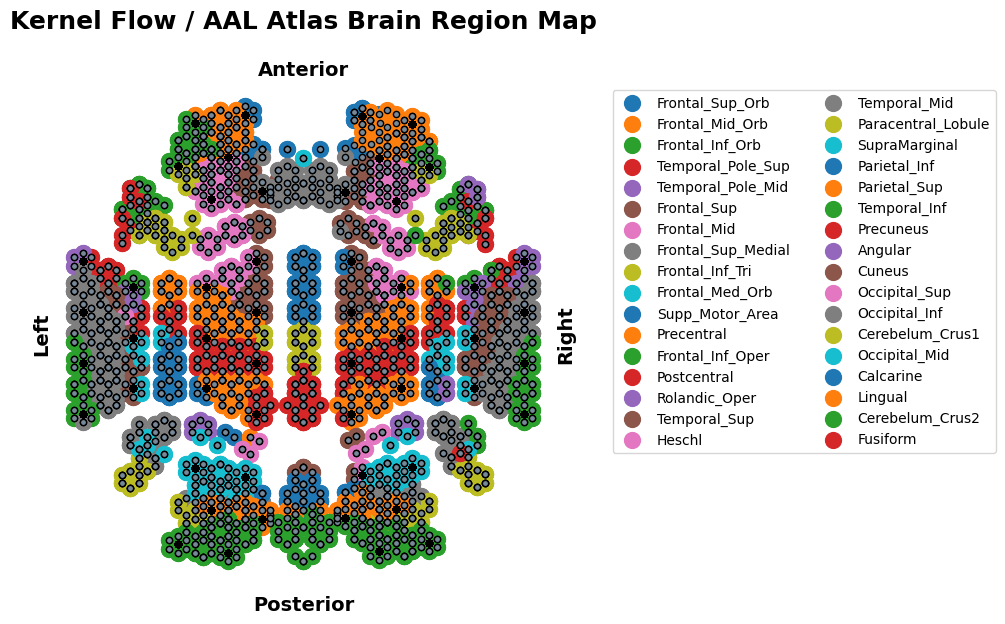

In [137]:
par = Participant_Flow()
FR = Flow_Results()
exp_name = "go_no_go"
hemo_type = "HbO"
filter_type = "lowpass"
FR.plot_brain_region_map()

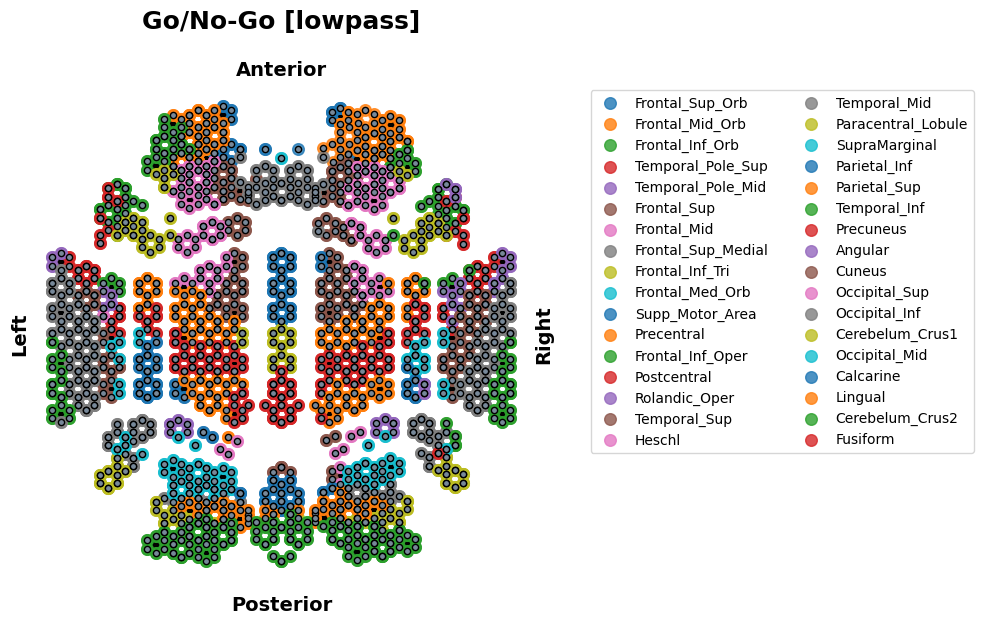

In [72]:
flow_atlas_temp = par.flow.load_flow_atlas(inter_module_only=False)
brain_regions = np.array([region[:-2] for region in flow_atlas_temp["AAL_region"]])
_, idx = np.unique(brain_regions, return_index=True)
unique_brain_regions = brain_regions[np.sort(idx)]

compare_conditions = True
corr = False
add_labels = False
filepath = None
show = True
"""
Plot Kernel Flow statistical results for all channels.

Args:
    exp_name (str): Name of the experiment.
    hemo_type (str): Hemodynamic type. "HbO", "HbR", "HbTot", or "HbDiff".
    filter_type (str): Filter to apply to the data. Defaults to None.
    compare_conditions (bool): Compare responses to increasing task condition difficulty. Defaults to True.
    corr (bool): Apply a Bonferroni correction to the p-values. Defaults to False.
    add_labels (bool): Add a channel number label at each detector position. Defaults to False.
    filepath (str): Filepath to save figure. Default to None (no output).
    show (bool): Display the figure. Defaults to True.
"""


def _add_missing() -> pd.DataFrame:
    """
    Add missing optical module to the plot DataFrame.

    Returns:
        pd.DataFrame: Plot DataFrame with missing optical module.
    """
    missing_df = pd.read_csv(
        os.path.join(FR.par.flow_processed_data_dir, "missing_optical_module.csv")
    )
    temp_df = plot_df_temp.astype(
        {col: "float" for col in plot_df_temp.select_dtypes(include=["bool"]).columns}
    )
    missing_df = missing_df.astype(
        {col: "float" for col in missing_df.select_dtypes(include=["bool"]).columns}
    )
    plot_df = pd.concat([temp_df, missing_df], axis=0, ignore_index=True)
    missing_cols = missing_df[["midpoint_x_pos", "midpoint_y_pos", "AAL_region"]]
    missing_cols = missing_cols.copy()
    missing_cols.rename(
        columns={
            "midpoint_x_pos": "midpoint_x_pos_2D",
            "midpoint_y_pos": "midpoint_y_pos_2D",
        },
        inplace=True,
    )
    flow_atlas = pd.concat([flow_atlas_temp, missing_cols], axis=0, ignore_index=True)
    return plot_df, flow_atlas


flow_stats = FR.load_flow_stats(
    exp_name, hemo_type, filter_type, inter_module_only=False
)
if compare_conditions:
    post_hoc_stats = FR.load_post_hoc_stats(
        exp_name, hemo_type, filter_type, drop=True, inter_module_only=False
    )
    (
        pos_condition_channels,
        neg_condition_channels,
    ) = FR._get_condition_channels(exp_name, post_hoc_stats)
source_detector_df = FR.flow_session.create_source_detector_df(
    "2D", inter_module_only=False
)
plot_df_temp = pd.merge(flow_stats, source_detector_df, on="channel_num")
plot_df, flow_atlas = _add_missing()

fig = plt.figure(figsize=(6.5, 6.5))
ax = fig.add_subplot(111)
if corr:
    sig_detector_plot_df = plot_df[plot_df["is_sig_corr"] == True]
    not_sig_detector_plot_df = plot_df[
        (plot_df["is_sig_corr"] == False) | (pd.isna(plot_df["p_value"]))
    ]
else:
    sig_detector_plot_df = plot_df[plot_df["is_sig"] == True]
    not_sig_detector_plot_df = plot_df[
        (plot_df["is_sig"] == False) | (pd.isna(plot_df["p_value"]))
    ]
# if compare_conditions:
#     pos_sig_detector_plot_df = sig_detector_plot_df[
#         sig_detector_plot_df["channel_num"].isin(pos_condition_channels)
#     ]
#     pos_condition_scatter = ax.scatter(
#         pos_sig_detector_plot_df["midpoint_x_pos"],
#         pos_sig_detector_plot_df["midpoint_y_pos"],
#         s=70,
#         c=pos_sig_detector_plot_df["p_value"],
#         cmap="autumn",
#         edgecolors="black",
#         alpha=1,
#         zorder=3,
#     )
#     neg_sig_detector_plot_df = sig_detector_plot_df[
#         sig_detector_plot_df["channel_num"].isin(neg_condition_channels)
#     ]
#     neg_condition_scatter = ax.scatter(
#         neg_sig_detector_plot_df["midpoint_x_pos"],
#         neg_sig_detector_plot_df["midpoint_y_pos"],
#         s=70,
#         c=neg_sig_detector_plot_df["p_value"],
#         cmap="winter",
#         edgecolors="black",
#         alpha=1,
#         zorder=3,
#     )
# else:
#     scatter = ax.scatter(
#         sig_detector_plot_df["midpoint_x_pos"],
#         sig_detector_plot_df["midpoint_y_pos"],
#         s=70,
#         c=sig_detector_plot_df["p_value"],
#         cmap="autumn",
#         edgecolors="black",
#         alpha=1,
#         zorder=3,
#     )
ax.scatter(
    plot_df["midpoint_x_pos"],
    plot_df["midpoint_y_pos"],
    s=20,
    c="lightslategray",
    edgecolors="black",
    alpha=1,
    zorder=3,
)
ax.scatter(
    plot_df["source_x_pos"],
    plot_df["source_y_pos"],
    s=30,
    c="black",
    zorder=1,
)

for region in unique_brain_regions:
    region_l = region + "_L"
    region_r = region + "_R"
    brain_region_rows_l = flow_atlas[flow_atlas["AAL_region"] == region_l]
    brain_region_rows_r = flow_atlas[flow_atlas["AAL_region"] == region_r]
    brain_region_rows = pd.concat([brain_region_rows_l, brain_region_rows_r], axis=0)

    ax.scatter(
        brain_region_rows["midpoint_x_pos_2D"],
        brain_region_rows["midpoint_y_pos_2D"],
        s=70,
        alpha=0.8,
        # c="lime",
        zorder=2,
        label=region,
    )
if add_labels:
    try:
        labels = [
            plt.text(
                sig_detector_plot_df["midpoint_x_pos"].iloc[i],
                sig_detector_plot_df["midpoint_y_pos"].iloc[i],
                int(sig_detector_plot_df["channel_num"].iloc[i]),
                fontsize=8,
                ha="center",
                va="center",
                bbox=dict(
                    boxstyle="round,pad=0.15",
                    edgecolor="black",
                    facecolor="white",
                    alpha=1,
                ),
                zorder=4,
            )
            for i in range(sig_detector_plot_df.shape[0])
        ]
        adjust_text(
            labels,
            ax=ax,
            arrowprops=dict(
                arrowstyle="-|>",
                facecolor="black",
                linewidth=2,
                shrinkA=0,
                shrinkB=0,
                zorder=0,
            ),
            expand_points=(3, 3),
            expand_text=(2, 2),
            force_points=(0.8, 0.8),
            autoalign=True,
        )
    except IndexError:  # no significant channels to label
        pass
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Anterior", fontweight="bold", fontsize=14, y=1)
ax.text(
    0.5,
    -0.06,
    "Posterior",
    fontweight="bold",
    fontsize=14,
    ha="center",
    va="bottom",
    transform=ax.transAxes,
)
ax.text(
    -0.02,
    0.5,
    "Left",
    fontsize=14,
    fontweight="bold",
    rotation=90,
    va="center",
    ha="center",
    transform=ax.transAxes,
)
ax.text(
    1.02,
    0.5,
    "Right",
    fontsize=14,
    fontweight="bold",
    rotation=90,
    va="center",
    ha="center",
    transform=ax.transAxes,
)
font_props = FontProperties(size=12)
if corr:  # TODO: needs to be implemented
    alpha = round(plot_df["alpha_corr"].iloc[0], 5)
    scatter.set_clim([0, alpha])
    colorbar = plt.colorbar(
        scatter, ticks=np.linspace(0, alpha, 6), shrink=0.7, pad=0.1
    )
    tick_labels = colorbar.get_ticks()
    formatted_tick_labels = [format(tick, ".2e") for tick in tick_labels]
    colorbar.ax.set_yticklabels(formatted_tick_labels)
    colorbar.set_label("Bonferroni-corrected p-value", fontproperties=font_props)
else:
    pass
    # if compare_conditions:
    #     neg_condition_scatter.set_clim([0, 0.05])
    #     neg_colorbar = plt.colorbar(
    #         neg_condition_scatter,
    #         ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05],
    #         shrink=0.6,
    #         pad=0,
    #     )
    #     neg_colorbar.set_label("p-value", fontproperties=font_props)
    #     ax.text(
    #         1.37,
    #         0.12,
    #         "\u2193Δ{}".format(hemo_type),
    #         fontweight="bold",
    #         fontsize=14,
    #         ha="center",
    #         va="bottom",
    #         transform=ax.transAxes,
    #     )
    #     pos_condition_scatter.set_clim([0, 0.05])
    #     pos_colorbar = plt.colorbar(
    #         pos_condition_scatter,
    #         ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05],
    #         shrink=0.6,
    #         pad=0.1,
    #     )
    #     pos_colorbar.set_label("p-value", fontproperties=font_props)
    #     ax.text(
    #         1.17,
    #         0.12,
    #         "\u2191Δ{}".format(hemo_type),
    #         fontweight="bold",
    #         fontsize=14,
    #         ha="center",
    #         va="bottom",
    #         transform=ax.transAxes,
    #     )
    # else:
    #     scatter.set_clim([0, 0.05])
    #     colorbar = plt.colorbar(
    #         scatter,
    #         ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05],
    #         shrink=0.6,
    #         pad=0,
    #     )
    #     colorbar.set_label("p-value", fontproperties=font_props)
try:
    title_text = f"{exp_name_to_title(exp_name)} [{filter_type.lower()}]"
except AttributeError:
    title_text = f"{exp_name_to_title(exp_name)} [unfiltered]"
ax.text(
    0.5,
    1.1,
    title_text,
    fontweight="bold",
    fontsize=18,
    ha="center",
    va="bottom",
    transform=ax.transAxes,
)
plt.legend(bbox_to_anchor=(1.1, 1), loc="upper left", ncol=2)
if show:  # TODO
    plt.show()
if filepath:
    fig.savefig(filepath, dpi=300, bbox_inches="tight")

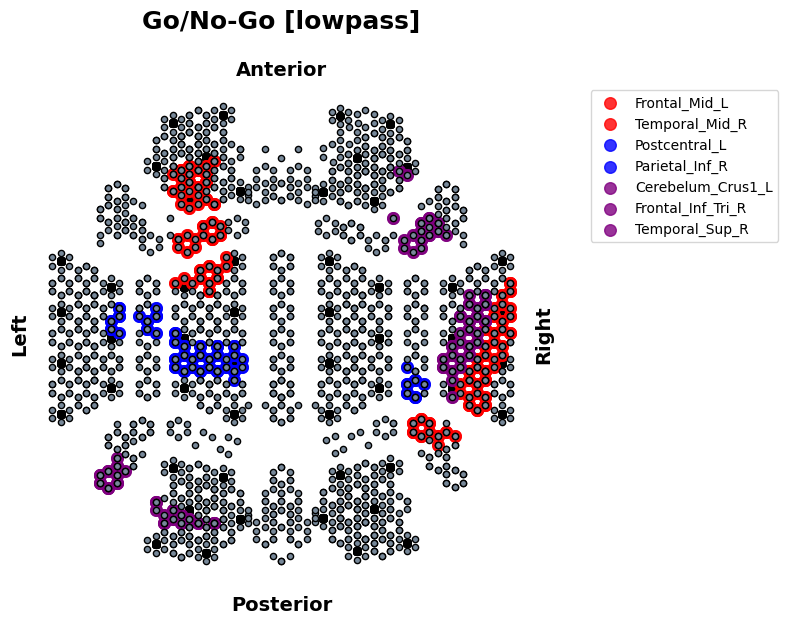

In [73]:
flow_atlas_temp = par.flow.load_flow_atlas(inter_module_only=False)

inc_list = ["Frontal_Mid_L", "Temporal_Mid_R"]
dec_list = ["Postcentral_L", "Parietal_Inf_R"]
both_list = ["Cerebelum_Crus1_L", "Frontal_Inf_Tri_R", "Temporal_Sup_R"]

compare_conditions = True
corr = False
add_labels = False
filepath = None
show = True
"""
Plot Kernel Flow statistical results for all channels.

Args:
    exp_name (str): Name of the experiment.
    hemo_type (str): Hemodynamic type. "HbO", "HbR", "HbTot", or "HbDiff".
    filter_type (str): Filter to apply to the data. Defaults to None.
    compare_conditions (bool): Compare responses to increasing task condition difficulty. Defaults to True.
    corr (bool): Apply a Bonferroni correction to the p-values. Defaults to False.
    add_labels (bool): Add a channel number label at each detector position. Defaults to False.
    filepath (str): Filepath to save figure. Default to None (no output).
    show (bool): Display the figure. Defaults to True.
"""


def _add_missing() -> pd.DataFrame:
    """
    Add missing optical module to the plot DataFrame.

    Returns:
        pd.DataFrame: Plot DataFrame with missing optical module.
    """
    missing_df = pd.read_csv(
        os.path.join(FR.par.flow_processed_data_dir, "missing_optical_module.csv")
    )
    temp_df = plot_df_temp.astype(
        {col: "float" for col in plot_df_temp.select_dtypes(include=["bool"]).columns}
    )
    missing_df = missing_df.astype(
        {col: "float" for col in missing_df.select_dtypes(include=["bool"]).columns}
    )
    plot_df = pd.concat([temp_df, missing_df], axis=0, ignore_index=True)
    missing_cols = missing_df[["midpoint_x_pos", "midpoint_y_pos", "AAL_region"]]
    missing_cols = missing_cols.copy()
    missing_cols.rename(
        columns={
            "midpoint_x_pos": "midpoint_x_pos_2D",
            "midpoint_y_pos": "midpoint_y_pos_2D",
        },
        inplace=True,
    )
    flow_atlas = pd.concat([flow_atlas_temp, missing_cols], axis=0, ignore_index=True)
    return plot_df, flow_atlas


flow_atlas = par.flow.load_flow_atlas(inter_module_only=False)
flow_stats = FR.load_flow_stats(
    exp_name, hemo_type, filter_type, inter_module_only=False
)
if compare_conditions:
    post_hoc_stats = FR.load_post_hoc_stats(
        exp_name, hemo_type, filter_type, drop=True, inter_module_only=False
    )
    (
        pos_condition_channels,
        neg_condition_channels,
    ) = FR._get_condition_channels(exp_name, post_hoc_stats)
source_detector_df = FR.flow_session.create_source_detector_df(
    "2D", inter_module_only=False
)
plot_df_temp = pd.merge(flow_stats, source_detector_df, on="channel_num")
plot_df, flow_atlas = _add_missing()

fig = plt.figure(figsize=(6.5, 6.5))
ax = fig.add_subplot(111)
if corr:
    sig_detector_plot_df = plot_df[plot_df["is_sig_corr"] == True]
    not_sig_detector_plot_df = plot_df[
        (plot_df["is_sig_corr"] == False) | (pd.isna(plot_df["p_value"]))
    ]
else:
    sig_detector_plot_df = plot_df[plot_df["is_sig"] == True]
    not_sig_detector_plot_df = plot_df[
        (plot_df["is_sig"] == False) | (pd.isna(plot_df["p_value"]))
    ]

ax.scatter(
    plot_df["midpoint_x_pos"],
    plot_df["midpoint_y_pos"],
    s=20,
    c="lightslategray",
    edgecolors="black",
    alpha=1,
    zorder=3,
)
ax.scatter(
    plot_df["source_x_pos"],
    plot_df["source_y_pos"],
    s=30,
    c="black",
    zorder=1,
)

for inc_region in inc_list:
    brain_region_rows = flow_atlas[flow_atlas["AAL_region"] == inc_region]
    ax.scatter(
        brain_region_rows["midpoint_x_pos_2D"],
        brain_region_rows["midpoint_y_pos_2D"],
        s=70,
        alpha=0.8,
        c="red",
        zorder=2,
        label=inc_region,
    )
for dec_region in dec_list:
    brain_region_rows = flow_atlas[flow_atlas["AAL_region"] == dec_region]
    ax.scatter(
        brain_region_rows["midpoint_x_pos_2D"],
        brain_region_rows["midpoint_y_pos_2D"],
        s=70,
        alpha=0.8,
        c="blue",
        zorder=2,
        label=dec_region,
    )
for both_region in both_list:
    brain_region_rows = flow_atlas[flow_atlas["AAL_region"] == both_region]
    ax.scatter(
        brain_region_rows["midpoint_x_pos_2D"],
        brain_region_rows["midpoint_y_pos_2D"],
        s=70,
        alpha=0.8,
        c="purple",
        zorder=2,
        label=both_region,
    )
if add_labels:
    try:
        labels = [
            plt.text(
                sig_detector_plot_df["midpoint_x_pos"].iloc[i],
                sig_detector_plot_df["midpoint_y_pos"].iloc[i],
                int(sig_detector_plot_df["channel_num"].iloc[i]),
                fontsize=8,
                ha="center",
                va="center",
                bbox=dict(
                    boxstyle="round,pad=0.15",
                    edgecolor="black",
                    facecolor="white",
                    alpha=1,
                ),
                zorder=4,
            )
            for i in range(sig_detector_plot_df.shape[0])
        ]
        adjust_text(
            labels,
            ax=ax,
            arrowprops=dict(
                arrowstyle="-|>",
                facecolor="black",
                linewidth=2,
                shrinkA=0,
                shrinkB=0,
                zorder=0,
            ),
            expand_points=(3, 3),
            expand_text=(2, 2),
            force_points=(0.8, 0.8),
            autoalign=True,
        )
    except IndexError:  # no significant channels to label
        pass
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Anterior", fontweight="bold", fontsize=14, y=1)
ax.text(
    0.5,
    -0.06,
    "Posterior",
    fontweight="bold",
    fontsize=14,
    ha="center",
    va="bottom",
    transform=ax.transAxes,
)
ax.text(
    -0.02,
    0.5,
    "Left",
    fontsize=14,
    fontweight="bold",
    rotation=90,
    va="center",
    ha="center",
    transform=ax.transAxes,
)
ax.text(
    1.02,
    0.5,
    "Right",
    fontsize=14,
    fontweight="bold",
    rotation=90,
    va="center",
    ha="center",
    transform=ax.transAxes,
)
font_props = FontProperties(size=12)
if corr:  # TODO: needs to be implemented
    alpha = round(plot_df["alpha_corr"].iloc[0], 5)
    scatter.set_clim([0, alpha])
    colorbar = plt.colorbar(
        scatter, ticks=np.linspace(0, alpha, 6), shrink=0.7, pad=0.1
    )
    tick_labels = colorbar.get_ticks()
    formatted_tick_labels = [format(tick, ".2e") for tick in tick_labels]
    colorbar.ax.set_yticklabels(formatted_tick_labels)
    colorbar.set_label("Bonferroni-corrected p-value", fontproperties=font_props)
else:
    pass

try:
    title_text = f"{exp_name_to_title(exp_name)} [{filter_type.lower()}]"
except AttributeError:
    title_text = f"{exp_name_to_title(exp_name)} [unfiltered]"
ax.text(
    0.5,
    1.1,
    title_text,
    fontweight="bold",
    fontsize=18,
    ha="center",
    va="bottom",
    transform=ax.transAxes,
)
plt.legend(bbox_to_anchor=(1.1, 1), loc="upper left")
if show:  # TODO
    plt.show()
if filepath:
    fig.savefig(filepath, dpi=300, bbox_inches="tight")

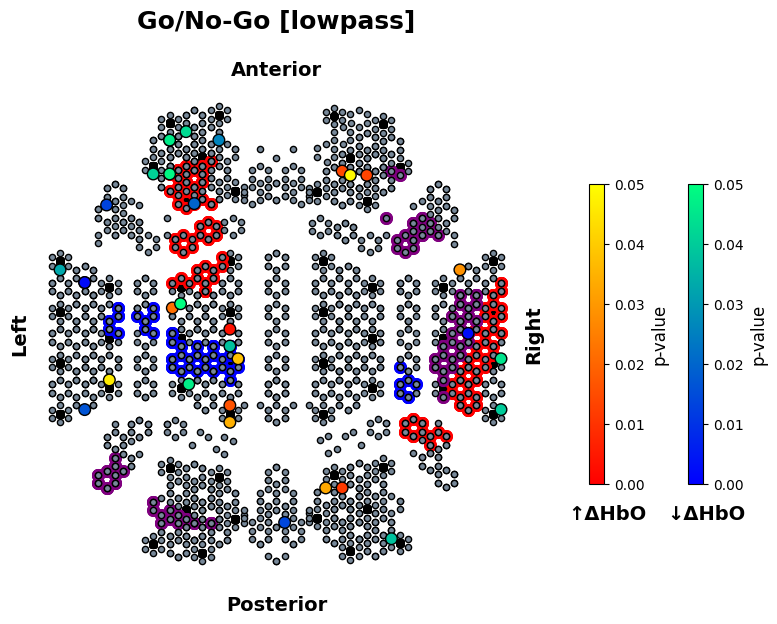

In [82]:
flow_atlas_temp = par.flow.load_flow_atlas(inter_module_only=False)

inc_list = ["Frontal_Mid_L", "Temporal_Mid_R"]
dec_list = ["Postcentral_L", "Parietal_Inf_R"]
both_list = ["Cerebelum_Crus1_L", "Frontal_Inf_Tri_R", "Temporal_Sup_R"]

compare_conditions = True
corr = False
add_labels = False
filepath = None
show = True
"""
Plot Kernel Flow statistical results for all channels.

Args:
    exp_name (str): Name of the experiment.
    hemo_type (str): Hemodynamic type. "HbO", "HbR", "HbTot", or "HbDiff".
    filter_type (str): Filter to apply to the data. Defaults to None.
    compare_conditions (bool): Compare responses to increasing task condition difficulty. Defaults to True.
    corr (bool): Apply a Bonferroni correction to the p-values. Defaults to False.
    add_labels (bool): Add a channel number label at each detector position. Defaults to False.
    filepath (str): Filepath to save figure. Default to None (no output).
    show (bool): Display the figure. Defaults to True.
"""


def _add_missing() -> pd.DataFrame:
    """
    Add missing optical module to the plot DataFrame.

    Returns:
        pd.DataFrame: Plot DataFrame with missing optical module.
    """
    missing_df = pd.read_csv(
        os.path.join(FR.par.flow_processed_data_dir, "missing_optical_module.csv")
    )
    temp_df = plot_df_temp.astype(
        {col: "float" for col in plot_df_temp.select_dtypes(include=["bool"]).columns}
    )
    missing_df = missing_df.astype(
        {col: "float" for col in missing_df.select_dtypes(include=["bool"]).columns}
    )
    plot_df = pd.concat([temp_df, missing_df], axis=0, ignore_index=True)
    missing_cols = missing_df[["midpoint_x_pos", "midpoint_y_pos", "AAL_region"]]
    missing_cols = missing_cols.copy()
    missing_cols.rename(
        columns={
            "midpoint_x_pos": "midpoint_x_pos_2D",
            "midpoint_y_pos": "midpoint_y_pos_2D",
        },
        inplace=True,
    )
    flow_atlas = pd.concat([flow_atlas_temp, missing_cols], axis=0, ignore_index=True)
    return plot_df, flow_atlas


flow_atlas = par.flow.load_flow_atlas(inter_module_only=False)
flow_stats = FR.load_flow_stats(
    exp_name, hemo_type, filter_type, inter_module_only=False
)
if compare_conditions:
    post_hoc_stats = FR.load_post_hoc_stats(
        exp_name, hemo_type, filter_type, drop=True, inter_module_only=False
    )
    (
        pos_condition_channels,
        neg_condition_channels,
    ) = FR._get_condition_channels(exp_name, post_hoc_stats)
source_detector_df = FR.flow_session.create_source_detector_df(
    "2D", inter_module_only=False
)
plot_df_temp = pd.merge(flow_stats, source_detector_df, on="channel_num")
plot_df, flow_atlas = _add_missing()

fig = plt.figure(figsize=(10, 6.5))
ax = fig.add_subplot(111)
if corr:
    sig_detector_plot_df = plot_df[plot_df["is_sig_corr"] == True]
    not_sig_detector_plot_df = plot_df[
        (plot_df["is_sig_corr"] == False) | (pd.isna(plot_df["p_value"]))
    ]
else:
    sig_detector_plot_df = plot_df[plot_df["is_sig"] == True]
    not_sig_detector_plot_df = plot_df[
        (plot_df["is_sig"] == False) | (pd.isna(plot_df["p_value"]))
    ]
if compare_conditions:
    pos_sig_detector_plot_df = sig_detector_plot_df[
        sig_detector_plot_df["channel_num"].isin(pos_condition_channels)
    ]
    pos_condition_scatter = ax.scatter(
        pos_sig_detector_plot_df["midpoint_x_pos"],
        pos_sig_detector_plot_df["midpoint_y_pos"],
        s=70,
        c=pos_sig_detector_plot_df["p_value"],
        cmap="autumn",
        edgecolors="black",
        alpha=1,
        zorder=4,
    )
    neg_sig_detector_plot_df = sig_detector_plot_df[
        sig_detector_plot_df["channel_num"].isin(neg_condition_channels)
    ]
    neg_condition_scatter = ax.scatter(
        neg_sig_detector_plot_df["midpoint_x_pos"],
        neg_sig_detector_plot_df["midpoint_y_pos"],
        s=70,
        c=neg_sig_detector_plot_df["p_value"],
        cmap="winter",
        edgecolors="black",
        alpha=1,
        zorder=4,
    )
else:
    scatter = ax.scatter(
        sig_detector_plot_df["midpoint_x_pos"],
        sig_detector_plot_df["midpoint_y_pos"],
        s=70,
        c=sig_detector_plot_df["p_value"],
        cmap="autumn",
        edgecolors="black",
        alpha=1,
        zorder=4,
    )

ax.scatter(
    plot_df["midpoint_x_pos"],
    plot_df["midpoint_y_pos"],
    s=20,
    c="lightslategray",
    edgecolors="black",
    alpha=1,
    zorder=3,
)
ax.scatter(
    plot_df["source_x_pos"],
    plot_df["source_y_pos"],
    s=30,
    c="black",
    zorder=1,
)

for inc_region in inc_list:
    brain_region_rows = flow_atlas[flow_atlas["AAL_region"] == inc_region]
    ax.scatter(
        brain_region_rows["midpoint_x_pos_2D"],
        brain_region_rows["midpoint_y_pos_2D"],
        s=70,
        alpha=1,
        c="red",
        zorder=2,
        label=inc_region,
    )
for dec_region in dec_list:
    brain_region_rows = flow_atlas[flow_atlas["AAL_region"] == dec_region]
    ax.scatter(
        brain_region_rows["midpoint_x_pos_2D"],
        brain_region_rows["midpoint_y_pos_2D"],
        s=70,
        alpha=1,
        c="blue",
        zorder=2,
        label=dec_region,
    )
for both_region in both_list:
    brain_region_rows = flow_atlas[flow_atlas["AAL_region"] == both_region]
    ax.scatter(
        brain_region_rows["midpoint_x_pos_2D"],
        brain_region_rows["midpoint_y_pos_2D"],
        s=70,
        alpha=1,
        c="purple",
        zorder=2,
        label=both_region,
    )
if add_labels:
    try:
        labels = [
            plt.text(
                sig_detector_plot_df["midpoint_x_pos"].iloc[i],
                sig_detector_plot_df["midpoint_y_pos"].iloc[i],
                int(sig_detector_plot_df["channel_num"].iloc[i]),
                fontsize=8,
                ha="center",
                va="center",
                bbox=dict(
                    boxstyle="round,pad=0.15",
                    edgecolor="black",
                    facecolor="white",
                    alpha=1,
                ),
                zorder=4,
            )
            for i in range(sig_detector_plot_df.shape[0])
        ]
        adjust_text(
            labels,
            ax=ax,
            arrowprops=dict(
                arrowstyle="-|>",
                facecolor="black",
                linewidth=2,
                shrinkA=0,
                shrinkB=0,
                zorder=0,
            ),
            expand_points=(3, 3),
            expand_text=(2, 2),
            force_points=(0.8, 0.8),
            autoalign=True,
        )
    except IndexError:  # no significant channels to label
        pass
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Anterior", fontweight="bold", fontsize=14, y=1)
ax.text(
    0.5,
    -0.06,
    "Posterior",
    fontweight="bold",
    fontsize=14,
    ha="center",
    va="bottom",
    transform=ax.transAxes,
)
ax.text(
    -0.02,
    0.5,
    "Left",
    fontsize=14,
    fontweight="bold",
    rotation=90,
    va="center",
    ha="center",
    transform=ax.transAxes,
)
ax.text(
    1.02,
    0.5,
    "Right",
    fontsize=14,
    fontweight="bold",
    rotation=90,
    va="center",
    ha="center",
    transform=ax.transAxes,
)
font_props = FontProperties(size=12)
if corr:  # TODO: needs to be implemented
    alpha = round(plot_df["alpha_corr"].iloc[0], 5)
    scatter.set_clim([0, alpha])
    colorbar = plt.colorbar(
        scatter, ticks=np.linspace(0, alpha, 6), shrink=0.7, pad=0.1
    )
    tick_labels = colorbar.get_ticks()
    formatted_tick_labels = [format(tick, ".2e") for tick in tick_labels]
    colorbar.ax.set_yticklabels(formatted_tick_labels)
    colorbar.set_label("Bonferroni-corrected p-value", fontproperties=font_props)
else:
    pass
    if compare_conditions:
        neg_condition_scatter.set_clim([0, 0.05])
        neg_colorbar = plt.colorbar(
            neg_condition_scatter,
            ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05],
            shrink=0.6,
            pad=0,
        )
        neg_colorbar.set_label("p-value", fontproperties=font_props)
        ax.text(
            1.37,
            0.12,
            "\u2193Δ{}".format(hemo_type),
            fontweight="bold",
            fontsize=14,
            ha="center",
            va="bottom",
            transform=ax.transAxes,
        )
        pos_condition_scatter.set_clim([0, 0.05])
        pos_colorbar = plt.colorbar(
            pos_condition_scatter,
            ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05],
            shrink=0.6,
            pad=0.1,
        )
        pos_colorbar.set_label("p-value", fontproperties=font_props)
        ax.text(
            1.17,
            0.12,
            "\u2191Δ{}".format(hemo_type),
            fontweight="bold",
            fontsize=14,
            ha="center",
            va="bottom",
            transform=ax.transAxes,
        )
    else:
        scatter.set_clim([0, 0.05])
        colorbar = plt.colorbar(
            scatter,
            ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05],
            shrink=0.6,
            pad=0,
        )
        colorbar.set_label("p-value", fontproperties=font_props)

try:
    title_text = f"{exp_name_to_title(exp_name)} [{filter_type.lower()}]"
except AttributeError:
    title_text = f"{exp_name_to_title(exp_name)} [unfiltered]"
ax.text(
    0.5,
    1.1,
    title_text,
    fontweight="bold",
    fontsize=18,
    ha="center",
    va="bottom",
    transform=ax.transAxes,
)
# plt.legend(bbox_to_anchor=(1.1, 1), loc="upper left")
if show:  # TODO
    plt.show()
if filepath:
    fig.savefig(filepath, dpi=300, bbox_inches="tight")

In [6]:
brain_region_dict = load_brain_region_name_scheme()
brain_region_dict

{'Angular_L': 'Left Angular Gyrus',
 'Angular_R': 'Right Angular Gyrus',
 'Calcarine_L': 'Left Calcarine Fissure',
 'Cerebelum_Crus1_L': 'Left Cerebellum Crus 1',
 'Cerebelum_Crus1_R': 'Right Cerebellum Crus 1',
 'Cerebelum_Crus2_L': 'Left Cerebellum Crus 2',
 'Cerebelum_Crus2_R': 'Right Cerebellum Crus 2',
 'Cuneus_L': 'Left Cuneus',
 'Cuneus_R': 'Right Cuneus',
 'Frontal_Inf_Oper_L': 'Left Inferior Frontal Gyrus, Opercular Part',
 'Frontal_Inf_Oper_R': 'Right Inferior Frontal Gyrus, Opercular Part',
 'Frontal_Inf_Orb_L': 'Left Inferior Frontal Gyrus, Orbital Part',
 'Frontal_Inf_Orb_R': 'Right Inferior Frontal Gyrus, Orbital Part',
 'Frontal_Inf_Tri_L': 'Left Inferior Frontal Gyrus, Triangular Part',
 'Frontal_Inf_Tri_R': 'Right Inferior Frontal Gyrus, Triangular Part',
 'Frontal_Med_Orb_L': 'Left Medial Frontal Gyrus, Orbital Part',
 'Frontal_Med_Orb_R': 'Right Medial Frontal Gyrus, Orbital Part',
 'Frontal_Mid_L': 'Left Middle Frontal Gyrus',
 'Frontal_Mid_R': 'Right Middle Frontal

In [2]:
par = Participant_Flow()
exp_name = "video_narrative_sherlock"

In [3]:
samp_freq = 7.13862  # Kernel Flow sampling frequency (approx.)


def replace_col(col: pd.Series, threshold: int) -> pd.Series:
    """
    Replace all column values with NaN if any value exceeds the threshold.

    Args:
        col (pd.Series): DataFrame column.
        threshold (int): Plus/minus threshold value.

    Returns:
        pd.Series: DataFrame column.
    """
    if (col > threshold).any() or (col < -threshold).any():
        return [np.nan] * len(col)
    else:
        return col

In [27]:
par_num = 1
par = Participant_Flow(par_num)
flow_exp = par.load_flow_exp(exp_name, filter_type="lowpass")
exp_by_block = par.par_behav.by_block_ts_dict[exp_name]
flow_start_idx = flow_exp.index[0]
ts_list = flow_exp["datetime"].apply(lambda x: datetime.datetime.timestamp(x)).tolist()
block_start_ts, block_end_ts = next(iter(exp_by_block.keys()))
block_start_idx, _ = par.data_fun.find_closest_ts(
    block_start_ts, ts_list, flow_start_idx
)
block_end_idx, _ = par.data_fun.find_closest_ts(block_end_ts, ts_list, flow_start_idx)
block_rows = flow_exp.loc[
    block_start_idx:block_end_idx, 0:
]  # rows from narrative start to end
block_rows = block_rows.apply(
    replace_col, args=(9,)
)  # remove channels outside of normal range

baseline_rows = flow_exp.loc[
    block_start_idx : block_start_idx + floor(samp_freq * 5), 0:
]  # first 5 seconds of the narrative
baseline = pd.DataFrame(baseline_rows.mean()).T
baseline_df = pd.concat([baseline] * block_rows.shape[0], ignore_index=True)
baseline_df = baseline_df.set_index(
    pd.Index(range(block_start_idx, block_start_idx + len(baseline_df)))
)

block_rows_norm = block_rows.subtract(baseline_df)  # normalize the narrative rows

# remove the first and last 15 seconds
block_rows_norm_trunc = block_rows_norm.iloc[
    floor(samp_freq * 15) : -floor(samp_freq * 15)
]

In [28]:
test = block_rows_norm_trunc[312]
test

8194    NaN
8195    NaN
8196    NaN
8197    NaN
8198    NaN
         ..
10117   NaN
10118   NaN
10119   NaN
10120   NaN
10121   NaN
Name: 312, Length: 1928, dtype: float64

In [25]:
block_rows[312]

8087    NaN
8088    NaN
8089    NaN
8090    NaN
8091    NaN
         ..
10224   NaN
10225   NaN
10226   NaN
10227   NaN
10228   NaN
Name: 312, Length: 2142, dtype: float64

In [26]:
block_rows_norm[312]

8087    -6.151507
8088    -6.151507
8089    -6.151507
8090    -6.151507
8091    -6.151507
           ...   
10224   -6.151507
10225   -6.151507
10226   -6.151507
10227   -6.151507
10228   -6.151507
Name: 312, Length: 2142, dtype: float64

In [29]:
flow_exp_dict = {}
num_pars = 15
for par_num in range(1, num_pars + 1):
    par = Participant_Flow(par_num)
    flow_exp = par.load_flow_exp(exp_name, filter_type="lowpass")
    exp_by_block = par.par_behav.by_block_ts_dict[exp_name]
    flow_start_idx = flow_exp.index[0]
    ts_list = (
        flow_exp["datetime"].apply(lambda x: datetime.datetime.timestamp(x)).tolist()
    )
    block_start_ts, block_end_ts = next(iter(exp_by_block.keys()))
    block_start_idx, _ = par.data_fun.find_closest_ts(
        block_start_ts, ts_list, flow_start_idx
    )
    block_end_idx, _ = par.data_fun.find_closest_ts(
        block_end_ts, ts_list, flow_start_idx
    )
    block_rows = flow_exp.loc[
        block_start_idx:block_end_idx, 0:
    ]  # rows from narrative start to end
    block_rows = block_rows.apply(
        replace_col, args=(9,)
    )  # remove channels outside of normal range

    baseline_rows = flow_exp.loc[
        block_start_idx : block_start_idx + floor(samp_freq * 5), 0:
    ]  # first 5 seconds of the narrative
    baseline = pd.DataFrame(baseline_rows.mean()).T
    baseline_df = pd.concat([baseline] * block_rows.shape[0], ignore_index=True)
    baseline_df = baseline_df.set_index(
        pd.Index(range(block_start_idx, block_start_idx + len(baseline_df)))
    )

    block_rows_norm = block_rows.subtract(baseline_df)  # normalize the narrative rows

    # remove the first and last 15 seconds
    block_rows_norm_trunc = block_rows_norm.iloc[
        floor(samp_freq * 15) : -floor(samp_freq * 15)
    ]
    flow_exp_dict[par_num] = block_rows_norm_trunc.reset_index(drop=True)
    # keys: participant numbers, values: Kernel Flow DataFrames (all channels) for the experiment

min_rows = min(df.shape[0] for df in flow_exp_dict.values())  # min number of rows
flow_exp_dict_trunc = {
    par_num: df.iloc[:min_rows] for par_num, df in flow_exp_dict.items()
}  # truncate to min number of rows

flow_exp_dict_avg = {}
for current_par_num in flow_exp_dict_trunc.keys():
    dfs_to_avg = [
        df.loc[:, 0:]
        for par_num, df in flow_exp_dict_trunc.items()
        if par_num != current_par_num
    ]  # list of dfs excluding the df for the current par
    df_avg = (
        pd.concat(dfs_to_avg).groupby(level=0).mean()
    )  # mean of all Kernel Flow DataFrames excluding the current participant
    flow_exp_dict_avg[current_par_num] = df_avg
    # keys: participant numbers, values: Averaged Kernel Flow DataFrames (all channels) for the experiment

In [8]:
flow_exp_dict_trunc[1][312]

0      -6.151507
1      -6.151507
2      -6.151507
3      -6.151507
4      -6.151507
          ...   
1923   -6.151507
1924   -6.151507
1925   -6.151507
1926   -6.151507
1927   -6.151507
Name: 312, Length: 1928, dtype: float64

In [9]:
flow_exp_dict_trunc[5][312]

0       0.641074
1       0.641074
2       0.641074
3       0.641074
4       0.641074
          ...   
1923    0.641074
1924    0.641074
1925    0.641074
1926    0.641074
1927    0.641074
Name: 312, Length: 1928, dtype: float64

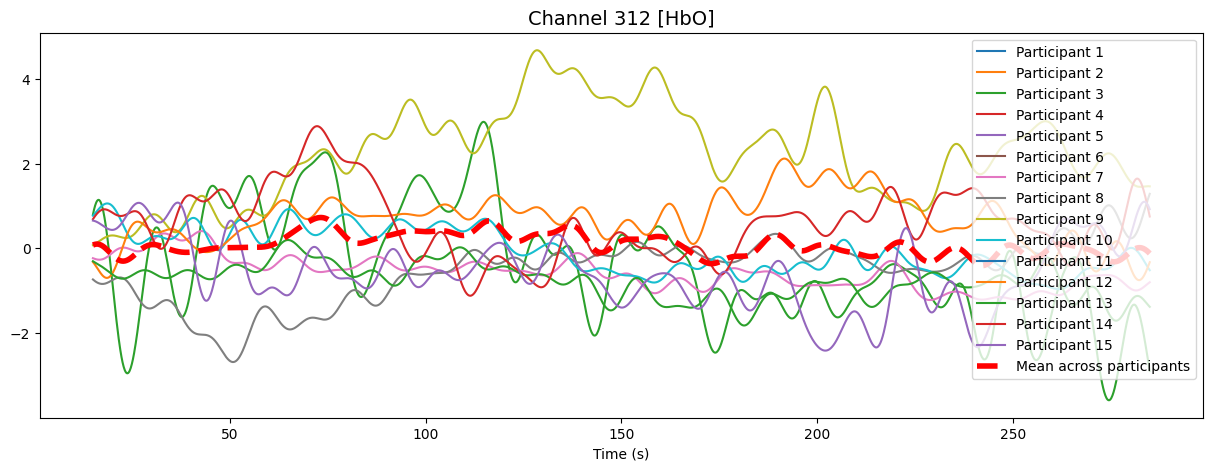

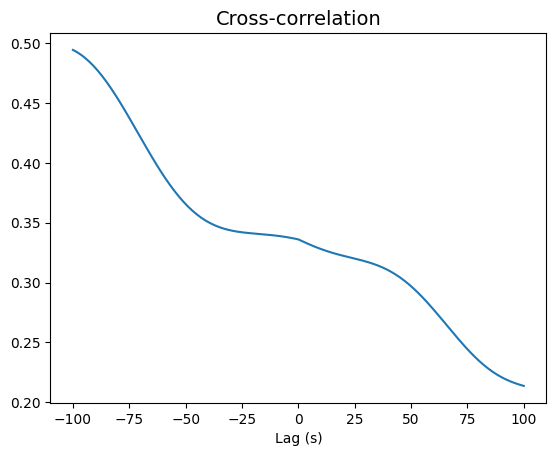

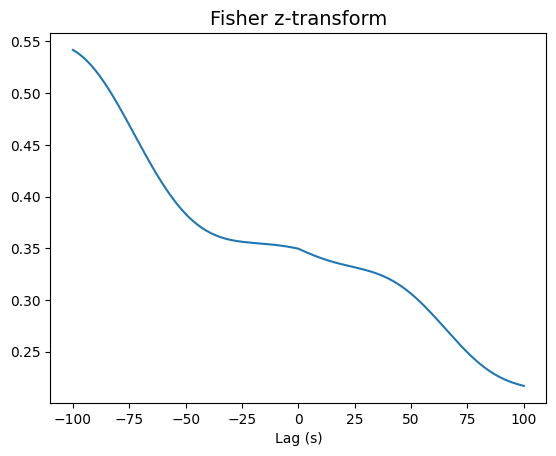

In [43]:
def xcorr(x: pd.Series, y: pd.Series) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform a cross-correlation on normalized x and y vectors.
    x (pd.Series): 1st signal
    y (pd.Series): 2nd signal

    Returns:
        lags (np.ndarray): lags of correlation
        corr (np.ndarray): coefficients of correlation
    """
    norm_x = np.linalg.norm(x)
    x = x / norm_x
    norm_y = np.linalg.norm(y)
    y = y / norm_y
    corr = correlate(x, y, mode="full")
    lags = correlation_lags(len(x), len(y), mode="full")
    return lags, corr


par_num = 10
channel_num = 312
par_channel = flow_exp_dict_trunc[par_num][channel_num][0:min_rows]
all_pars_channel = flow_exp_dict_avg[par_num][channel_num]

lags, corr = xcorr(par_channel, all_pars_channel)
lag = 100
min_lag_idx = np.where(lags == -100)[0][0]
max_lag_idx = np.where(lags == 100)[0][0] + 1
lags_window = lags[min_lag_idx:max_lag_idx]
corr_window = corr[min_lag_idx:max_lag_idx]

z_transform = np.arctanh(corr)  # Fisher z transform
z_transform_window = z_transform[min_lag_idx:max_lag_idx]

fig, ax = plt.subplots(figsize=[15, 5])
t = list(range(len(flow_exp_dict_trunc[1])))
t = [num / samp_freq + 15 for num in t]
for par_num in range(1, num_pars + 1):
    par_channel = flow_exp_dict_trunc[par_num][channel_num][0:min_rows]
    ax.plot(t, par_channel, label=f"Participant {par_num}")
ax.plot(
    t,
    all_pars_channel,
    label="Mean across participants",
    lw=4,
    linestyle="dashed",
    c="red",
)
if channel_num % 2 == 0:
    hemo_type = "HbO"
else:
    hemo_type = "HbR"
ax.set_title(f"Channel {channel_num} [{hemo_type}]", fontsize=14)
ax.set_xlabel("Time (s)")
ax.legend()

fig, ax = plt.subplots()
plt.plot(lags_window, corr_window)
ax.set_title("Cross-correlation", fontsize=14)
ax.set_xlabel("Lag (s)")

fig, ax = plt.subplots()
plt.plot(lags_window, z_transform_window)
ax.set_title("Fisher z-transform", fontsize=14)
ax.set_xlabel("Lag (s)")
plt.show()

In [31]:
num_pars = 15
num_channels = flow_exp_dict[par_num].shape[1] - 1
z_transform_df_list = []
for par_num in range(1, num_pars + 1):
    z_transform_dict = {}
    for channel_num in range(num_channels):
        par_channel = flow_exp_dict[par_num][channel_num][0:min_rows]
        all_pars_channel = flow_exp_dict_avg[par_num][channel_num]
        lags, corr = xcorr(par_channel, all_pars_channel)
        z_transform = np.arctanh(corr)  # Fisher z transform
        z_transform_dict[channel_num] = z_transform
    z_transform_df = pd.DataFrame(z_transform_dict)
    z_transform_df.insert(0, "participant", par_num)
    z_transform_df_list.append(z_transform_df)
z_transform_df = pd.concat(z_transform_df_list, axis=0)
z_transform_df

,participant,0,1,2,3,4,5,6,7,8,...,4281,4282,4283,4284,4285,4286,4287,4288,4289,4290
0,1,0.000027,-0.000037,6.764448e-07,0.000050,0.000004,0.000053,-0.000039,-0.000043,0.000038,...,-0.000035,-0.000192,-0.000064,0.000106,0.000500,-1.237289e-06,0.000041,-0.000007,-0.000112,0.000119
1,1,0.000056,-0.000068,1.639433e-06,0.000099,0.000008,0.000109,-0.000078,-0.000083,0.000078,...,-0.000072,-0.000390,-0.000130,0.000208,0.000991,-1.851737e-06,0.000085,-0.000014,-0.000232,0.000240
2,1,0.000089,-0.000093,2.926660e-06,0.000148,0.000011,0.000169,-0.000116,-0.000120,0.000119,...,-0.000110,-0.000594,-0.000197,0.000307,0.001472,-1.809441e-06,0.000131,-0.000022,-0.000360,0.000363
3,1,0.000124,-0.000112,4.578370e-06,0.000196,0.000013,0.000233,-0.000155,-0.000154,0.000161,...,-0.000150,-0.000803,-0.000267,0.000402,0.001944,-1.082282e-06,0.000180,-0.000029,-0.000497,0.000486
4,1,0.000162,-0.000125,6.637326e-06,0.000243,0.000015,0.000300,-0.000193,-0.000186,0.000204,...,-0.000190,-0.001017,-0.000339,0.000494,0.002406,3.517791e-07,0.000232,-0.000038,-0.000640,0.000611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3850,15,0.000051,-0.000392,3.171596e-04,-0.000864,-0.000641,-0.001691,0.000047,0.000565,0.003520,...,-0.000124,-0.000287,-0.002289,0.002146,0.002541,-4.717112e-04,-0.000109,0.001955,0.000130,0.004925
3851,15,0.000038,-0.000329,2.548246e-04,-0.000674,-0.000510,-0.001358,0.000037,0.000437,0.002791,...,-0.000085,-0.000225,-0.001835,0.001712,0.001994,-3.790441e-04,-0.000090,0.001595,0.000103,0.003908
3852,15,0.000026,-0.000258,1.916896e-04,-0.000493,-0.000380,-0.001023,0.000027,0.000317,0.002074,...,-0.000053,-0.000164,-0.001378,0.001280,0.001466,-2.853527e-04,-0.000071,0.001220,0.000077,0.002906
3853,15,0.000015,-0.000179,1.280057e-04,-0.000321,-0.000251,-0.000686,0.000018,0.000203,0.001370,...,-0.000028,-0.000106,-0.000919,0.000851,0.000957,-1.908172e-04,-0.000050,0.000829,0.000051,0.001921


In [32]:
channel_num = 1
window_size = 200
half_window_size = window_size // 2
window_array = np.arange(-half_window_size, half_window_size + 1)
num_rows_per_par = int(z_transform_df.shape[0] / num_pars)
t_0 = num_rows_per_par // 2
time_point_array = window_array + t_0
time_point = time_point_array[half_window_size]  # example: t = 0 s
time_point_rows = np.arange(time_point, z_transform_df.shape[0], num_rows_per_par)
# z-transform values for a channel across all participants at a specified time point
time_point_z_values = z_transform_df[channel_num].iloc[time_point_rows].to_list()

results_dict = {}
for channel_num in range(num_channels):
    # z-transform values for a channel across all participants at a specified time point
    time_point_z_values = z_transform_df[channel_num].iloc[time_point_rows].to_list()
    t_stat, p_two_sided = ttest_1samp(
        time_point_z_values, 0
    )  # perform one-sample t-test
    # convert to one-sided p-value
    if t_stat > 0:
        p_one_sided = p_two_sided / 2
    else:
        p_one_sided = 1 - p_two_sided / 2
    time_point_out = time_point - num_rows_per_par // 2
    results_dict[channel_num] = {
        "time_point": time_point_out,
        "t_stat": t_stat,
        "p_value": p_one_sided,
    }

results_df = pd.DataFrame.from_dict(results_dict, orient="index")
results_df = results_df.reset_index()
results_df = results_df.rename(columns={"index": "column"})
results_df

,column,time_point,t_stat,p_value
0,0,0,NaN,NaN
1,1,0,-1.652290,0.939641
2,2,0,NaN,NaN
3,3,0,1.195162,0.125939
4,4,0,NaN,NaN
...,...,...,...,...
4286,4286,0,NaN,NaN
4287,4287,0,NaN,NaN
4288,4288,0,NaN,NaN
4289,4289,0,NaN,NaN


In [33]:
results_df_list = []
for time_point in time_point_array:
    time_point_rows = np.arange(time_point, z_transform_df.shape[0], num_rows_per_par)
    # z-transform values for a channel across all participants at a specified time point
    time_point_z_values = z_transform_df[channel_num].iloc[time_point_rows].to_list()
    results_dict = {}
    for channel_num in range(num_channels):
        # z-transform values for a channel across all participants at a specified time point
        time_point_z_values = (
            z_transform_df[channel_num].iloc[time_point_rows].to_list()
        )
        t_stat, p_two_sided = ttest_1samp(
            time_point_z_values, 0
        )  # perform one-sample t-test
        # convert to one-sided p-value
        if t_stat > 0:
            p_one_sided = p_two_sided / 2
        else:
            p_one_sided = 1 - p_two_sided / 2
        time_point_out = time_point - num_rows_per_par // 2
        results_dict[channel_num] = {
            "time_point": time_point_out,
            "t_stat": t_stat,
            "p_value": p_one_sided,
        }

    results_df = pd.DataFrame.from_dict(results_dict, orient="index")
    results_df = results_df.reset_index()
    results_df = results_df.rename(columns={"index": "column"})
    results_df_list.append(results_df)
results_df_final = pd.concat(results_df_list, axis=0)
results_df_final

,column,time_point,t_stat,p_value
0,0,-100,NaN,NaN
1,1,-100,-1.442880,0.914473
2,2,-100,NaN,NaN
3,3,-100,1.378896,0.094780
4,4,-100,NaN,NaN
...,...,...,...,...
4286,4286,100,NaN,NaN
4287,4287,100,NaN,NaN
4288,4288,100,NaN,NaN
4289,4289,100,NaN,NaN


In [34]:
time_points = results_df_final["time_point"].unique()
time_points

array([-100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,  -90,
        -89,  -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,  -80,  -79,
        -78,  -77,  -76,  -75,  -74,  -73,  -72,  -71,  -70,  -69,  -68,
        -67,  -66,  -65,  -64,  -63,  -62,  -61,  -60,  -59,  -58,  -57,
        -56,  -55,  -54,  -53,  -52,  -51,  -50,  -49,  -48,  -47,  -46,
        -45,  -44,  -43,  -42,  -41,  -40,  -39,  -38,  -37,  -36,  -35,
        -34,  -33,  -32,  -31,  -30,  -29,  -28,  -27,  -26,  -25,  -24,
        -23,  -22,  -21,  -20,  -19,  -18,  -17,  -16,  -15,  -14,  -13,
        -12,  -11,  -10,   -9,   -8,   -7,   -6,   -5,   -4,   -3,   -2,
         -1,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,
         21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
         32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,
         43,   44,   45,   46,   47,   48,   49,   

In [35]:
time_point = 0
time_point_rows = results_df_final[results_df_final["time_point"] == time_point]
print(time_point_rows[6:12])
sum(time_point_rows["p_value"] < 0.05)

    column  time_point    t_stat   p_value
6        6           0       NaN       NaN
7        7           0 -1.004391  0.833882
8        8           0       NaN       NaN
9        9           0 -0.262190  0.601503
10      10           0       NaN       NaN
11      11           0 -1.190125  0.873106


2

In [36]:
sig_channels_dict = {}
p_value = 0.05
for time_point in time_points:
    time_point_rows = results_df_final[results_df_final["time_point"] == time_point]
    num_sig_channels = sum(time_point_rows["p_value"] < p_value)
    sig_channels_dict[time_point] = num_sig_channels

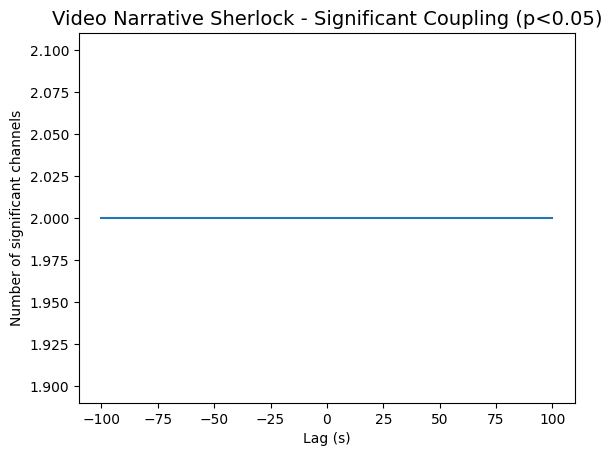

In [37]:
sig_channels_dict = {}
p_value = 0.05
for time_point in time_points:
    time_point_rows = results_df_final[results_df_final["time_point"] == time_point]
    num_sig_channels = sum(time_point_rows["p_value"] < p_value)
    sig_channels_dict[time_point] = num_sig_channels

time_points = list(sig_channels_dict.keys())
num_sig_channels = list(sig_channels_dict.values())

fig, ax = plt.subplots()
ax.plot(time_points, num_sig_channels)
# ax.set_title(f"{exp_name} Significant Coupling", fontsize=14)
ax.set_title(
    f"Video Narrative Sherlock - Significant Coupling (p<{p_value})", fontsize=14
)
ax.set_xlabel("Lag (s)")
ax.set_ylabel("Number of significant channels")
plt.show()

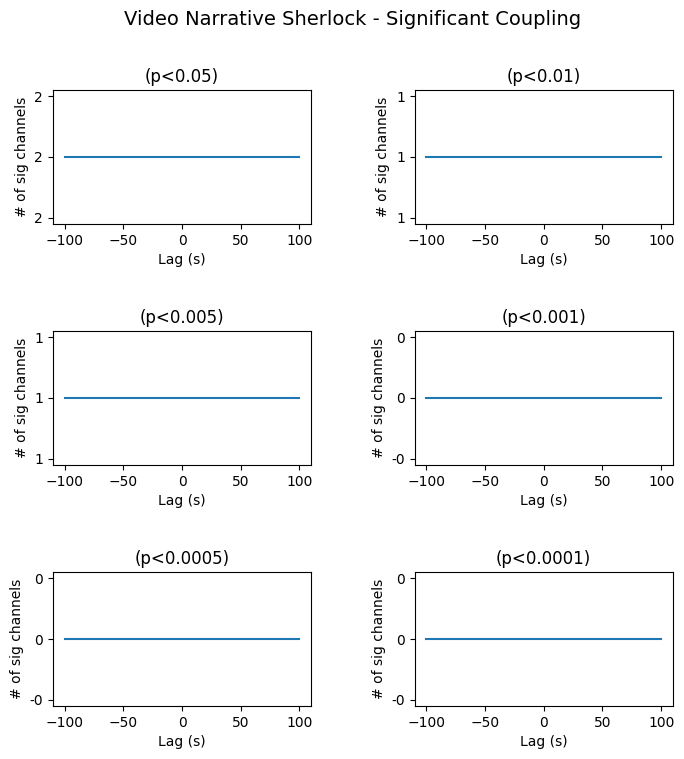

In [38]:
import matplotlib.ticker as ticker

sig_channels_dict = {}
p_values = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
axes = axes.flatten()
for i, p_value in enumerate(p_values):
    for time_point in time_points:
        time_point_rows = results_df_final[results_df_final["time_point"] == time_point]
        num_sig_channels = sum(time_point_rows["p_value"] < p_value)
        sig_channels_dict[time_point] = num_sig_channels

    time_points = list(sig_channels_dict.keys())
    num_sig_channels = list(sig_channels_dict.values())

    axes[i].plot(time_points, num_sig_channels)
    # ax.set_title(f"{exp_name} Significant Coupling", fontsize=14)
    formatter = ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x))
    axes[i].yaxis.set_major_formatter(formatter)
    axes[i].set_title(f"(p<{p_value})", fontsize=12)
    axes[i].set_xlabel("Lag (s)")
    axes[i].set_ylabel("# of sig channels")
fig.suptitle(f"Video Narrative Sherlock - Significant Coupling", fontsize=14)
plt.subplots_adjust(hspace=0.8, wspace=0.4)
plt.show()

In [ ]:
par = Participant_Flow(1)
flow_exp = par.load_flow_exp(exp_name, filter_type="lowpass")

In [90]:
flow_start_idx = flow_exp.index[0]
exp_by_block = par.par_behav.by_block_ts_dict[exp_name]
ts_list = flow_exp["datetime"].apply(lambda x: datetime.datetime.timestamp(x)).tolist()

block_start_ts, block_end_ts = next(iter(exp_by_block.keys()))
block_start_idx, ts1 = par.data_fun.find_closest_ts(
    block_start_ts, ts_list, flow_start_idx
)
block_end_idx, ts2 = par.data_fun.find_closest_ts(block_end_ts, ts_list, flow_start_idx)
# flow_exp.loc[block_start_idx:block_end_idx]

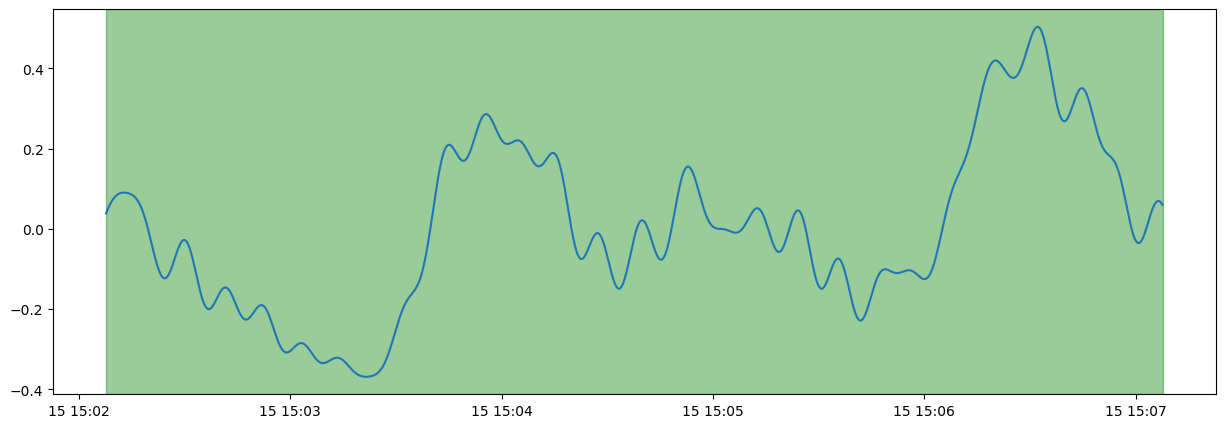

In [94]:
# fig, ax = plt.subplots(figsize=[15, 5])
# ax.plot(flow_exp["datetime"], flow_exp[0])
# ax.axvspan(
#     datetime.datetime.fromtimestamp(block_start_ts),
#     datetime.datetime.fromtimestamp(block_end_ts),
#     color="g",
#     alpha=0.4,
#     label=exp_name,
# )
fig, ax = plt.subplots(figsize=[15, 5])
ax.plot(
    flow_exp.loc[block_start_idx:block_end_idx]["datetime"],
    flow_exp.loc[block_start_idx:block_end_idx][1],
)
ax.axvspan(
    datetime.datetime.fromtimestamp(block_start_ts),
    datetime.datetime.fromtimestamp(block_end_ts),
    color="g",
    alpha=0.4,
    label=exp_name,
)